<a href="https://www.kaggle.com/code/patimejia/contrails-stats-histograms?scriptVersionId=137772941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

base_directory = '/kaggle/input/opencontrails-mini-sample/'

printmd(f"### **Base Directory:** {base_directory}")

### **Base Directory:** /kaggle/input/opencontrails-mini-sample/

In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Input Directory")

from utils_directory_tree_generator import get_directory_tree

tree_generator = get_directory_tree(
    start_path=base_directory,  # Updated this line
    max_depth=5,
    include_files=True,
    sort_by='type',
    reverse=False,
    max_items=5
)
for line in tree_generator:
    print(line)

### Input Directory

input
    opencontrails-mini-sample
        opencontrails_mini_sample
            validation
                1002653297254493116
                1000834164244036115
                1013721207578258217
                1012978360687713914
            test
                1002653297254493116
                1000834164244036115
            train
                1000603527582775543
                100071707854144929
                1000934780200790693
                1000823728928031783
            validation_metadata.json
    google-research-identify-contrails-reduce-global-warming
        validation
            3687499407028137410
                band_10.npy
                band_14.npy
                band_15.npy
                band_16.npy
            6558861185867890815
                band_10.npy
                band_14.npy
                band_15.npy
                band_16.npy
            7355354609194882312
                band_10.npy
                band_14.npy
                band

In [3]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Generating Stats Report and Overlaid Band Histogram ...")

import os
import time
import collections
import math
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle


class DataAnalyzer:
    @staticmethod
    def calculate_statistics(data):
        if data.size == 0:
            return {
                'shape': data.shape,
                'size': data.size,
                'mean': None,
                'std_dev': None,
                'min': None,
                'max': None,
                'median': None,
                'percentiles': [None, None, None],
                'all_zeros': True,
                'zero_count': 0,
                'non_zero_count': 0,
                'has_nan': False,
                'has_inf': False,
                'histogram': ([], [])
            }
        
        hist, bins = np.histogram(data, bins=50)
        hist = hist / data.size
        return {
            'shape': data.shape,
            'size': data.size,
            'mean': np.mean(data),
            'std_dev': np.std(data),
            'min': np.min(data),
            'max': np.max(data),
            'median': np.median(data),
            'percentiles': np.percentile(data, [25, 50, 75]),
            'all_zeros': np.all(data == 0),
            'zero_count': np.count_nonzero(data == 0),
            'non_zero_count': np.count_nonzero(data),
            'has_nan': np.isnan(data).any(),
            'has_inf': np.isinf(data).any(),
            'histogram': (hist, bins)
        }


class HistogramGenerator:
    @staticmethod
    def group_and_plot_histograms_by_dataset_record(file_stats, output_dir, histograms_per_row):
        results_by_dataset_record = collections.defaultdict(list)
        
        for filepath, stats in file_stats.items():
            _, dataset, record_id, _ = filepath.split('/')[-4:]
            results_by_dataset_record[(dataset, record_id)].append((filepath, stats))

        dataset_records = sorted(results_by_dataset_record.keys())
        num_histograms = len(dataset_records)
        num_rows = math.ceil(num_histograms / histograms_per_row)
        fig_band = plt.figure(figsize=(15, num_rows * 7))

        patches_band = []
        labels_band = []

        for i, (dataset, record_id) in enumerate(dataset_records):
            record_results = results_by_dataset_record[(dataset, record_id)]
            band_results = [result for result in record_results if 'band_' in result[0].split('/')[-1]]
            colors_band = cm.viridis(np.linspace(0, 1, len(band_results)))

            ax_band = fig_band.add_subplot(num_rows, histograms_per_row, i + 1)
            for color, (filepath, stats) in zip(colors_band, band_results):
                hist, bins = stats['histogram']
                ax_band.bar(bins[:-1], hist, width=np.diff(bins), ec="k", align="edge", alpha=0.5, color=color)

                if os.path.basename(filepath) not in labels_band:
                    labels_band.append(os.path.basename(filepath))
                    patches_band.append(Rectangle((0, 0), 1, 1, fc=color))

            ax_band.set_title(f'Bands for record {record_id} in {dataset}')
            ax_band.grid(True)

        fig_band.legend(patches_band, labels_band, loc='upper right')
        output_filepath_band = os.path.join(output_dir, f'tiled_bands_histogram.png')
        fig_band.savefig(output_filepath_band)
        plt.close(fig_band)
        
    @staticmethod
    def display_saved_image(img_path):
        # Load and display saved image
        img = mpimg.imread(img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img, aspect='auto')
        plt.axis('off')
        plt.show()


class ReportGenerator:
    ANCHOR_REGEX = re.compile(r'[^\w\- ]', re.UNICODE)

    @staticmethod
    def normalize_anchor(text):
        text = text.lower().replace(' ', '-')
        return ReportGenerator.ANCHOR_REGEX.sub('', text)

    @staticmethod
    def generate_markdown_for_file(filepath, stats):
        markdown = f"### {filepath}\n\n"
        for stat, value in stats.items():
            markdown += f"- **{stat.capitalize()}**: {value}\n"
        markdown += f'\n[Back to ToC](#{ReportGenerator.normalize_anchor("table of contents")})\n\n'
        return markdown

    @staticmethod
    def generate_markdown_section(title, items):
        section = f'## {title}\n\n'
        for item in items:
            section += f"- {item}\n"
        section += f'\n[Back to ToC](#{ReportGenerator.normalize_anchor("table of contents")})\n\n'
        return section

    @staticmethod
    def save_results(markdown_results, files_with_zeros, files_without_zeros):
        total_files = len(markdown_results)
        total_files_with_zeros = len(files_with_zeros)
        total_files_without_zeros = len(files_without_zeros)
        
        summary = f"## Summary\n\n"
        summary += f"- Total files processed: {total_files}\n"
        summary += f"- Files with zeros: {total_files_with_zeros}\n"
        summary += f"- Files without zeros: {total_files_without_zeros}\n\n"
        
        markdown = '# Table of Contents\n\n'
#         markdown += '- [Summary](#summary)\n'
#         markdown += summary
        
        for md in markdown_results:
            markdown += md
        
        with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'w') as results_file:
            results_file.write(markdown)

            
class FileProcessor:
    @staticmethod
    def process_file(filepath):
        try:
            data = np.load(filepath)
            stats = DataAnalyzer.calculate_statistics(data)
            markdown = ReportGenerator.generate_markdown_for_file(filepath, stats)
            has_zeros = stats['zero_count'] > 0
            return filepath, markdown, has_zeros, stats
        except Exception as e:
            print(f"Error processing file {filepath}: {str(e)}")
            return None, None, None, None

    @staticmethod
    def process_directory(directory_path):
        markdown_results, file_stats = [], {}
        files_with_zeros, files_without_zeros = [], []

        for root, dirs, files in os.walk(directory_path):
            dirs[:] = [d for d in dirs if d not in ['test']] #adjust to include test dir
            for file in filter(lambda f: f.endswith('.npy'), files):
                filepath, markdown, has_zeros, stats = FileProcessor.process_file(os.path.join(root, file))
                if all([filepath, markdown, stats]):
                    markdown_results.append(markdown)
                    file_stats[filepath] = stats
                    (files_with_zeros if has_zeros else files_without_zeros).append(filepath)

        return markdown_results, files_with_zeros, files_without_zeros, file_stats


def main():
    start_time = time.time()

    os.makedirs('/kaggle/working/numpy_stats', exist_ok=True)
    try:
        markdown_results, files_with_zeros, files_without_zeros, file_stats = FileProcessor.process_directory(base_directory)
        ReportGenerator.save_results(markdown_results, files_with_zeros, files_without_zeros)
        HistogramGenerator.group_and_plot_histograms_by_dataset_record(file_stats, '/kaggle/working/numpy_stats', 4) # Adjust number of histograms per row here
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    elapsed_time = time.time() - start_time
    processed_files_count = len(markdown_results)
    print(f"Total time taken: {elapsed_time:.4f} seconds")
    print(f"Total number of files processed: {processed_files_count}")
    print(f"Processed {processed_files_count/elapsed_time:.2f} files per second.")


main()


### Generating Stats Report and Overlaid Band Histogram ...

Total time taken: 13.9600 seconds
Total number of files processed: 126
Processed 9.03 files per second.


# Usage:
- Set `base_directory`:
  - Entire dataset: `'/kaggle/input/google-research-identify-contrails-reduce-global-warming'`
  - `test` folder only: `'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'`
- Execute code.
- Check output at `'/kaggle/working/numpy_stats'`.

In [4]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Output Directory:")

from utils_directory_tree_generator import get_directory_tree

tree_generator = get_directory_tree(
    start_path='/kaggle/working/numpy_stats',
    max_depth=4,
    include_files=True,
    sort_by='type',
    reverse=False,
    max_items=4
)
for line in tree_generator:
    print(line)

### Output Directory:

numpy_stats
    tiled_bands_histogram.png
    zeros_dataset_report.md


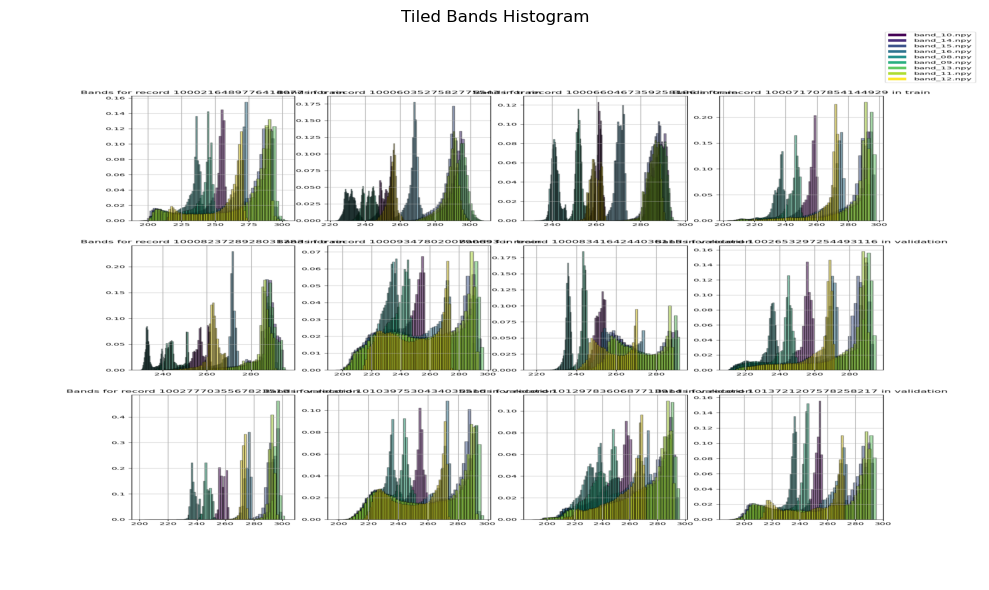

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_image_title(img_path):
    # Get title from path
    return img_path.split('/')[-1].split('.')[0].replace('_', ' ').title()

def display_image(ax, img_path):
    # Load and display image
    img = mpimg.imread(img_path)
    ax.imshow(img, aspect='auto')
    ax.axis('off')
    ax.set_title(get_image_title(img_path))

def display_images(image_files):
    # Display list of images
    n_images = len(image_files)
    fig = plt.figure(figsize=(10 * n_images, 6))
    
    for i, image_file in enumerate(image_files):
        ax = fig.add_subplot(1, n_images, i+1)
        img_path = f'/kaggle/working/numpy_stats/{image_file}'
        display_image(ax, img_path)
    
    plt.tight_layout()
    plt.show()

# Image list
image_files = ['tiled_bands_histogram.png']
display_images(image_files)

/kaggle/working


### Loading Data and Generating Temporal Distribution Histogram ...

Plot saved to: /kaggle/working/output/temporal_distribution_analysis/train_vs_validation_distribution.png


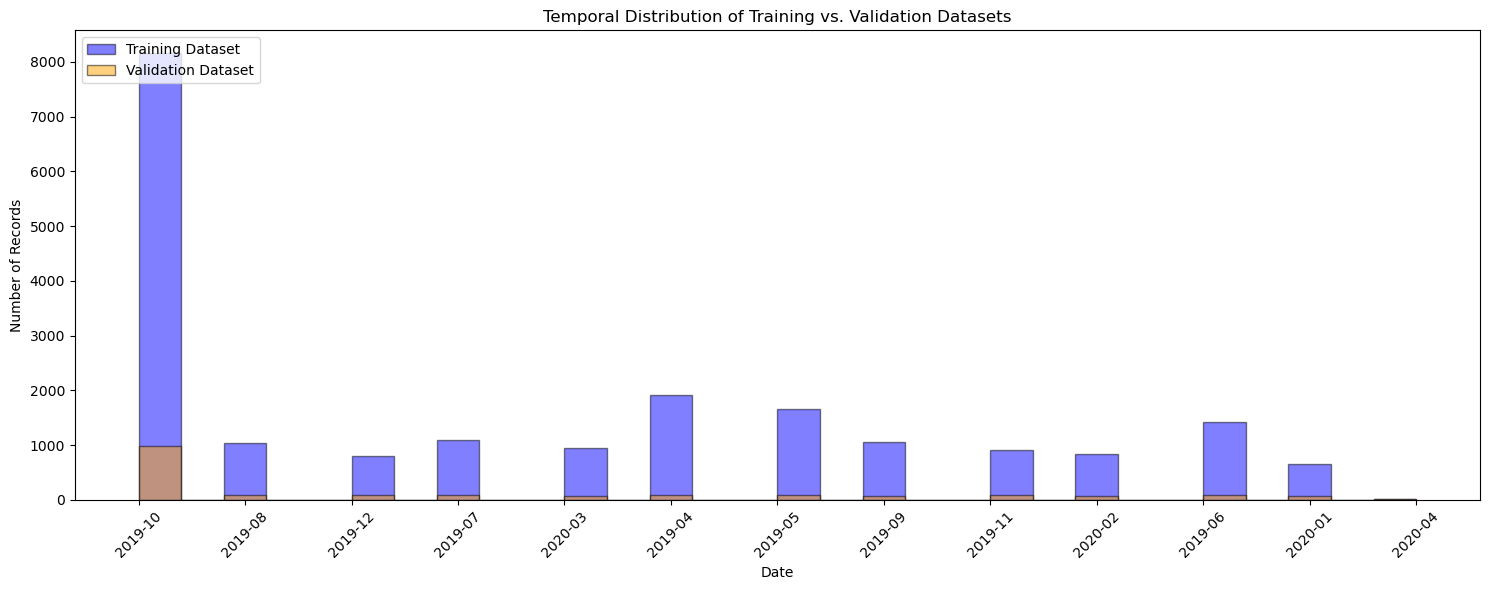

In [6]:
from IPython.display import Markdown, display
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
import collections


print(os.getcwd())

def printmd(string):
    display(Markdown(string))

class DataLoader:
    @staticmethod
    def load_json_file(filename):
        # Load JSON from a file
        with open(filename, 'r') as f:
            return json.load(f)

    @staticmethod
    def get_timestamps(data):
        # Extract timestamps from data
        return [entry["timestamp"] for entry in data]

    @staticmethod
    def to_datetime_format(timestamps):
        # Convert timestamps to datetime
        return [datetime.utcfromtimestamp(ts).strftime('%Y-%m') for ts in timestamps]


class PlotGenerator:
    @staticmethod
    def plot_and_save_histogram(train_dates, validation_dates, save_path=None):
        # Plot histogram and save
        plt.figure(figsize=(15, 6))
        plt.hist(train_dates, bins=30, alpha=0.5, label="Training Dataset", color="blue", edgecolor="black")
        plt.hist(validation_dates, bins=30, alpha=0.5, label="Validation Dataset", color="orange", edgecolor="black")
        plt.title("Temporal Distribution of Training vs. Validation Datasets")
        plt.xlabel("Date")
        plt.ylabel("Number of Records")
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Plot saved to: {save_path}")

        plt.show()

    @staticmethod
    def ensure_dir_exists(directory):
        # Create directory if not exists
        if not os.path.exists(directory):
            os.makedirs(directory)


def main():
    printmd("### Loading Data and Generating Temporal Distribution Histogram ...")

    base_directory = '/kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/'

    # Paths
    train_file_path = os.path.join(base_directory, "train_metadata.json")
    validation_file_path = os.path.join(base_directory, "validation_metadata.json")

    
    # Load data and convert timestamps
    train_dates = DataLoader.to_datetime_format(DataLoader.get_timestamps(DataLoader.load_json_file(train_file_path)))
    validation_dates = DataLoader.to_datetime_format(DataLoader.get_timestamps(DataLoader.load_json_file(validation_file_path)))

    if not train_dates and not validation_dates:
        print("No valid months found for datasets.")
        return

    # Directories setup
    output_dir = "/kaggle/working/output"
    script_name_dir = "temporal_distribution_analysis"
    full_dir_path = os.path.join(output_dir, script_name_dir)
    PlotGenerator.ensure_dir_exists(full_dir_path)

    # Plot and save histogram
    plot_filename = os.path.join(full_dir_path, "train_vs_validation_distribution.png")
    PlotGenerator.plot_and_save_histogram(train_dates, validation_dates, save_path=plot_filename)


main()


# From the temporal breakdown of the Training vs. Validation datasets:
  - **Training Dataset:**
    - Records span several months.
    - Uneven distribution with peaks in specific months.
  - **Validation Dataset:**
    - Data concentrated in fewer months.
    - Likely a specific collection period or subset.

- **Key Insights:**
  - Temporal distribution can explain model performance anomalies.
  - Potential reasons: data underrepresentation or external influences.
  - Uneven monthly distribution may impact model's handling of varying solar zenith angles.

- **Next Steps:**
  - Examine spatial distribution and its relation to solar zenith angle.
  - Open for feedback or questions on the temporal analysis.

In [7]:
from IPython.display import Markdown

# Display contents of zeros_dataset_report.md
with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'r') as f:
    markdown_content = f.read()
Markdown(markdown_content)


# Table of Contents

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 248.8288116455078
- **Std_dev**: 11.444403648376465
- **Min**: 211.2795867919922
- **Max**: 265.919921875
- **Median**: 254.24832153320312
- **Percentiles**: [245.13962555 254.2483139  256.40771484]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.76565552e-04, 1.36375427e-03, 2.73323059e-03, 3.87763977e-03,
       4.88853455e-03, 5.58280945e-03, 5.67245483e-03, 6.33049011e-03,
       6.80732727e-03, 7.55500793e-03, 8.06999207e-03, 8.53538513e-03,
       9.23347473e-03, 9.23728943e-03, 9.43756104e-03, 9.45472717e-03,
       1.04598999e-02, 1.04122162e-02, 1.00498199e-02, 1.05762482e-02,
       1.03893280e-02, 1.00898743e-02, 9.85717773e-03, 9.56535339e-03,
       9.57298279e-03, 9.23538208e-03, 9.43946838e-03, 9.45854187e-03,
       1.00460052e-02, 1.03855133e-02, 1.16024017e-02, 1.44023895e-02,
       1.85337067e-02, 2.24304199e-02, 2.43835449e-02, 2.61631012e-02,
       2.66628265e-02, 3.08666229e-02, 5.86185455e-02, 9.85488892e-02,
       1.44134521e-01, 1.03816986e-01, 9.33551788e-02, 6.86702728e-02,
       1.65824890e-02, 1.98364258e-03, 3.43322754e-04, 1.29699707e-04,
       1.22070312e-04, 5.53131104e-05]), array([211.27959, 212.37239, 213.4652 , 214.55801, 215.65082, 216.74362,
       217.83643, 218.92923, 220.02203, 221.11485, 222.20766, 223.30046,
       224.39326, 225.48607, 226.57889, 227.67169, 228.7645 , 229.8573 ,
       230.9501 , 232.04291, 233.13573, 234.22853, 235.32133, 236.41414,
       237.50694, 238.59976, 239.69257, 240.78537, 241.87817, 242.97098,
       244.06378, 245.1566 , 246.2494 , 247.34221, 248.43501, 249.52782,
       250.62062, 251.71344, 252.80624, 253.89905, 254.99185, 256.08466,
       257.17746, 258.27026, 259.36307, 260.4559 , 261.5487 , 262.6415 ,
       263.7343 , 264.82712, 265.91992], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 273.9056701660156
- **Std_dev**: 21.20493507385254
- **Min**: 211.59524536132812
- **Max**: 293.8205871582031
- **Median**: 284.77545166015625
- **Percentiles**: [264.73403168 284.77546692 289.10406494]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00052261, 0.00279617, 0.00486183, 0.00595856, 0.00633621,
       0.00657463, 0.00731659, 0.00800896, 0.00808144, 0.00837326,
       0.00849915, 0.0083046 , 0.00831413, 0.00812912, 0.00797844,
       0.00817299, 0.00819778, 0.00860786, 0.00843811, 0.00769424,
       0.00832748, 0.00862312, 0.0087719 , 0.00817871, 0.00819016,
       0.00843811, 0.00820732, 0.00850868, 0.00878716, 0.00915909,
       0.00996017, 0.01029778, 0.01140976, 0.01251221, 0.01410103,
       0.01490021, 0.01673508, 0.01874161, 0.01928902, 0.02014351,
       0.02093124, 0.02219009, 0.02534485, 0.03335762, 0.05552483,
       0.08631516, 0.1128273 , 0.14316368, 0.09123611, 0.03466034]), array([211.59525, 213.23975, 214.88426, 216.52876, 218.17328, 219.81778,
       221.46228, 223.1068 , 224.7513 , 226.39581, 228.04031, 229.68481,
       231.32933, 232.97383, 234.61835, 236.26285, 237.90735, 239.55186,
       241.19637, 242.84088, 244.48538, 246.12988, 247.7744 , 249.4189 ,
       251.06342, 252.70792, 254.35242, 255.99693, 257.64145, 259.28595,
       260.93045, 262.57495, 264.21945, 265.86398, 267.50848, 269.15298,
       270.7975 , 272.442  , 274.08652, 275.73102, 277.37552, 279.02002,
       280.66452, 282.30905, 283.95355, 285.59805, 287.24255, 288.88705,
       290.5316 , 292.1761 , 293.8206 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 269.972412109375
- **Std_dev**: 21.062767028808594
- **Min**: 210.42147827148438
- **Max**: 290.4158630371094
- **Median**: 280.79638671875
- **Percentiles**: [260.25856781 280.79637146 285.20090485]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00069809, 0.00352859, 0.00579262, 0.00711632, 0.00726318,
       0.00777626, 0.00861168, 0.00871468, 0.0090847 , 0.00923157,
       0.00886536, 0.00886154, 0.00854301, 0.00836754, 0.0086689 ,
       0.00880623, 0.00882721, 0.00828552, 0.00811958, 0.00890923,
       0.00883293, 0.00826073, 0.00801086, 0.00800896, 0.00809479,
       0.00798988, 0.0083313 , 0.008255  , 0.00884819, 0.00960541,
       0.01019096, 0.01086426, 0.01182938, 0.01286697, 0.01449585,
       0.01617241, 0.01809502, 0.0182724 , 0.01887894, 0.01886559,
       0.01904488, 0.02087021, 0.02692223, 0.04510307, 0.0721817 ,
       0.08891106, 0.12547493, 0.11695099, 0.08069992, 0.01499939]), array([210.42148, 212.02136, 213.62125, 215.22115, 216.82103, 218.42091,
       220.0208 , 221.6207 , 223.22058, 224.82047, 226.42035, 228.02025,
       229.62013, 231.22002, 232.8199 , 234.4198 , 236.01968, 237.61957,
       239.21945, 240.81935, 242.41924, 244.01912, 245.619  , 247.2189 ,
       248.81879, 250.41867, 252.01855, 253.61844, 255.21834, 256.8182 ,
       258.41812, 260.018  , 261.6179 , 263.21777, 264.81766, 266.41754,
       268.01743, 269.6173 , 271.21722, 272.8171 , 274.417  , 276.01688,
       277.61676, 279.21664, 280.81653, 282.4164 , 284.01633, 285.6162 ,
       287.2161 , 288.81598, 290.41586], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 257.92529296875
- **Std_dev**: 17.2115478515625
- **Min**: 210.474609375
- **Max**: 274.65771484375
- **Median**: 266.8360290527344
- **Percentiles**: [249.48088837 266.83602905 270.47958374]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00067329, 0.00343513, 0.00598717, 0.00776672, 0.00797653,
       0.00861549, 0.00912857, 0.00951958, 0.00964928, 0.00980949,
       0.00954247, 0.0093708 , 0.0088501 , 0.0092926 , 0.0093956 ,
       0.00895882, 0.00874901, 0.00878525, 0.00914192, 0.00857353,
       0.00820923, 0.00797844, 0.00791931, 0.00790024, 0.0078907 ,
       0.00790215, 0.00787735, 0.00817108, 0.00918961, 0.00977325,
       0.01032448, 0.0108242 , 0.01159286, 0.0133934 , 0.01506233,
       0.01636505, 0.01727486, 0.01747894, 0.01747513, 0.01726151,
       0.01796722, 0.01946068, 0.02851677, 0.04606438, 0.06979179,
       0.08517075, 0.12537766, 0.11618042, 0.08395958, 0.01442528]), array([210.47461, 211.75827, 213.04193, 214.32559, 215.60925, 216.89291,
       218.17657, 219.46025, 220.74391, 222.02757, 223.31123, 224.5949 ,
       225.87856, 227.16222, 228.44588, 229.72954, 231.0132 , 232.29686,
       233.58052, 234.8642 , 236.14786, 237.43152, 238.71518, 239.99884,
       241.2825 , 242.56616, 243.84982, 245.13348, 246.41714, 247.7008 ,
       248.98447, 250.26813, 251.5518 , 252.83546, 254.11913, 255.40279,
       256.68643, 257.9701 , 259.25378, 260.53745, 261.8211 , 263.10477,
       264.38843, 265.6721 , 266.95575, 268.2394 , 269.52307, 270.80673,
       272.0904 , 273.37405, 274.6577 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 231.5784454345703
- **Std_dev**: 6.768033504486084
- **Min**: 209.64309692382812
- **Max**: 242.36346435546875
- **Median**: 234.40443420410156
- **Percentiles**: [228.77297974 234.4044342  236.26690674]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-05, 5.03540039e-04, 1.37901306e-03, 2.54249573e-03,
       3.58200073e-03, 4.92858887e-03, 5.99861145e-03, 6.54983521e-03,
       7.50541687e-03, 8.47244263e-03, 8.58688354e-03, 9.21058655e-03,
       1.01833344e-02, 1.05304718e-02, 1.16271973e-02, 1.21631622e-02,
       1.25350952e-02, 1.23958588e-02, 1.22089386e-02, 1.13410950e-02,
       1.08222961e-02, 1.06620789e-02, 1.04961395e-02, 1.03149414e-02,
       1.01299286e-02, 9.91058350e-03, 1.02157593e-02, 1.06258392e-02,
       1.15737915e-02, 1.37367249e-02, 1.76486969e-02, 2.10113525e-02,
       2.24170685e-02, 2.36740112e-02, 2.34165192e-02, 2.90336609e-02,
       4.59728241e-02, 6.92806244e-02, 8.51020813e-02, 8.88004303e-02,
       8.96148682e-02, 7.81116486e-02, 5.99689484e-02, 3.93524170e-02,
       3.19881439e-02, 1.00288391e-02, 2.00653076e-03, 1.14631653e-03,
       4.73022461e-04, 1.43051147e-04]), array([209.6431 , 210.2975 , 210.9519 , 211.60632, 212.26073, 212.91513,
       213.56953, 214.22395, 214.87836, 215.53276, 216.18716, 216.84158,
       217.49599, 218.15039, 218.8048 , 219.45921, 220.11362, 220.76802,
       221.42242, 222.07684, 222.73125, 223.38565, 224.04005, 224.69447,
       225.34888, 226.00328, 226.65768, 227.31209, 227.9665 , 228.62091,
       229.27531, 229.92972, 230.58414, 231.23854, 231.89294, 232.54735,
       233.20177, 233.85617, 234.51057, 235.16498, 235.8194 , 236.4738 ,
       237.1282 , 237.78261, 238.43703, 239.09143, 239.74583, 240.40024,
       241.05466, 241.70906, 242.36346], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 239.7407989501953
- **Std_dev**: 8.969274520874023
- **Min**: 210.49171447753906
- **Max**: 255.10675048828125
- **Median**: 243.6463623046875
- **Percentiles**: [236.52803421 243.64635468 245.67095947]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.86920166e-04, 1.01470947e-03, 2.29263306e-03, 3.41796875e-03,
       4.59480286e-03, 5.77545166e-03, 6.10923767e-03, 6.81686401e-03,
       7.71522522e-03, 8.04519653e-03, 8.81195068e-03, 9.56153870e-03,
       1.03549957e-02, 1.06849670e-02, 1.13735199e-02, 1.17721558e-02,
       1.15375519e-02, 1.19132996e-02, 1.14612579e-02, 1.05094910e-02,
       1.04217529e-02, 1.06544495e-02, 1.01642609e-02, 9.60922241e-03,
       9.65309143e-03, 9.85717773e-03, 1.03416443e-02, 1.07517242e-02,
       1.21974945e-02, 1.50299072e-02, 1.89571381e-02, 2.20909119e-02,
       2.36034393e-02, 2.48279572e-02, 2.61821747e-02, 3.77750397e-02,
       7.01923370e-02, 9.70115662e-02, 1.26054764e-01, 8.61225128e-02,
       8.24279785e-02, 5.21106720e-02, 4.30202484e-02, 1.71184540e-02,
       5.11741638e-03, 2.71797180e-03, 1.35231018e-03, 5.13076782e-04,
       1.33514404e-04, 4.00543213e-05]), array([210.49171, 211.38402, 212.27632, 213.16861, 214.06091, 214.95322,
       215.84552, 216.73782, 217.63013, 218.52242, 219.41472, 220.30702,
       221.19933, 222.09163, 222.98392, 223.87622, 224.76852, 225.66083,
       226.55313, 227.44543, 228.33772, 229.23003, 230.12233, 231.01463,
       231.90694, 232.79922, 233.69153, 234.58383, 235.47614, 236.36844,
       237.26074, 238.15303, 239.04533, 239.93764, 240.82994, 241.72224,
       242.61455, 243.50684, 244.39914, 245.29144, 246.18375, 247.07605,
       247.96834, 248.86064, 249.75294, 250.64525, 251.53755, 252.42986,
       253.32214, 254.21445, 255.10675], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 276.9031982421875
- **Std_dev**: 20.013086318969727
- **Min**: 213.48106384277344
- **Max**: 295.03533935546875
- **Median**: 287.1636047363281
- **Percentiles**: [269.23300171 287.16360474 290.91251373]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00026512, 0.00175285, 0.00324059, 0.00438499, 0.00475693,
       0.00498199, 0.00531387, 0.00593185, 0.00636673, 0.00673676,
       0.00711632, 0.00741005, 0.00767899, 0.00758934, 0.00764275,
       0.0077095 , 0.00769997, 0.00782776, 0.00789833, 0.00815201,
       0.00845528, 0.00802994, 0.00780487, 0.00846863, 0.0088768 ,
       0.00911903, 0.00872993, 0.00885391, 0.00891304, 0.00901604,
       0.00951004, 0.00994873, 0.01050568, 0.0113163 , 0.01259232,
       0.01445389, 0.01628304, 0.01745605, 0.01917648, 0.02115059,
       0.02316093, 0.02523994, 0.02654839, 0.02887344, 0.03845406,
       0.06774521, 0.11960983, 0.15588951, 0.11919212, 0.04616928]), array([213.48106, 215.11215, 216.74324, 218.37431, 220.0054 , 221.63649,
       223.26758, 224.89867, 226.52975, 228.16083, 229.79192, 231.423  ,
       233.0541 , 234.68518, 236.31625, 237.94734, 239.57843, 241.20952,
       242.8406 , 244.4717 , 246.10277, 247.73386, 249.36494, 250.99603,
       252.62712, 254.25821, 255.88928, 257.5204 , 259.15146, 260.78253,
       262.41364, 264.0447 , 265.6758 , 267.3069 , 268.93796, 270.56906,
       272.20013, 273.83124, 275.4623 , 277.09338, 278.7245 , 280.35556,
       281.98666, 283.61774, 285.24884, 286.8799 , 288.511  , 290.1421 ,
       291.77316, 293.40427, 295.03534], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 275.0368957519531
- **Std_dev**: 18.844661712646484
- **Min**: 212.91720581054688
- **Max**: 291.66796875
- **Median**: 284.6396484375
- **Percentiles**: [268.50241852 284.63963318 288.04981232]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00030518, 0.00162888, 0.00275803, 0.00375938, 0.0042057 ,
       0.00447655, 0.00463867, 0.00495529, 0.00564766, 0.00572968,
       0.00642395, 0.00656128, 0.00692749, 0.00702667, 0.00725746,
       0.00716782, 0.00746155, 0.00754166, 0.00754356, 0.00760841,
       0.00793266, 0.00820541, 0.00826454, 0.00775528, 0.00825882,
       0.008955  , 0.00925636, 0.0087986 , 0.00899506, 0.00905418,
       0.00932121, 0.00963593, 0.01004219, 0.01079178, 0.01156807,
       0.01307297, 0.01523018, 0.01730156, 0.01889992, 0.02086639,
       0.02345657, 0.02563477, 0.0282383 , 0.02993584, 0.03510284,
       0.05714417, 0.11043358, 0.1580143 , 0.14970207, 0.05050659]), array([212.9172 , 214.49222, 216.06723, 217.64226, 219.21727, 220.79228,
       222.3673 , 223.9423 , 225.51733, 227.09235, 228.66736, 230.24237,
       231.81738, 233.39241, 234.96742, 236.54243, 238.11745, 239.69246,
       241.26749, 242.8425 , 244.41751, 245.99252, 247.56754, 249.14256,
       250.71758, 252.29259, 253.8676 , 255.44261, 257.01764, 258.59265,
       260.16766, 261.74268, 263.3177 , 264.8927 , 266.4677 , 268.04272,
       269.61777, 271.19278, 272.7678 , 274.3428 , 275.91782, 277.49283,
       279.06784, 280.64285, 282.21786, 283.7929 , 285.36792, 286.94293,
       288.51794, 290.09296, 291.66797], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002653297254493116/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 259.1632385253906
- **Std_dev**: 12.927360534667969
- **Min**: 219.3023681640625
- **Max**: 271.2978210449219
- **Median**: 265.6063232421875
- **Percentiles**: [253.80823898 265.6063385  268.4543457 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00056648, 0.0025425 , 0.00414276, 0.0048008 , 0.00515938,
       0.00524139, 0.00561142, 0.00648117, 0.00673866, 0.00716972,
       0.00738716, 0.00757217, 0.00782585, 0.00782013, 0.00786591,
       0.00790405, 0.00798607, 0.00789261, 0.00810432, 0.00817108,
       0.00836182, 0.00782204, 0.00820732, 0.00868225, 0.00921059,
       0.0090847 , 0.00895309, 0.00921249, 0.00919533, 0.00969505,
       0.01024628, 0.01070213, 0.01145935, 0.01292801, 0.01473236,
       0.01600838, 0.01712608, 0.01891708, 0.02170753, 0.022686  ,
       0.02411079, 0.02553368, 0.0268364 , 0.03069878, 0.04515839,
       0.07085419, 0.11827087, 0.14669609, 0.10539818, 0.0345211 ]), array([219.30237, 220.34227, 221.38219, 222.42209, 223.462  , 224.5019 ,
       225.54182, 226.58173, 227.62164, 228.66154, 229.70146, 230.74136,
       231.78128, 232.82118, 233.8611 , 234.901  , 235.94092, 236.98082,
       238.02074, 239.06064, 240.10056, 241.14046, 242.18037, 243.22028,
       244.2602 , 245.3001 , 246.34   , 247.37991, 248.41982, 249.45973,
       250.49963, 251.53955, 252.57945, 253.61937, 254.65927, 255.69919,
       256.7391 , 257.779  , 258.8189 , 259.85883, 260.89874, 261.93863,
       262.97855, 264.01846, 265.05838, 266.09827, 267.13818, 268.1781 ,
       269.21802, 270.2579 , 271.29782], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 251.42457580566406
- **Std_dev**: 2.7326555252075195
- **Min**: 219.58058166503906
- **Max**: 255.59690856933594
- **Median**: 251.8728790283203
- **Percentiles**: [249.77569199 251.87287903 253.52368164]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 0.00000000e+00, 7.62939453e-06, 3.81469727e-06,
       3.81469727e-06, 9.53674316e-06, 1.14440918e-05, 9.53674316e-06,
       1.14440918e-05, 7.62939453e-06, 1.90734863e-05, 1.71661377e-05,
       1.14440918e-05, 2.67028809e-05, 1.14440918e-05, 1.52587891e-05,
       3.24249268e-05, 2.67028809e-05, 2.28881836e-05, 3.24249268e-05,
       8.58306885e-05, 1.12533569e-04, 1.31607056e-04, 1.81198120e-04,
       1.90734863e-04, 2.76565552e-04, 3.58581543e-04, 5.45501709e-04,
       8.04901123e-04, 1.15394592e-03, 1.60408020e-03, 2.19345093e-03,
       3.26156616e-03, 4.41360474e-03, 6.10351562e-03, 9.65690613e-03,
       1.42879486e-02, 1.89895630e-02, 2.54688263e-02, 3.14998627e-02,
       5.41248322e-02, 8.12492371e-02, 8.44554901e-02, 8.30001831e-02,
       9.07268524e-02, 9.66033936e-02, 1.22669220e-01, 1.10288620e-01,
       1.09348297e-01, 4.59289551e-02]), array([219.58058, 220.3009 , 221.02124, 221.74156, 222.46188, 223.18222,
       223.90254, 224.62286, 225.3432 , 226.06352, 226.78384, 227.50418,
       228.2245 , 228.94482, 229.66515, 230.38548, 231.1058 , 231.82613,
       232.54646, 233.26678, 233.9871 , 234.70744, 235.42776, 236.14809,
       236.86842, 237.58875, 238.30907, 239.0294 , 239.74973, 240.47005,
       241.19038, 241.9107 , 242.63103, 243.35136, 244.07169, 244.792  ,
       245.51234, 246.23267, 246.95299, 247.67331, 248.39365, 249.11397,
       249.83429, 250.55463, 251.27495, 251.99527, 252.7156 , 253.43593,
       254.15625, 254.87659, 255.59691], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 271.33807373046875
- **Std_dev**: 11.806071281433105
- **Min**: 221.86102294921875
- **Max**: 290.6600646972656
- **Median**: 269.46490478515625
- **Percentiles**: [261.07318115 269.46488953 282.89597321]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 3.81469727e-06, 3.81469727e-06, 7.62939453e-06,
       7.62939453e-06, 1.14440918e-05, 1.33514404e-05, 9.53674316e-06,
       1.33514404e-05, 2.47955322e-05, 4.00543213e-05, 9.53674316e-05,
       1.16348267e-04, 1.16348267e-04, 1.25885010e-04, 1.10626221e-04,
       3.35693359e-04, 7.13348389e-04, 1.88636780e-03, 3.24249268e-03,
       4.41932678e-03, 9.69505310e-03, 1.35383606e-02, 1.76582336e-02,
       2.28099823e-02, 3.83815765e-02, 5.72280884e-02, 5.46722412e-02,
       4.86125946e-02, 4.82292175e-02, 4.33578491e-02, 3.92627716e-02,
       3.73420715e-02, 3.72886658e-02, 3.37562561e-02, 3.02276611e-02,
       2.86369324e-02, 2.68592834e-02, 2.48241425e-02, 2.37808228e-02,
       2.32944489e-02, 2.30083466e-02, 2.27279663e-02, 2.42557526e-02,
       2.64472961e-02, 2.84557343e-02, 3.60908508e-02, 4.75883484e-02,
       5.88703156e-02, 6.17980957e-02]), array([221.86102, 223.237  , 224.61299, 225.98897, 227.36494, 228.74092,
       230.11691, 231.49289, 232.86887, 234.24486, 235.62083, 236.99681,
       238.37279, 239.74878, 241.12476, 242.50073, 243.87671, 245.2527 ,
       246.62868, 248.00465, 249.38065, 250.75662, 252.1326 , 253.50858,
       254.88457, 256.26056, 257.63654, 259.0125 , 260.3885 , 261.76447,
       263.14044, 264.51642, 265.8924 , 267.2684 , 268.64438, 270.02036,
       271.39633, 272.7723 , 274.1483 , 275.52426, 276.90027, 278.27625,
       279.65222, 281.0282 , 282.40417, 283.78015, 285.15613, 286.53214,
       287.9081 , 289.2841 , 290.66006], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 268.6926574707031
- **Std_dev**: 10.894463539123535
- **Min**: 220.5182342529297
- **Max**: 287.3263244628906
- **Median**: 266.746826171875
- **Percentiles**: [259.51351929 266.74684143 278.96224213]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 5.72204590e-06, 9.53674316e-06, 3.81469727e-06,
       9.53674316e-06, 1.71661377e-05, 7.62939453e-06, 1.33514404e-05,
       2.28881836e-05, 1.33514404e-05, 5.34057617e-05, 8.96453857e-05,
       1.04904175e-04, 1.35421753e-04, 1.18255615e-04, 1.16348267e-04,
       2.34603882e-04, 5.76019287e-04, 1.06811523e-03, 2.13050842e-03,
       3.68118286e-03, 4.89997864e-03, 9.94873047e-03, 1.48315430e-02,
       1.98497772e-02, 2.49271393e-02, 3.56407166e-02, 5.94730377e-02,
       6.16168976e-02, 5.39512634e-02, 5.30185699e-02, 4.80403900e-02,
       4.23545837e-02, 3.94287109e-02, 3.93943787e-02, 3.65886688e-02,
       3.12328339e-02, 2.91461945e-02, 2.65502930e-02, 2.45532990e-02,
       2.31704712e-02, 2.23960876e-02, 2.27680206e-02, 2.41603851e-02,
       2.55527496e-02, 2.88925171e-02, 3.71074677e-02, 4.28695679e-02,
       4.81529236e-02, 6.10675812e-02]), array([220.51823, 221.8544 , 223.19055, 224.52672, 225.86288, 227.19904,
       228.5352 , 229.87137, 231.20753, 232.54369, 233.87985, 235.21602,
       236.55217, 237.88834, 239.2245 , 240.56067, 241.89682, 243.23299,
       244.56915, 245.9053 , 247.24147, 248.57764, 249.91379, 251.24995,
       252.58612, 253.92227, 255.25844, 256.5946 , 257.93076, 259.26694,
       260.6031 , 261.93924, 263.27542, 264.61157, 265.94772, 267.2839 ,
       268.62006, 269.9562 , 271.2924 , 272.62854, 273.96472, 275.30087,
       276.63702, 277.9732 , 279.30936, 280.6455 , 281.9817 , 283.31784,
       284.654  , 285.99017, 287.32632], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 260.7223815917969
- **Std_dev**: 7.699599266052246
- **Min**: 219.97015380859375
- **Max**: 274.139404296875
- **Median**: 259.64434814453125
- **Percentiles**: [254.54560471 259.64434814 267.57260895]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 7.62939453e-06, 5.72204590e-06, 1.14440918e-05,
       1.52587891e-05, 1.33514404e-05, 1.14440918e-05, 2.09808350e-05,
       1.90734863e-05, 2.28881836e-05, 2.47955322e-05, 5.14984131e-05,
       9.15527344e-05, 1.16348267e-04, 1.23977661e-04, 1.31607056e-04,
       1.35421753e-04, 1.85012817e-04, 2.93731689e-04, 6.08444214e-04,
       1.18446350e-03, 1.56593323e-03, 2.96211243e-03, 4.67681885e-03,
       6.42204285e-03, 1.18904114e-02, 1.57337189e-02, 2.22587585e-02,
       2.61878967e-02, 3.60450745e-02, 5.91907501e-02, 6.53705597e-02,
       5.93776703e-02, 5.65452576e-02, 5.34496307e-02, 4.76474762e-02,
       4.38728333e-02, 4.35867310e-02, 4.12616730e-02, 3.41739655e-02,
       3.15761566e-02, 2.92186737e-02, 2.76794434e-02, 2.79693604e-02,
       2.84080505e-02, 3.30486298e-02, 3.91559601e-02, 4.12788391e-02,
       4.47216034e-02, 6.16455078e-02]), array([219.97015, 221.05354, 222.13692, 223.2203 , 224.3037 , 225.38708,
       226.47046, 227.55385, 228.63724, 229.72061, 230.804  , 231.88739,
       232.97078, 234.05415, 235.13754, 236.22093, 237.30432, 238.3877 ,
       239.47108, 240.55447, 241.63785, 242.72124, 243.80463, 244.88802,
       245.97139, 247.05478, 248.13817, 249.22154, 250.30493, 251.38832,
       252.47171, 253.55508, 254.63847, 255.72186, 256.80524, 257.88864,
       258.97202, 260.0554 , 261.1388 , 262.22217, 263.30554, 264.38895,
       265.47232, 266.5557 , 267.6391 , 268.72247, 269.80588, 270.88925,
       271.97263, 273.05603, 274.1394 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 235.62496948242188
- **Std_dev**: 1.5126888751983643
- **Min**: 217.29856872558594
- **Max**: 239.01109313964844
- **Median**: 235.82269287109375
- **Percentiles**: [235.08291245 235.82269287 236.57033157]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 1.33514404e-05, 1.14440918e-05,
       1.33514404e-05, 1.71661377e-05, 2.47955322e-05, 1.33514404e-05,
       2.09808350e-05, 2.47955322e-05, 1.52587891e-05, 3.43322754e-05,
       2.28881836e-05, 4.19616699e-05, 4.19616699e-05, 5.53131104e-05,
       4.38690186e-05, 6.86645508e-05, 9.91821289e-05, 1.54495239e-04,
       2.00271606e-04, 2.84194946e-04, 3.75747681e-04, 4.55856323e-04,
       6.50405884e-04, 8.14437866e-04, 1.13105774e-03, 1.64985657e-03,
       1.95312500e-03, 2.44522095e-03, 3.38554382e-03, 4.54902649e-03,
       5.96809387e-03, 7.59506226e-03, 9.54437256e-03, 1.25579834e-02,
       1.81903839e-02, 2.26421356e-02, 3.09448242e-02, 4.75273132e-02,
       8.15773010e-02, 1.35452271e-01, 1.66999817e-01, 1.46358490e-01,
       1.14780426e-01, 9.04216766e-02, 5.98640442e-02, 2.60105133e-02,
       4.65583801e-03, 2.91824341e-04]), array([217.29857, 217.73282, 218.16707, 218.60132, 219.03557, 219.46982,
       219.90407, 220.33832, 220.77257, 221.20682, 221.64107, 222.07532,
       222.50957, 222.94383, 223.37808, 223.81233, 224.24658, 224.68083,
       225.11508, 225.54933, 225.98358, 226.41783, 226.85208, 227.28633,
       227.72058, 228.15483, 228.58908, 229.02333, 229.45758, 229.89183,
       230.32608, 230.76033, 231.19458, 231.62883, 232.06308, 232.49733,
       232.93158, 233.36583, 233.8001 , 234.23434, 234.6686 , 235.10284,
       235.5371 , 235.97134, 236.4056 , 236.83984, 237.2741 , 237.70834,
       238.1426 , 238.57684, 239.0111 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 243.47140502929688
- **Std_dev**: 1.7141155004501343
- **Min**: 218.5783233642578
- **Max**: 246.50411987304688
- **Median**: 243.7051544189453
- **Percentiles**: [242.92295837 243.70515442 244.57013321]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 7.62939453e-06, 1.90734863e-06,
       1.33514404e-05, 9.53674316e-06, 1.71661377e-05, 1.14440918e-05,
       1.52587891e-05, 2.09808350e-05, 1.52587891e-05, 2.28881836e-05,
       1.90734863e-05, 1.71661377e-05, 2.86102295e-05, 3.24249268e-05,
       3.05175781e-05, 3.43322754e-05, 4.76837158e-05, 4.95910645e-05,
       6.10351562e-05, 1.12533569e-04, 1.86920166e-04, 2.91824341e-04,
       3.07083130e-04, 3.96728516e-04, 5.11169434e-04, 6.69479370e-04,
       8.37326050e-04, 1.13105774e-03, 1.48391724e-03, 1.86538696e-03,
       2.16102600e-03, 2.74848938e-03, 3.62014771e-03, 5.06210327e-03,
       6.79779053e-03, 8.72230530e-03, 1.19400024e-02, 1.66740417e-02,
       2.57244110e-02, 3.68938446e-02, 6.07566833e-02, 1.27492905e-01,
       1.84787750e-01, 1.63042068e-01, 1.55763626e-01, 1.24029160e-01,
       4.98409271e-02, 5.68771362e-03]), array([218.57832, 219.13684, 219.69536, 220.25388, 220.8124 , 221.37091,
       221.92941, 222.48793, 223.04645, 223.60497, 224.16348, 224.722  ,
       225.28052, 225.83904, 226.39755, 226.95605, 227.51457, 228.07309,
       228.6316 , 229.19012, 229.74864, 230.30716, 230.86568, 231.4242 ,
       231.98271, 232.54123, 233.09973, 233.65825, 234.21677, 234.77528,
       235.3338 , 235.89232, 236.45084, 237.00935, 237.56787, 238.12637,
       238.68489, 239.24341, 239.80193, 240.36044, 240.91896, 241.47748,
       242.036  , 242.59451, 243.15303, 243.71155, 244.27005, 244.82857,
       245.38708, 245.9456 , 246.50412], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 272.9076232910156
- **Std_dev**: 12.081239700317383
- **Min**: 223.0001678466797
- **Max**: 291.7822265625
- **Median**: 271.65301513671875
- **Percentiles**: [262.12687683 271.6530304  285.03565216]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 3.81469727e-06, 5.72204590e-06,
       7.62939453e-06, 3.81469727e-06, 1.33514404e-05, 9.53674316e-06,
       7.62939453e-06, 9.53674316e-06, 2.09808350e-05, 3.24249268e-05,
       9.53674316e-05, 1.01089478e-04, 1.25885010e-04, 1.22070312e-04,
       2.65121460e-04, 8.16345215e-04, 2.22969055e-03, 3.16619873e-03,
       6.76727295e-03, 1.06506348e-02, 1.31435394e-02, 1.81293488e-02,
       2.90451050e-02, 4.77046967e-02, 5.10234833e-02, 4.67185974e-02,
       4.39414978e-02, 4.10137177e-02, 3.75385284e-02, 3.68442535e-02,
       3.64551544e-02, 3.32069397e-02, 3.02238464e-02, 2.83985138e-02,
       2.74543762e-02, 2.63729095e-02, 2.56214142e-02, 2.39601135e-02,
       2.42099762e-02, 2.41394043e-02, 2.45246887e-02, 2.51998901e-02,
       2.77938843e-02, 3.01876068e-02, 3.59382629e-02, 5.04856110e-02,
       8.47949982e-02, 5.14698029e-02]), array([223.00017, 224.37581, 225.75145, 227.12709, 228.50273, 229.87837,
       231.25401, 232.62965, 234.0053 , 235.38094, 236.75658, 238.13222,
       239.50786, 240.8835 , 242.25914, 243.63478, 245.01042, 246.38606,
       247.7617 , 249.13734, 250.51299, 251.88863, 253.26427, 254.63991,
       256.01556, 257.3912 , 258.76685, 260.1425 , 261.51813, 262.89377,
       264.2694 , 265.64505, 267.0207 , 268.39633, 269.77197, 271.1476 ,
       272.52325, 273.8989 , 275.27454, 276.65018, 278.02582, 279.40146,
       280.7771 , 282.15274, 283.52838, 284.90402, 286.27966, 287.6553 ,
       289.03094, 290.4066 , 291.78223], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 270.6959533691406
- **Std_dev**: 11.53186321258545
- **Min**: 222.51510620117188
- **Max**: 288.7636413574219
- **Median**: 269.375
- **Percentiles**: [260.40975189 269.37498474 282.42811584]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 1.90734863e-06, 3.81469727e-06,
       5.72204590e-06, 7.62939453e-06, 1.90734863e-06, 9.53674316e-06,
       1.14440918e-05, 7.62939453e-06, 1.90734863e-06, 2.47955322e-05,
       4.19616699e-05, 1.01089478e-04, 1.01089478e-04, 1.69754028e-04,
       2.82287598e-04, 7.19070435e-04, 1.95312500e-03, 2.87055969e-03,
       5.54656982e-03, 9.73510742e-03, 1.23729706e-02, 1.71337128e-02,
       2.45151520e-02, 4.45766449e-02, 5.30986786e-02, 4.91352081e-02,
       4.61311340e-02, 4.24957275e-02, 3.88984680e-02, 3.68003845e-02,
       3.68556976e-02, 3.48167419e-02, 3.11622620e-02, 2.84099579e-02,
       2.72235870e-02, 2.57320404e-02, 2.51350403e-02, 2.35977173e-02,
       2.35328674e-02, 2.38380432e-02, 2.40364075e-02, 2.50606537e-02,
       2.75192261e-02, 3.04679871e-02, 3.68194580e-02, 5.31101227e-02,
       1.00292206e-01, 3.56292725e-02]), array([222.5151 , 223.84007, 225.16505, 226.49002, 227.81499, 229.13995,
       230.46494, 231.7899 , 233.11487, 234.43985, 235.76482, 237.08978,
       238.41475, 239.73973, 241.0647 , 242.38966, 243.71463, 245.03961,
       246.36458, 247.68954, 249.01453, 250.3395 , 251.66446, 252.98943,
       254.3144 , 255.63937, 256.96436, 258.2893 , 259.6143 , 260.93927,
       262.26422, 263.5892 , 264.91415, 266.23914, 267.56412, 268.88907,
       270.21405, 271.53903, 272.86398, 274.18896, 275.51395, 276.8389 ,
       278.16388, 279.48886, 280.8138 , 282.1388 , 283.46375, 284.78873,
       286.1137 , 287.43866, 288.76364], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1000834164244036115/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 257.86029052734375
- **Std_dev**: 8.60223388671875
- **Min**: 224.991943359375
- **Max**: 271.65966796875
- **Median**: 256.9735107421875
- **Percentiles**: [250.08903503 256.97349548 266.646698  ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 3.81469727e-06, 5.72204590e-06,
       7.62939453e-06, 3.81469727e-06, 9.53674316e-06, 1.33514404e-05,
       5.72204590e-06, 5.72204590e-06, 2.47955322e-05, 4.76837158e-05,
       1.02996826e-04, 1.23977661e-04, 2.21252441e-04, 5.14984131e-04,
       1.66511536e-03, 2.65312195e-03, 5.25474548e-03, 9.31930542e-03,
       1.13925934e-02, 1.61151886e-02, 2.47306824e-02, 4.27665710e-02,
       4.97779846e-02, 4.65698242e-02, 4.33864594e-02, 3.98464203e-02,
       3.70559692e-02, 3.51791382e-02, 3.55606079e-02, 3.34644318e-02,
       2.96630859e-02, 2.75115967e-02, 2.59704590e-02, 2.50988007e-02,
       2.45437622e-02, 2.36263275e-02, 2.24018097e-02, 2.23731995e-02,
       2.30827332e-02, 2.27432251e-02, 2.39200592e-02, 2.56538391e-02,
       2.82249451e-02, 3.21044922e-02, 4.31385040e-02, 6.90288544e-02,
       9.47227478e-02, 3.56674194e-04]), array([224.99194, 225.9253 , 226.85866, 227.792  , 228.72536, 229.65872,
       230.59207, 231.52542, 232.45879, 233.39214, 234.32549, 235.25885,
       236.1922 , 237.12555, 238.0589 , 238.99226, 239.92561, 240.85896,
       241.79233, 242.72568, 243.65903, 244.59239, 245.52574, 246.45909,
       247.39246, 248.3258 , 249.25916, 250.19252, 251.12587, 252.05922,
       252.99258, 253.92593, 254.85928, 255.79265, 256.72598, 257.65936,
       258.5927 , 259.52606, 260.4594 , 261.39276, 262.3261 , 263.2595 ,
       264.19284, 265.1262 , 266.05954, 266.9929 , 267.92624, 268.85962,
       269.79297, 270.72632, 271.65967], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 240.34059143066406
- **Std_dev**: 17.062345504760742
- **Min**: 189.52870178222656
- **Max**: 256.30072021484375
- **Median**: 249.5721435546875
- **Percentiles**: [228.98026276 249.57215118 253.53324127]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 4.19616699e-05, 2.21252441e-04, 5.30242920e-04,
       9.72747803e-04, 1.30844116e-03, 2.38037109e-03, 4.10652161e-03,
       6.22558594e-03, 8.81767273e-03, 1.17645264e-02, 1.36203766e-02,
       1.41792297e-02, 1.40533447e-02, 1.33628845e-02, 1.29585266e-02,
       1.30901337e-02, 1.26476288e-02, 1.19590759e-02, 1.13716125e-02,
       1.07994080e-02, 1.04026794e-02, 1.03664398e-02, 1.01203918e-02,
       9.45472717e-03, 9.28878784e-03, 9.35363770e-03, 9.70077515e-03,
       1.08356476e-02, 1.13124847e-02, 1.20201111e-02, 1.25904083e-02,
       1.24225616e-02, 1.18675232e-02, 1.17835999e-02, 1.16806030e-02,
       1.18446350e-02, 1.24549866e-02, 1.34315491e-02, 1.44462585e-02,
       1.61304474e-02, 1.80606842e-02, 2.12059021e-02, 2.70767212e-02,
       3.95755768e-02, 6.13193512e-02, 8.76045227e-02, 1.08453751e-01,
       1.55570984e-01, 8.51974487e-02]), array([189.5287 , 190.86414, 192.19958, 193.53502, 194.87047, 196.2059 ,
       197.54135, 198.87679, 200.21222, 201.54767, 202.8831 , 204.21855,
       205.55399, 206.88942, 208.22487, 209.5603 , 210.89575, 212.23119,
       213.56664, 214.90207, 216.2375 , 217.57295, 218.90839, 220.24384,
       221.57927, 222.9147 , 224.25015, 225.58559, 226.92104, 228.25647,
       229.59192, 230.92735, 232.26279, 233.59824, 234.93367, 236.26912,
       237.60455, 238.94   , 240.27544, 241.61087, 242.94632, 244.28175,
       245.6172 , 246.95264, 248.28807, 249.62352, 250.95895, 252.2944 ,
       253.62984, 254.96529, 256.30072], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 259.2561950683594
- **Std_dev**: 30.488435745239258
- **Min**: 188.11488342285156
- **Max**: 292.93902587890625
- **Median**: 270.3646240234375
- **Percentiles**: [231.81697083 270.36460876 286.62444305]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.24249268e-05, 2.23159790e-04, 8.56399536e-04, 1.82914734e-03,
       4.26101685e-03, 8.44383240e-03, 1.38854980e-02, 1.96723938e-02,
       2.08797455e-02, 1.98211670e-02, 1.83773041e-02, 1.84822083e-02,
       1.69925690e-02, 1.59454346e-02, 1.46331787e-02, 1.39961243e-02,
       1.30367279e-02, 1.22089386e-02, 1.21421814e-02, 1.30252838e-02,
       1.32427216e-02, 1.31359100e-02, 1.28440857e-02, 1.27601624e-02,
       1.20334625e-02, 1.09519958e-02, 1.08833313e-02, 1.06906891e-02,
       1.05075836e-02, 1.04656219e-02, 1.08966827e-02, 1.17588043e-02,
       1.21803284e-02, 1.28650665e-02, 1.55754089e-02, 1.77707672e-02,
       1.86233521e-02, 1.94683075e-02, 1.99623108e-02, 1.97906494e-02,
       1.97010040e-02, 2.03094482e-02, 2.32887268e-02, 2.92148590e-02,
       3.76605988e-02, 4.64057922e-02, 5.89866638e-02, 7.43274689e-02,
       1.00641251e-01, 7.43122101e-02]), array([188.11488, 190.21136, 192.30785, 194.40433, 196.50081, 198.59729,
       200.69379, 202.79027, 204.88675, 206.98323, 209.07971, 211.1762 ,
       213.27267, 215.36916, 217.46564, 219.56213, 221.65862, 223.7551 ,
       225.85158, 227.94806, 230.04454, 232.14102, 234.2375 , 236.33398,
       238.43047, 240.52695, 242.62344, 244.71992, 246.8164 , 248.91289,
       251.00937, 253.10585, 255.20233, 257.29883, 259.3953 , 261.4918 ,
       263.58826, 265.68475, 267.78122, 269.87772, 271.97418, 274.07068,
       276.16718, 278.26364, 280.36014, 282.4566 , 284.5531 , 286.64957,
       288.74606, 290.84253, 292.93903], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 256.1982116699219
- **Std_dev**: 29.086997985839844
- **Min**: 187.54051208496094
- **Max**: 288.6100158691406
- **Median**: 266.9346923828125
- **Percentiles**: [230.2120285  266.93469238 282.16059875]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.24249268e-05, 1.85012817e-04, 7.53402710e-04, 1.72042847e-03,
       3.82232666e-03, 7.61032104e-03, 1.25465393e-02, 1.84879303e-02,
       2.08129883e-02, 1.97944641e-02, 1.84364319e-02, 1.84020996e-02,
       1.71813965e-02, 1.61724091e-02, 1.48811340e-02, 1.40972137e-02,
       1.35250092e-02, 1.23901367e-02, 1.21860504e-02, 1.25179291e-02,
       1.30023956e-02, 1.32884979e-02, 1.32331848e-02, 1.28784180e-02,
       1.19533539e-02, 1.13048553e-02, 1.09062195e-02, 1.07021332e-02,
       1.04274750e-02, 1.05934143e-02, 1.06868744e-02, 1.16481781e-02,
       1.19457245e-02, 1.24816895e-02, 1.38473511e-02, 1.64527893e-02,
       2.05917358e-02, 2.07881927e-02, 2.15511322e-02, 2.25696564e-02,
       2.19287872e-02, 2.23369598e-02, 2.53696442e-02, 3.15513611e-02,
       3.91960144e-02, 4.82940674e-02, 5.65872192e-02, 7.33299255e-02,
       9.64527130e-02, 6.85443878e-02]), array([187.54051, 189.5619 , 191.5833 , 193.60468, 195.62607, 197.64746,
       199.66885, 201.69025, 203.71164, 205.73302, 207.75441, 209.7758 ,
       211.7972 , 213.81859, 215.83997, 217.86136, 219.88275, 221.90414,
       223.92554, 225.94693, 227.9683 , 229.9897 , 232.0111 , 234.03249,
       236.05388, 238.07526, 240.09665, 242.11804, 244.13943, 246.16083,
       248.18222, 250.2036 , 252.22499, 254.24638, 256.26776, 258.28915,
       260.31055, 262.33194, 264.35333, 266.37473, 268.39612, 270.4175 ,
       272.4389 , 274.4603 , 276.4817 , 278.50305, 280.52444, 282.54584,
       284.56723, 286.58862, 288.61002], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 248.32281494140625
- **Std_dev**: 23.591903686523438
- **Min**: 189.8007354736328
- **Max**: 274.0528564453125
- **Median**: 258.1785888671875
- **Percentiles**: [227.93634415 258.17858887 268.74997711]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.86102295e-05, 1.31607056e-04, 5.18798828e-04, 1.27029419e-03,
       2.48146057e-03, 5.07164001e-03, 8.53157043e-03, 1.34887695e-02,
       1.79367065e-02, 1.89800262e-02, 1.79386139e-02, 1.71108246e-02,
       1.70021057e-02, 1.62773132e-02, 1.54495239e-02, 1.45015717e-02,
       1.37462616e-02, 1.33590698e-02, 1.23882294e-02, 1.19819641e-02,
       1.16443634e-02, 1.23043060e-02, 1.25617981e-02, 1.32770538e-02,
       1.29852295e-02, 1.24359131e-02, 1.15737915e-02, 1.08528137e-02,
       1.09443665e-02, 1.04160309e-02, 1.04694366e-02, 1.07536316e-02,
       1.13544464e-02, 1.19838715e-02, 1.21231079e-02, 1.30348206e-02,
       1.46865845e-02, 1.61380768e-02, 2.13203430e-02, 2.57778168e-02,
       2.62012482e-02, 2.86197662e-02, 3.25241089e-02, 3.64685059e-02,
       4.19673920e-02, 5.05447388e-02, 5.80253601e-02, 7.38353729e-02,
       9.45587158e-02, 7.24220276e-02]), array([189.80074, 191.48578, 193.17082, 194.85587, 196.54091, 198.22595,
       199.911  , 201.59604, 203.28108, 204.96611, 206.65115, 208.3362 ,
       210.02124, 211.70628, 213.39133, 215.07637, 216.76141, 218.44646,
       220.1315 , 221.81654, 223.50159, 225.18663, 226.87167, 228.55672,
       230.24176, 231.92679, 233.61183, 235.29688, 236.98192, 238.66696,
       240.352  , 242.03705, 243.72209, 245.40714, 247.09218, 248.77722,
       250.46227, 252.14731, 253.83235, 255.5174 , 257.20242, 258.88748,
       260.5725 , 262.25757, 263.9426 , 265.62766, 267.31268, 268.99774,
       270.68277, 272.36783, 274.05286], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 228.24574279785156
- **Std_dev**: 10.62682056427002
- **Min**: 190.77279663085938
- **Max**: 239.70733642578125
- **Median**: 233.4918212890625
- **Percentiles**: [222.85902023 233.49182892 236.02070618]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 2.86102295e-05, 1.18255615e-04, 2.51770020e-04,
       5.32150269e-04, 8.48770142e-04, 9.42230225e-04, 1.58119202e-03,
       2.42805481e-03, 3.71932983e-03, 5.28144836e-03, 6.44683838e-03,
       8.42285156e-03, 1.00555420e-02, 1.13773346e-02, 1.16386414e-02,
       1.17034912e-02, 1.14707947e-02, 1.11446381e-02, 1.10130310e-02,
       1.14440918e-02, 1.12247467e-02, 1.07879639e-02, 1.08318329e-02,
       1.06487274e-02, 1.06487274e-02, 1.05953217e-02, 1.08642578e-02,
       1.09653473e-02, 1.06678009e-02, 1.07002258e-02, 1.14250183e-02,
       1.32293701e-02, 1.42402649e-02, 1.60961151e-02, 1.64375305e-02,
       1.57527924e-02, 1.71222687e-02, 1.87873840e-02, 1.99432373e-02,
       2.33078003e-02, 2.87876129e-02, 4.03003693e-02, 5.94482422e-02,
       8.29238892e-02, 1.13134384e-01, 1.35231018e-01, 1.15026474e-01,
       2.85034180e-02, 1.91116333e-03]), array([190.7728 , 191.75148, 192.73018, 193.70886, 194.68756, 195.66624,
       196.64494, 197.62363, 198.60233, 199.58101, 200.55971, 201.53839,
       202.51709, 203.49577, 204.47447, 205.45316, 206.43185, 207.41054,
       208.38924, 209.36792, 210.34662, 211.3253 , 212.304  , 213.28268,
       214.26138, 215.24007, 216.21875, 217.19745, 218.17613, 219.15483,
       220.13351, 221.11221, 222.0909 , 223.0696 , 224.04828, 225.02698,
       226.00566, 226.98436, 227.96304, 228.94174, 229.92043, 230.89912,
       231.8778 , 232.8565 , 233.83519, 234.81389, 235.79257, 236.77127,
       237.74995, 238.72865, 239.70734], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 234.14329528808594
- **Std_dev**: 13.768370628356934
- **Min**: 188.87782287597656
- **Max**: 247.37364196777344
- **Median**: 241.35357666015625
- **Percentiles**: [226.23921204 241.35358429 244.47319794]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 2.47955322e-05, 1.04904175e-04, 2.84194946e-04,
       5.68389893e-04, 9.32693481e-04, 1.20353699e-03, 2.01034546e-03,
       3.28826904e-03, 4.93049622e-03, 6.64329529e-03, 8.76426697e-03,
       1.08222961e-02, 1.23958588e-02, 1.25389099e-02, 1.25045776e-02,
       1.22222900e-02, 1.16958618e-02, 1.16786957e-02, 1.19686127e-02,
       1.14688873e-02, 1.09252930e-02, 1.07040405e-02, 1.04961395e-02,
       1.02329254e-02, 1.02577209e-02, 1.02653503e-02, 1.00841522e-02,
       9.85527039e-03, 9.76943970e-03, 1.04446411e-02, 1.17187500e-02,
       1.26895905e-02, 1.40571594e-02, 1.41372681e-02, 1.38816833e-02,
       1.33991241e-02, 1.44557953e-02, 1.49822235e-02, 1.61514282e-02,
       1.81388855e-02, 2.03647614e-02, 2.46753693e-02, 3.22475433e-02,
       4.85496521e-02, 7.26680756e-02, 9.99851227e-02, 1.41685486e-01,
       1.52124405e-01, 2.49919891e-02]), array([188.87782, 190.04774, 191.21765, 192.38757, 193.5575 , 194.7274 ,
       195.89732, 197.06723, 198.23715, 199.40707, 200.57698, 201.7469 ,
       202.91682, 204.08673, 205.25665, 206.42657, 207.59648, 208.7664 ,
       209.93633, 211.10623, 212.27615, 213.44606, 214.61598, 215.7859 ,
       216.95581, 218.12573, 219.29565, 220.46556, 221.63548, 222.8054 ,
       223.97531, 225.14523, 226.31514, 227.48506, 228.65498, 229.82489,
       230.99481, 232.16473, 233.33464, 234.50456, 235.67448, 236.84439,
       238.01431, 239.18423, 240.35414, 241.52406, 242.69397, 243.86389,
       245.03381, 246.20372, 247.37364], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 261.2896728515625
- **Std_dev**: 30.840179443359375
- **Min**: 188.73704528808594
- **Max**: 294.6586608886719
- **Median**: 273.01885986328125
- **Percentiles**: [233.75801086 273.0188446  288.90057373]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.24249268e-05, 2.13623047e-04, 8.20159912e-04, 1.59645081e-03,
       3.62205505e-03, 7.77626038e-03, 1.26914978e-02, 1.89552307e-02,
       2.11849213e-02, 2.01110840e-02, 1.87644958e-02, 1.84688568e-02,
       1.69754028e-02, 1.56192780e-02, 1.42326355e-02, 1.37138367e-02,
       1.27372742e-02, 1.17416382e-02, 1.17626190e-02, 1.25732422e-02,
       1.32141113e-02, 1.29013062e-02, 1.23100281e-02, 1.27696991e-02,
       1.22890472e-02, 1.13830566e-02, 1.09405518e-02, 1.08013153e-02,
       1.05476379e-02, 1.03416443e-02, 1.09157562e-02, 1.15547180e-02,
       1.23214722e-02, 1.33342743e-02, 1.56078339e-02, 1.65786743e-02,
       1.73778534e-02, 1.84726715e-02, 1.83525085e-02, 1.83296204e-02,
       1.88198090e-02, 1.93233490e-02, 2.17952728e-02, 2.63729095e-02,
       3.46183777e-02, 4.53433990e-02, 5.97095490e-02, 7.86476135e-02,
       1.10212326e-01, 8.12206268e-02]), array([188.73705, 190.85548, 192.9739 , 195.09235, 197.21077, 199.32921,
       201.44763, 203.56607, 205.68451, 207.80293, 209.92137, 212.0398 ,
       214.15823, 216.27667, 218.3951 , 220.51353, 222.63196, 224.7504 ,
       226.86882, 228.98726, 231.1057 , 233.22412, 235.34256, 237.46098,
       239.57942, 241.69785, 243.81628, 245.93472, 248.05315, 250.17159,
       252.29001, 254.40845, 256.5269 , 258.64532, 260.76373, 262.88217,
       265.0006 , 267.11905, 269.2375 , 271.3559 , 273.47433, 275.59277,
       277.7112 , 279.82962, 281.94806, 284.0665 , 286.18494, 288.30338,
       290.42178, 292.54022, 294.65866], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 259.8065185546875
- **Std_dev**: 29.56787872314453
- **Min**: 188.7276611328125
- **Max**: 291.094482421875
- **Median**: 271.3323974609375
- **Percentiles**: [234.22955704 271.33239746 286.00852203]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([4.00543213e-05, 2.68936157e-04, 8.86917114e-04, 1.59072876e-03,
       3.24058533e-03, 6.88362122e-03, 1.12648010e-02, 1.72462463e-02,
       2.00653076e-02, 1.94091797e-02, 1.83868408e-02, 1.80721283e-02,
       1.67388916e-02, 1.54170990e-02, 1.39312744e-02, 1.32045746e-02,
       1.23538971e-02, 1.15013123e-02, 1.09729767e-02, 1.12476349e-02,
       1.20868683e-02, 1.25808716e-02, 1.21784210e-02, 1.21173859e-02,
       1.21688843e-02, 1.19781494e-02, 1.13506317e-02, 1.09653473e-02,
       1.07097626e-02, 1.08127594e-02, 1.04007721e-02, 1.11522675e-02,
       1.21688843e-02, 1.29470825e-02, 1.48010254e-02, 1.72977448e-02,
       1.81694031e-02, 1.87263489e-02, 1.93996429e-02, 1.87530518e-02,
       1.88045502e-02, 1.94702148e-02, 2.06165314e-02, 2.48355865e-02,
       3.19519043e-02, 4.38251495e-02, 5.82294464e-02, 8.08486938e-02,
       1.15360260e-01, 9.25693512e-02]), array([188.72766, 190.775  , 192.82233, 194.86967, 196.917  , 198.96434,
       201.01167, 203.05902, 205.10635, 207.15369, 209.20102, 211.24837,
       213.2957 , 215.34303, 217.39037, 219.43771, 221.48505, 223.53238,
       225.57971, 227.62706, 229.6744 , 231.72173, 233.76906, 235.8164 ,
       237.86374, 239.91107, 241.9584 , 244.00574, 246.05309, 248.10042,
       250.14775, 252.19508, 254.24243, 256.28976, 258.3371 , 260.38443,
       262.43176, 264.4791 , 266.52646, 268.5738 , 270.62112, 272.66846,
       274.7158 , 276.76312, 278.81046, 280.8578 , 282.90515, 284.95248,
       286.99982, 289.04715, 291.09448], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1013721207578258217/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 250.39186096191406
- **Std_dev**: 19.607616424560547
- **Min**: 209.57972717285156
- **Max**: 272.21185302734375
- **Median**: 257.30859375
- **Percentiles**: [231.90887833 257.30859375 268.39321899]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.00013161, 0.00136375, 0.00325584, 0.00957298, 0.0188427 ,
       0.02535057, 0.02536774, 0.02290535, 0.02131081, 0.01842308,
       0.01628304, 0.01470757, 0.01345444, 0.01225471, 0.01166153,
       0.01213455, 0.01286697, 0.01225471, 0.01192856, 0.01182175,
       0.01188469, 0.01143837, 0.01071358, 0.01019287, 0.01000595,
       0.00978088, 0.00948334, 0.00990105, 0.01063728, 0.01117325,
       0.01205826, 0.01390076, 0.01445007, 0.01504135, 0.01557922,
       0.01588631, 0.01543427, 0.01493263, 0.0155201 , 0.01579857,
       0.01643181, 0.0186615 , 0.02178955, 0.02695656, 0.03497887,
       0.04487038, 0.05986786, 0.078619  , 0.11039925, 0.05772018]), array([209.57973, 210.83237, 212.085  , 213.33766, 214.5903 , 215.84294,
       217.09558, 218.34822, 219.60086, 220.85352, 222.10616, 223.3588 ,
       224.61143, 225.86407, 227.11673, 228.36937, 229.62201, 230.87465,
       232.12729, 233.37993, 234.63258, 235.88522, 237.13786, 238.3905 ,
       239.64314, 240.89578, 242.14844, 243.40108, 244.65372, 245.90636,
       247.159  , 248.41165, 249.66429, 250.91693, 252.16957, 253.42221,
       254.67485, 255.9275 , 257.18015, 258.4328 , 259.68542, 260.93808,
       262.1907 , 263.44336, 264.69598, 265.94864, 267.2013 , 268.45392,
       269.70657, 270.9592 , 272.21185], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 245.63027954101562
- **Std_dev**: 13.516539573669434
- **Min**: 190.52732849121094
- **Max**: 262.40435791015625
- **Median**: 249.01565551757812
- **Percentiles**: [237.87887955 249.01566315 256.93509674]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 2.28881836e-05, 2.09808350e-05, 8.96453857e-05,
       3.47137451e-04, 1.00708008e-03, 1.14631653e-03, 1.36756897e-03,
       1.45721436e-03, 1.43432617e-03, 1.52206421e-03, 1.56784058e-03,
       2.00080872e-03, 2.90107727e-03, 4.63485718e-03, 6.37626648e-03,
       7.40242004e-03, 8.23974609e-03, 8.11958313e-03, 7.94219971e-03,
       8.35800171e-03, 9.60922241e-03, 1.11179352e-02, 1.24053955e-02,
       1.27773285e-02, 1.36203766e-02, 1.44290924e-02, 1.56459808e-02,
       1.68685913e-02, 1.76544189e-02, 1.89819336e-02, 2.00881958e-02,
       2.22816467e-02, 2.52799988e-02, 2.80609131e-02, 3.03878784e-02,
       3.18355560e-02, 3.36723328e-02, 3.59783173e-02, 3.71742249e-02,
       3.81660461e-02, 3.84101868e-02, 3.88908386e-02, 3.51619720e-02,
       3.80420685e-02, 6.89697266e-02, 9.06486511e-02, 7.73830414e-02,
       7.39021301e-02, 2.65903473e-02]), array([190.52733, 191.96487, 193.4024 , 194.83995, 196.2775 , 197.71503,
       199.15257, 200.59012, 202.02765, 203.4652 , 204.90274, 206.34027,
       207.77782, 209.21536, 210.6529 , 212.09044, 213.52798, 214.96552,
       216.40306, 217.8406 , 219.27814, 220.71568, 222.15323, 223.59076,
       225.0283 , 226.46585, 227.90338, 229.34093, 230.77846, 232.216  ,
       233.65355, 235.09108, 236.52863, 237.96617, 239.4037 , 240.84125,
       242.2788 , 243.71632, 245.15387, 246.59142, 248.02895, 249.46649,
       250.90404, 252.34157, 253.77911, 255.21666, 256.6542 , 258.09174,
       259.52927, 260.96683, 262.40436], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 266.2662048339844
- **Std_dev**: 23.475130081176758
- **Min**: 189.31124877929688
- **Max**: 294.9090881347656
- **Median**: 273.53619384765625
- **Percentiles**: [251.02229309 273.53617859 285.92477417]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 2.09808350e-05, 6.86645508e-05, 5.53131104e-04,
       1.59263611e-03, 1.79290771e-03, 1.94740295e-03, 2.18200684e-03,
       2.33840942e-03, 4.15802002e-03, 7.62176514e-03, 9.77134705e-03,
       1.04103088e-02, 1.01928711e-02, 9.32502747e-03, 9.30404663e-03,
       1.00288391e-02, 1.10244751e-02, 1.15413666e-02, 1.17912292e-02,
       1.18293762e-02, 1.21440887e-02, 1.35593414e-02, 1.44424438e-02,
       1.50527954e-02, 1.51290894e-02, 1.57203674e-02, 1.58290863e-02,
       1.67465210e-02, 1.76868439e-02, 1.88198090e-02, 1.98040009e-02,
       2.12440491e-02, 2.34375000e-02, 2.37331390e-02, 2.41641998e-02,
       2.54192352e-02, 2.58502960e-02, 2.79903412e-02, 2.93235779e-02,
       3.16905975e-02, 3.36532593e-02, 3.62167358e-02, 4.41551208e-02,
       5.39760590e-02, 6.25247955e-02, 5.96046448e-02, 9.43527222e-02,
       5.96351624e-02, 2.05841064e-02]), array([189.31125, 191.4232 , 193.53516, 195.64713, 197.75908, 199.87103,
       201.98299, 204.09494, 206.20691, 208.31886, 210.43082, 212.54277,
       214.65472, 216.7667 , 218.87865, 220.9906 , 223.10255, 225.21451,
       227.32648, 229.43843, 231.55038, 233.66234, 235.77429, 237.88626,
       239.99821, 242.11017, 244.22212, 246.33408, 248.44604, 250.558  ,
       252.66995, 254.7819 , 256.89386, 259.00583, 261.11777, 263.22974,
       265.3417 , 267.45364, 269.5656 , 271.67755, 273.78952, 275.9015 ,
       278.01343, 280.1254 , 282.23734, 284.3493 , 286.46127, 288.5732 ,
       290.68518, 292.79712, 294.9091 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 262.7003479003906
- **Std_dev**: 23.003108978271484
- **Min**: 188.5
- **Max**: 291.3409729003906
- **Median**: 269.3817138671875
- **Percentiles**: [247.15956116 269.38169861 282.03108215]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 2.47955322e-05, 5.72204590e-05, 3.24249268e-04,
       1.47438049e-03, 1.77383423e-03, 1.91307068e-03, 2.12860107e-03,
       2.30026245e-03, 3.82804871e-03, 7.53974915e-03, 9.87052917e-03,
       1.07631683e-02, 1.05285645e-02, 9.98306274e-03, 1.02233887e-02,
       1.13449097e-02, 1.23500824e-02, 1.25179291e-02, 1.26037598e-02,
       1.27258301e-02, 1.32694244e-02, 1.43280029e-02, 1.53598785e-02,
       1.53274536e-02, 1.58977509e-02, 1.59187317e-02, 1.64852142e-02,
       1.75361633e-02, 1.84059143e-02, 1.95217133e-02, 2.10189819e-02,
       2.27489471e-02, 2.34489441e-02, 2.37579346e-02, 2.41737366e-02,
       2.51350403e-02, 2.61783600e-02, 2.77900696e-02, 2.97260284e-02,
       3.16658020e-02, 3.41014862e-02, 3.62243652e-02, 4.30297852e-02,
       5.53703308e-02, 5.79605103e-02, 4.90417480e-02, 7.63664246e-02,
       7.79933929e-02, 1.79328918e-02]), array([188.5    , 190.55682, 192.61363, 194.67046, 196.72728, 198.7841 ,
       200.84091, 202.89774, 204.95456, 207.01137, 209.06819, 211.12502,
       213.18184, 215.23865, 217.29547, 219.3523 , 221.40912, 223.46593,
       225.52275, 227.57957, 229.63638, 231.6932 , 233.75003, 235.80685,
       237.86366, 239.92049, 241.97731, 244.03412, 246.09094, 248.14777,
       250.20459, 252.2614 , 254.31822, 256.37503, 258.43185, 260.48868,
       262.5455 , 264.60233, 266.65915, 268.71597, 270.77277, 272.8296 ,
       274.8864 , 276.94324, 279.00006, 281.0569 , 283.1137 , 285.1705 ,
       287.22733, 289.28415, 291.34097], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 252.6029815673828
- **Std_dev**: 18.637561798095703
- **Min**: 190.97381591796875
- **Max**: 275.7095947265625
- **Median**: 257.9393005371094
- **Percentiles**: [239.88352203 257.93930054 268.00305939]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 2.28881836e-05, 3.05175781e-05, 1.94549561e-04,
       1.07383728e-03, 1.51443481e-03, 1.69372559e-03, 1.84059143e-03,
       1.95693970e-03, 2.33840942e-03, 4.69398499e-03, 7.51495361e-03,
       9.74082947e-03, 1.03607178e-02, 1.03225708e-02, 1.02405548e-02,
       1.06239319e-02, 1.22184753e-02, 1.33190155e-02, 1.33533478e-02,
       1.35669708e-02, 1.40857697e-02, 1.40743256e-02, 1.52206421e-02,
       1.56860352e-02, 1.59912109e-02, 1.62429810e-02, 1.70745850e-02,
       1.75647736e-02, 1.85165405e-02, 1.98211670e-02, 2.11887360e-02,
       2.24380493e-02, 2.36721039e-02, 2.37998962e-02, 2.47344971e-02,
       2.48012543e-02, 2.60009766e-02, 2.76355743e-02, 2.91442871e-02,
       3.21254730e-02, 3.46794128e-02, 3.87706757e-02, 4.40998077e-02,
       5.90991974e-02, 5.37796021e-02, 4.22630310e-02, 5.70945740e-02,
       8.19664001e-02, 4.17976379e-02]), array([190.97382, 192.66853, 194.36325, 196.05797, 197.75269, 199.44739,
       201.1421 , 202.83682, 204.53154, 206.22626, 207.92097, 209.61569,
       211.31041, 213.00511, 214.69983, 216.39455, 218.08926, 219.78398,
       221.4787 , 223.17342, 224.86813, 226.56284, 228.25755, 229.95227,
       231.64699, 233.3417 , 235.03642, 236.73114, 238.42586, 240.12057,
       241.81528, 243.51   , 245.20471, 246.89943, 248.59415, 250.28886,
       251.98358, 253.6783 , 255.373  , 257.06772, 258.76245, 260.45715,
       262.15186, 263.8466 , 265.5413 , 267.23602, 268.93073, 270.62546,
       272.32016, 274.0149 , 275.7096 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 230.808837890625
- **Std_dev**: 8.328803062438965
- **Min**: 191.51077270507812
- **Max**: 244.39993286132812
- **Median**: 232.0531463623047
- **Percentiles**: [226.0271759  232.05314636 237.5968132 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 1.33514404e-05, 1.33514404e-05, 2.47955322e-05,
       7.05718994e-05, 2.11715698e-04, 7.17163086e-04, 9.19342041e-04,
       1.05857849e-03, 1.15776062e-03, 1.16729736e-03, 1.11579895e-03,
       1.16157532e-03, 1.21879578e-03, 1.55258179e-03, 2.17247009e-03,
       2.93540955e-03, 4.12750244e-03, 5.69343567e-03, 6.97326660e-03,
       8.02421570e-03, 8.78715515e-03, 9.91821289e-03, 1.17816925e-02,
       1.42021179e-02, 1.62734985e-02, 1.79347992e-02, 1.92813873e-02,
       2.01530457e-02, 2.12783813e-02, 2.30159760e-02, 2.72121429e-02,
       3.20987701e-02, 3.66592407e-02, 4.02278900e-02, 4.44660187e-02,
       4.89883423e-02, 5.13668060e-02, 4.80728149e-02, 4.81033325e-02,
       3.87668610e-02, 4.31213379e-02, 5.28964996e-02, 6.69593811e-02,
       7.04841614e-02, 5.26409149e-02, 3.87763977e-02, 2.55241394e-02,
       2.67410278e-02, 3.93104553e-03]), array([191.51077, 192.56856, 193.62634, 194.68413, 195.74191, 196.79968,
       197.85747, 198.91525, 199.97304, 201.03082, 202.08861, 203.1464 ,
       204.20418, 205.26195, 206.31973, 207.37752, 208.4353 , 209.49309,
       210.55087, 211.60866, 212.66644, 213.72421, 214.782  , 215.83978,
       216.89757, 217.95535, 219.01314, 220.07092, 221.12871, 222.1865 ,
       223.24426, 224.30205, 225.35983, 226.41762, 227.4754 , 228.53319,
       229.59097, 230.64876, 231.70653, 232.76431, 233.8221 , 234.87988,
       235.93767, 236.99545, 238.05324, 239.11102, 240.1688 , 241.22658,
       242.28436, 243.34215, 244.39993], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 238.19088745117188
- **Std_dev**: 10.978421211242676
- **Min**: 189.79713439941406
- **Max**: 253.66018676757812
- **Median**: 240.17678833007812
- **Percentiles**: [231.8259964  240.17679596 247.41434097]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 1.33514404e-05, 1.52587891e-05, 3.24249268e-05,
       8.96453857e-05, 3.28063965e-04, 9.40322876e-04, 1.05094910e-03,
       1.23023987e-03, 1.31797791e-03, 1.21307373e-03, 1.30462646e-03,
       1.32560730e-03, 1.60026550e-03, 2.27165222e-03, 3.07083130e-03,
       4.64248657e-03, 6.27136230e-03, 7.33375549e-03, 8.21304321e-03,
       8.32366943e-03, 8.96644592e-03, 1.02958679e-02, 1.22051239e-02,
       1.41010284e-02, 1.46446228e-02, 1.62792206e-02, 1.70192719e-02,
       1.80339813e-02, 1.90429688e-02, 2.07901001e-02, 2.32429504e-02,
       2.75325775e-02, 3.08742523e-02, 3.37734222e-02, 3.58676910e-02,
       3.94992828e-02, 4.34150696e-02, 4.43572998e-02, 4.29611206e-02,
       4.21619415e-02, 3.48720551e-02, 3.08742523e-02, 4.50839996e-02,
       6.45828247e-02, 8.31909180e-02, 6.73580170e-02, 5.43689728e-02,
       3.80630493e-02, 1.59473419e-02]), array([189.79713, 191.0744 , 192.35165, 193.62892, 194.90617, 196.18344,
       197.4607 , 198.73796, 200.01523, 201.29248, 202.56975, 203.847  ,
       205.12427, 206.40154, 207.67879, 208.95605, 210.2333 , 211.51057,
       212.78783, 214.0651 , 215.34236, 216.61961, 217.89688, 219.17413,
       220.4514 , 221.72867, 223.00592, 224.28319, 225.56044, 226.8377 ,
       228.11496, 229.39223, 230.6695 , 231.94675, 233.22401, 234.50127,
       235.77853, 237.05579, 238.33305, 239.61032, 240.88757, 242.16484,
       243.4421 , 244.71936, 245.99663, 247.27388, 248.55115, 249.8284 ,
       251.10567, 252.38292, 253.66019], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 269.08331298828125
- **Std_dev**: 22.861703872680664
- **Min**: 190.28640747070312
- **Max**: 295.8756103515625
- **Median**: 276.62579345703125
- **Percentiles**: [255.23059845 276.62579346 288.01355743]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.33514404e-05, 2.86102295e-05, 8.77380371e-05, 7.80105591e-04,
       1.46484375e-03, 1.77955627e-03, 1.87683105e-03, 2.08854675e-03,
       2.04658508e-03, 2.68554688e-03, 5.45120239e-03, 8.27407837e-03,
       9.31358337e-03, 9.55963135e-03, 8.99124146e-03, 8.48579407e-03,
       8.07571411e-03, 8.78334045e-03, 9.38987732e-03, 1.01394653e-02,
       1.06868744e-02, 1.10816956e-02, 1.15566254e-02, 1.20525360e-02,
       1.35364532e-02, 1.47533417e-02, 1.51653290e-02, 1.56459808e-02,
       1.64661407e-02, 1.63936615e-02, 1.77917480e-02, 1.89685822e-02,
       2.00176239e-02, 2.11906433e-02, 2.34889984e-02, 2.48394012e-02,
       2.55603790e-02, 2.65216827e-02, 2.76279449e-02, 2.96993256e-02,
       3.12099457e-02, 3.31172943e-02, 3.56197357e-02, 4.16927338e-02,
       5.62477112e-02, 6.01444244e-02, 7.46135712e-02, 1.08163834e-01,
       5.80348969e-02, 2.87952423e-02]), array([190.2864 , 192.3982 , 194.50998, 196.62177, 198.73355, 200.84532,
       202.9571 , 205.0689 , 207.18068, 209.29247, 211.40425, 213.51604,
       215.62782, 217.7396 , 219.85138, 221.96317, 224.07495, 226.18674,
       228.29852, 230.41031, 232.5221 , 234.63387, 236.74565, 238.85744,
       240.96922, 243.08101, 245.1928 , 247.30458, 249.41637, 251.52815,
       253.63992, 255.75171, 257.8635 , 259.97528, 262.08707, 264.19885,
       266.31064, 268.42242, 270.5342 , 272.646  , 274.75778, 276.86957,
       278.98132, 281.0931 , 283.2049 , 285.31668, 287.42847, 289.54025,
       291.65204, 293.76382, 295.8756 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 267.92645263671875
- **Std_dev**: 21.742752075195312
- **Min**: 189.21697998046875
- **Max**: 292.44793701171875
- **Median**: 275.339599609375
- **Percentiles**: [255.60783768 275.33961487 285.60969543]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 2.67028809e-05, 6.10351562e-05, 4.78744507e-04,
       1.31988525e-03, 1.68228149e-03, 1.81198120e-03, 1.94168091e-03,
       1.95884705e-03, 2.05612183e-03, 3.18717957e-03, 6.05583191e-03,
       7.76863098e-03, 8.89205933e-03, 8.92066956e-03, 8.44001770e-03,
       7.89451599e-03, 7.49588013e-03, 8.11195374e-03, 8.66699219e-03,
       9.38796997e-03, 1.01547241e-02, 1.05381012e-02, 1.11026764e-02,
       1.13735199e-02, 1.24855042e-02, 1.39122009e-02, 1.47972107e-02,
       1.54838562e-02, 1.62734985e-02, 1.70516968e-02, 1.76982880e-02,
       1.91802979e-02, 2.03304291e-02, 2.17151642e-02, 2.40592957e-02,
       2.58884430e-02, 2.75611877e-02, 2.82306671e-02, 3.02047729e-02,
       3.22341919e-02, 3.28044891e-02, 3.57284546e-02, 3.91559601e-02,
       4.91218567e-02, 6.55612946e-02, 7.64446259e-02, 1.09334946e-01,
       8.17527771e-02, 3.36494446e-02]), array([189.21698, 191.2816 , 193.34622, 195.41084, 197.47546, 199.54007,
       201.60469, 203.66931, 205.73393, 207.79855, 209.86317, 211.9278 ,
       213.99242, 216.05702, 218.12164, 220.18626, 222.25089, 224.3155 ,
       226.38013, 228.44475, 230.50937, 232.57397, 234.6386 , 236.70322,
       238.76784, 240.83246, 242.89708, 244.9617 , 247.02632, 249.09094,
       251.15555, 253.22017, 255.28479, 257.34943, 259.41403, 261.47864,
       263.54327, 265.60788, 267.67252, 269.73712, 271.80176, 273.86636,
       275.93097, 277.9956 , 280.0602 , 282.12485, 284.18945, 286.2541 ,
       288.3187 , 290.38333, 292.44794], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1012978360687713914/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 254.7731475830078
- **Std_dev**: 14.529809951782227
- **Min**: 209.33860778808594
- **Max**: 271.6012878417969
- **Median**: 259.74951171875
- **Percentiles**: [245.79147339 259.74951172 266.90515137]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.05175781e-05, 1.39236450e-04, 1.47819519e-03, 2.26211548e-03,
       2.54440308e-03, 2.48527527e-03, 2.63214111e-03, 3.74603271e-03,
       7.44247437e-03, 9.47380066e-03, 1.00555420e-02, 9.23919678e-03,
       8.68797302e-03, 7.88497925e-03, 8.07380676e-03, 8.50486755e-03,
       9.00459290e-03, 9.78851318e-03, 9.95063782e-03, 1.03816986e-02,
       1.06506348e-02, 1.12419128e-02, 1.21688843e-02, 1.31683350e-02,
       1.39045715e-02, 1.43833160e-02, 1.48162842e-02, 1.56040192e-02,
       1.57451630e-02, 1.66988373e-02, 1.74446106e-02, 1.83448792e-02,
       1.94129944e-02, 2.07843781e-02, 2.22358704e-02, 2.36206055e-02,
       2.36530304e-02, 2.50701904e-02, 2.61268616e-02, 2.77843475e-02,
       2.80494690e-02, 3.03726196e-02, 3.36704254e-02, 4.24423218e-02,
       5.66654205e-02, 5.63850403e-02, 8.92448425e-02, 9.65976715e-02,
       5.03158569e-02, 2.95906067e-02]), array([209.33861, 210.58386, 211.82912, 213.07437, 214.31963, 215.56488,
       216.81013, 218.05539, 219.30064, 220.54588, 221.79114, 223.03639,
       224.28165, 225.5269 , 226.77216, 228.01741, 229.26266, 230.50792,
       231.75317, 232.99843, 234.24368, 235.48894, 236.73419, 237.97945,
       239.2247 , 240.46994, 241.7152 , 242.96045, 244.2057 , 245.45096,
       246.69621, 247.94147, 249.18672, 250.43198, 251.67723, 252.92249,
       254.16774, 255.413  , 256.65823, 257.9035 , 259.14874, 260.394  ,
       261.63925, 262.88452, 264.12976, 265.37503, 266.62027, 267.86554,
       269.11078, 270.35605, 271.6013 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 242.67259216308594
- **Std_dev**: 13.572959899902344
- **Min**: 198.6678924560547
- **Max**: 261.10107421875
- **Median**: 247.68658447265625
- **Percentiles**: [231.21253204 247.68657684 254.3321228 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 3.81469727e-06, 9.53674316e-06, 3.81469727e-05,
       1.12533569e-04, 2.78472900e-04, 5.83648682e-04, 1.03187561e-03,
       1.93786621e-03, 2.98690796e-03, 4.03976440e-03, 5.72776794e-03,
       6.92176819e-03, 8.50486755e-03, 1.10740662e-02, 1.35192871e-02,
       1.52091980e-02, 1.65596008e-02, 1.82266235e-02, 1.92222595e-02,
       2.04067230e-02, 2.04257965e-02, 2.08244324e-02, 2.03552246e-02,
       2.04086304e-02, 2.03285217e-02, 1.96971893e-02, 1.96552277e-02,
       1.99470520e-02, 1.93061829e-02, 1.83944702e-02, 1.79786682e-02,
       1.79958344e-02, 1.74312592e-02, 1.70669556e-02, 1.74655914e-02,
       1.85832977e-02, 1.99337006e-02, 2.19726562e-02, 2.44960785e-02,
       2.97775269e-02, 3.60698700e-02, 4.53739166e-02, 6.40945435e-02,
       1.02239609e-01, 8.25290680e-02, 4.56600189e-02, 4.10995483e-02,
       2.47745514e-02, 9.71412659e-03]), array([198.6679 , 199.91655, 201.16522, 202.41388, 203.66255, 204.91121,
       206.15988, 207.40854, 208.6572 , 209.90587, 211.15453, 212.4032 ,
       213.65186, 214.90051, 216.14919, 217.39784, 218.64651, 219.89517,
       221.14384, 222.3925 , 223.64116, 224.88983, 226.13849, 227.38716,
       228.63582, 229.88449, 231.13315, 232.3818 , 233.63048, 234.87914,
       236.1278 , 237.37646, 238.62512, 239.8738 , 241.12245, 242.37112,
       243.61978, 244.86845, 246.11711, 247.36577, 248.61444, 249.8631 ,
       251.11177, 252.36043, 253.60909, 254.85776, 256.1064 , 257.35507,
       258.60376, 259.85242, 261.10107], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 260.2144470214844
- **Std_dev**: 26.148635864257812
- **Min**: 198.6386260986328
- **Max**: 294.8774719238281
- **Median**: 264.7606506347656
- **Percentiles**: [234.93172836 264.76065063 286.22052002]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 7.62939453e-06, 5.14984131e-05, 2.59399414e-04,
       7.87734985e-04, 2.16293335e-03, 4.50325012e-03, 6.97708130e-03,
       9.72366333e-03, 1.37214661e-02, 1.88903809e-02, 2.24285126e-02,
       2.51140594e-02, 2.73571014e-02, 2.64186859e-02, 2.52742767e-02,
       2.36473083e-02, 2.34909058e-02, 2.23903656e-02, 2.13050842e-02,
       1.95980072e-02, 1.83715820e-02, 1.73683167e-02, 1.69048309e-02,
       1.60312653e-02, 1.54914856e-02, 1.51901245e-02, 1.47380829e-02,
       1.46350861e-02, 1.42917633e-02, 1.38282776e-02, 1.42383575e-02,
       1.42021179e-02, 1.52130127e-02, 1.54933929e-02, 1.63211823e-02,
       1.69525146e-02, 1.73416138e-02, 1.78833008e-02, 1.85546875e-02,
       1.98440552e-02, 2.22549438e-02, 2.61211395e-02, 2.96802521e-02,
       3.51295471e-02, 4.18872833e-02, 5.58338165e-02, 7.86380768e-02,
       8.56552124e-02, 7.79151917e-03]), array([198.63863, 200.5634 , 202.48817, 204.41296, 206.33774, 208.26251,
       210.18729, 212.11206, 214.03683, 215.96162, 217.8864 , 219.81117,
       221.73595, 223.66072, 225.58551, 227.51028, 229.43506, 231.35983,
       233.2846 , 235.20938, 237.13417, 239.05894, 240.98372, 242.9085 ,
       244.83327, 246.75806, 248.68283, 250.6076 , 252.53238, 254.45715,
       256.38193, 258.3067 , 260.23148, 262.15625, 264.08105, 266.00583,
       267.9306 , 269.85538, 271.78015, 273.70493, 275.6297 , 277.55447,
       279.47925, 281.40402, 283.3288 , 285.2536 , 287.17838, 289.10315,
       291.02792, 292.9527 , 294.87747], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 257.6470947265625
- **Std_dev**: 24.92399024963379
- **Min**: 197.42660522460938
- **Max**: 290.1763000488281
- **Median**: 262.1598815917969
- **Percentiles**: [233.67795944 262.15988159 282.48861694]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 5.72204590e-06, 2.28881836e-05, 1.50680542e-04,
       5.18798828e-04, 1.32942200e-03, 3.16429138e-03, 5.50460815e-03,
       8.12149048e-03, 1.10569000e-02, 1.53026581e-02, 1.98955536e-02,
       2.30484009e-02, 2.56347656e-02, 2.69470215e-02, 2.59532928e-02,
       2.45990753e-02, 2.36377716e-02, 2.28824615e-02, 2.19917297e-02,
       2.11524963e-02, 1.93996429e-02, 1.84478760e-02, 1.77230835e-02,
       1.66778564e-02, 1.63803101e-02, 1.53656006e-02, 1.51214600e-02,
       1.45606995e-02, 1.44901276e-02, 1.43013000e-02, 1.39198303e-02,
       1.42879486e-02, 1.47075653e-02, 1.53179169e-02, 1.61418915e-02,
       1.72863007e-02, 1.83658600e-02, 1.89876556e-02, 1.92680359e-02,
       2.02274323e-02, 2.14328766e-02, 2.37903595e-02, 2.73551941e-02,
       3.27987671e-02, 3.91311646e-02, 5.16281128e-02, 7.15389252e-02,
       1.01106644e-01, 1.93157196e-02]), array([197.4266 , 199.2816 , 201.1366 , 202.9916 , 204.84659, 206.70157,
       208.55656, 210.41156, 212.26656, 214.12155, 215.97655, 217.83154,
       219.68654, 221.54152, 223.39651, 225.25151, 227.1065 , 228.9615 ,
       230.8165 , 232.6715 , 234.52649, 236.38147, 238.23647, 240.09146,
       241.94646, 243.80145, 245.65645, 247.51144, 249.36644, 251.22144,
       253.07642, 254.93141, 256.7864 , 258.64142, 260.4964 , 262.35138,
       264.2064 , 266.06137, 267.91638, 269.77136, 271.62637, 273.48135,
       275.33633, 277.19135, 279.04633, 280.90134, 282.75632, 284.61133,
       286.4663 , 288.32132, 290.1763 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 250.31036376953125
- **Std_dev**: 19.817201614379883
- **Min**: 199.52688598632812
- **Max**: 275.0600280761719
- **Median**: 254.77590942382812
- **Percentiles**: [231.61483765 254.77590179 269.8589325 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 7.62939453e-06, 1.90734863e-05, 1.08718872e-04,
       3.77655029e-04, 8.46862793e-04, 1.98554993e-03, 3.71551514e-03,
       5.57708740e-03, 7.87544250e-03, 1.01890564e-02, 1.38072968e-02,
       1.77021027e-02, 2.04277039e-02, 2.25334167e-02, 2.49519348e-02,
       2.43358612e-02, 2.39524841e-02, 2.27222443e-02, 2.21633911e-02,
       2.16064453e-02, 2.08740234e-02, 2.00901031e-02, 1.92527771e-02,
       1.86195374e-02, 1.74903870e-02, 1.66034698e-02, 1.61857605e-02,
       1.50508881e-02, 1.47418976e-02, 1.46617889e-02, 1.43756866e-02,
       1.45721436e-02, 1.43318176e-02, 1.43165588e-02, 1.51081085e-02,
       1.58195496e-02, 1.68876648e-02, 1.89380646e-02, 2.07176208e-02,
       2.27603912e-02, 2.38533020e-02, 2.45761871e-02, 2.58312225e-02,
       2.88124084e-02, 3.58428955e-02, 4.72717285e-02, 6.73942566e-02,
       1.08747482e-01, 5.13629913e-02]), array([199.52689, 201.03755, 202.54822, 204.05887, 205.56953, 207.0802 ,
       208.59087, 210.10153, 211.61218, 213.12285, 214.63351, 216.14418,
       217.65485, 219.1655 , 220.67616, 222.18683, 223.6975 , 225.20816,
       226.71881, 228.22948, 229.74014, 231.25081, 232.76147, 234.27213,
       235.78279, 237.29346, 238.80412, 240.31479, 241.82544, 243.3361 ,
       244.84677, 246.35744, 247.8681 , 249.37875, 250.88942, 252.40009,
       253.91075, 255.42142, 256.93207, 258.44275, 259.9534 , 261.46405,
       262.97473, 264.48538, 265.99606, 267.5067 , 269.01736, 270.52805,
       272.0387 , 273.54938, 275.06003], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 231.3695068359375
- **Std_dev**: 7.971045017242432
- **Min**: 198.49517822265625
- **Max**: 247.3192901611328
- **Median**: 233.39218139648438
- **Percentiles**: [225.79791641 233.39217377 236.64849854]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 7.62939453e-06, 1.33514404e-05,
       2.86102295e-05, 7.24792480e-05, 1.54495239e-04, 3.66210938e-04,
       5.93185425e-04, 9.17434692e-04, 1.56784058e-03, 2.45475769e-03,
       3.20816040e-03, 4.36973572e-03, 5.55419922e-03, 6.85310364e-03,
       7.94410706e-03, 1.01718903e-02, 1.26533508e-02, 1.43909454e-02,
       1.59168243e-02, 1.81999207e-02, 2.06832886e-02, 2.26478577e-02,
       2.45761871e-02, 2.58293152e-02, 2.55393982e-02, 2.63900757e-02,
       2.76794434e-02, 2.78415680e-02, 2.80761719e-02, 2.83012390e-02,
       2.97527313e-02, 3.31401825e-02, 3.96041870e-02, 4.78019714e-02,
       6.24790192e-02, 7.77263641e-02, 9.20162201e-02, 4.52938080e-02,
       3.84788513e-02, 3.48453522e-02, 3.19728851e-02, 2.51655579e-02,
       2.35538483e-02, 2.05669403e-02, 1.30577087e-02, 8.36372375e-03,
       8.56971741e-03, 4.60243225e-03]), array([198.49518, 199.47166, 200.44814, 201.42462, 202.40111, 203.3776 ,
       204.35406, 205.33055, 206.30704, 207.28352, 208.26   , 209.23648,
       210.21297, 211.18945, 212.16592, 213.14241, 214.1189 , 215.09538,
       216.07185, 217.04834, 218.02483, 219.00131, 219.97778, 220.95427,
       221.93076, 222.90723, 223.88371, 224.8602 , 225.83669, 226.81316,
       227.78964, 228.76613, 229.74261, 230.71909, 231.69557, 232.67206,
       233.64854, 234.62502, 235.6015 , 236.57799, 237.55447, 238.53094,
       239.50743, 240.48392, 241.4604 , 242.43687, 243.41336, 244.38985,
       245.36633, 246.3428 , 247.31929], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 237.0672149658203
- **Std_dev**: 10.466599464416504
- **Min**: 198.71287536621094
- **Max**: 254.71401977539062
- **Median**: 240.52593994140625
- **Percentiles**: [229.0893631  240.52593231 244.93673325]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 3.81469727e-06, 1.14440918e-05, 3.43322754e-05,
       8.20159912e-05, 1.71661377e-04, 4.00543213e-04, 7.53402710e-04,
       1.18827820e-03, 2.03323364e-03, 2.94303894e-03, 3.83186340e-03,
       5.26809692e-03, 6.34574890e-03, 7.57408142e-03, 9.55009460e-03,
       1.19495392e-02, 1.40590668e-02, 1.50527954e-02, 1.70631409e-02,
       1.86138153e-02, 2.02751160e-02, 2.11696625e-02, 2.21023560e-02,
       2.26116180e-02, 2.19841003e-02, 2.21862793e-02, 2.30178833e-02,
       2.29778290e-02, 2.36206055e-02, 2.30579376e-02, 2.26421356e-02,
       2.21977234e-02, 2.22911835e-02, 2.33345032e-02, 2.62413025e-02,
       3.15265656e-02, 3.76338959e-02, 4.52461243e-02, 5.96485138e-02,
       9.26647186e-02, 7.54661560e-02, 5.05447388e-02, 3.83186340e-02,
       3.13091278e-02, 2.70595551e-02, 2.37598419e-02, 1.53217316e-02,
       8.85391235e-03, 6.00242615e-03]), array([198.71288, 199.8329 , 200.95293, 202.07294, 203.19296, 204.31299,
       205.43301, 206.55304, 207.67307, 208.79308, 209.9131 , 211.03313,
       212.15315, 213.27318, 214.39319, 215.51321, 216.63324, 217.75327,
       218.87329, 219.99332, 221.11333, 222.23335, 223.35338, 224.4734 ,
       225.59343, 226.71344, 227.83347, 228.95349, 230.07352, 231.19354,
       232.31357, 233.43358, 234.5536 , 235.67363, 236.79366, 237.91368,
       239.0337 , 240.15372, 241.27374, 242.39377, 243.5138 , 244.63382,
       245.75383, 246.87386, 247.99388, 249.1139 , 250.23393, 251.35396,
       252.47397, 253.594  , 254.71402], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 261.7303161621094
- **Std_dev**: 26.564350128173828
- **Min**: 199.68348693847656
- **Max**: 297.0882873535156
- **Median**: 266.56890869140625
- **Percentiles**: [235.94676971 266.56892395 288.04221344]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 9.53674316e-06, 7.43865967e-05, 3.79562378e-04,
       1.12724304e-03, 2.83050537e-03, 5.16891479e-03, 7.76863098e-03,
       1.06716156e-02, 1.53789520e-02, 2.01129913e-02, 2.31494904e-02,
       2.57110596e-02, 2.66914368e-02, 2.59552002e-02, 2.50301361e-02,
       2.34909058e-02, 2.27622986e-02, 2.19078064e-02, 2.07023621e-02,
       1.85756683e-02, 1.75228119e-02, 1.67903900e-02, 1.61724091e-02,
       1.57051086e-02, 1.53293610e-02, 1.49536133e-02, 1.46446228e-02,
       1.47209167e-02, 1.39446259e-02, 1.41601562e-02, 1.41220093e-02,
       1.44920349e-02, 1.48830414e-02, 1.53102875e-02, 1.60522461e-02,
       1.61437988e-02, 1.65786743e-02, 1.75018311e-02, 1.86061859e-02,
       2.00977325e-02, 2.39620209e-02, 2.75363922e-02, 3.16314697e-02,
       3.69129181e-02, 4.50458527e-02, 6.05812073e-02, 8.63761902e-02,
       6.88247681e-02, 3.89480591e-03]), array([199.68349, 201.63158, 203.57968, 205.52777, 207.47588, 209.42397,
       211.37207, 213.32016, 215.26825, 217.21635, 219.16444, 221.11255,
       223.06064, 225.00873, 226.95683, 228.90492, 230.85303, 232.80112,
       234.74922, 236.69731, 238.6454 , 240.5935 , 242.5416 , 244.4897 ,
       246.43779, 248.3859 , 250.33398, 252.28207, 254.23018, 256.17828,
       258.12637, 260.07446, 262.02255, 263.97064, 265.91876, 267.86685,
       269.81494, 271.76303, 273.71112, 275.65924, 277.60733, 279.55542,
       281.5035 , 283.45163, 285.39972, 287.3478 , 289.2959 , 291.244  ,
       293.1921 , 295.1402 , 297.0883 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 260.3194274902344
- **Std_dev**: 25.512290954589844
- **Min**: 197.67723083496094
- **Max**: 293.5240173339844
- **Median**: 265.6427001953125
- **Percentiles**: [235.74185944 265.64268494 285.3736496 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 9.53674316e-06, 2.28881836e-05, 1.67846680e-04,
       5.79833984e-04, 1.36947632e-03, 3.20243835e-03, 5.32722473e-03,
       7.99751282e-03, 1.08070374e-02, 1.51233673e-02, 1.96704865e-02,
       2.23636627e-02, 2.46219635e-02, 2.55146027e-02, 2.50949860e-02,
       2.43492126e-02, 2.32181549e-02, 2.22225189e-02, 2.13088989e-02,
       2.03571320e-02, 1.85070038e-02, 1.70536041e-02, 1.66606903e-02,
       1.62162781e-02, 1.56345367e-02, 1.54972076e-02, 1.50947571e-02,
       1.49688721e-02, 1.49669647e-02, 1.47190094e-02, 1.44767761e-02,
       1.47247314e-02, 1.53312683e-02, 1.53923035e-02, 1.63936615e-02,
       1.70612335e-02, 1.71680450e-02, 1.75037384e-02, 1.83792114e-02,
       1.99317932e-02, 2.26211548e-02, 2.69584656e-02, 3.14941406e-02,
       3.72333527e-02, 4.50649261e-02, 6.00852966e-02, 8.74176025e-02,
       8.48636627e-02, 5.24711609e-03]), array([197.67723, 199.59416, 201.51111, 203.42804, 205.34497, 207.2619 ,
       209.17885, 211.09578, 213.01271, 214.92966, 216.84659, 218.76352,
       220.68047, 222.5974 , 224.51433, 226.43127, 228.3482 , 230.26514,
       232.18207, 234.09901, 236.01595, 237.93288, 239.84982, 241.76675,
       243.68369, 245.60062, 247.51756, 249.4345 , 251.35143, 253.26837,
       255.1853 , 257.10223, 259.01917, 260.9361 , 262.85306, 264.77   ,
       266.68692, 268.60385, 270.52078, 272.4377 , 274.35468, 276.2716 ,
       278.18854, 280.10547, 282.0224 , 283.93933, 285.85626, 287.77322,
       289.69016, 291.6071 , 293.52402], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1010397530434035516/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 250.63372802734375
- **Std_dev**: 17.62929916381836
- **Min**: 213.2330322265625
- **Max**: 274.3938903808594
- **Median**: 253.47933959960938
- **Percentiles**: [233.10902405 253.47933197 268.27774048]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 5.34057617e-05, 3.31878662e-04, 1.41143799e-03,
       4.03976440e-03, 7.44438171e-03, 1.14250183e-02, 1.64222717e-02,
       2.26135254e-02, 2.51350403e-02, 2.75535583e-02, 2.81066895e-02,
       2.72102356e-02, 2.59151459e-02, 2.40535736e-02, 2.28481293e-02,
       2.13527679e-02, 1.94263458e-02, 1.73854828e-02, 1.66912079e-02,
       1.57737732e-02, 1.53751373e-02, 1.47953033e-02, 1.43089294e-02,
       1.39465332e-02, 1.39503479e-02, 1.37615204e-02, 1.33895874e-02,
       1.32122040e-02, 1.31340027e-02, 1.33132935e-02, 1.33342743e-02,
       1.36432648e-02, 1.43432617e-02, 1.43737793e-02, 1.44710541e-02,
       1.47228241e-02, 1.54399872e-02, 1.66110992e-02, 1.83715820e-02,
       2.10609436e-02, 2.41432190e-02, 2.71625519e-02, 3.14006805e-02,
       3.65333557e-02, 4.59976196e-02, 6.05297089e-02, 9.00821686e-02,
       5.08518219e-02, 2.53677368e-03]), array([213.23303, 214.45625, 215.67947, 216.90268, 218.1259 , 219.34912,
       220.57234, 221.79555, 223.01877, 224.24199, 225.46521, 226.68842,
       227.91164, 229.13486, 230.35808, 231.58128, 232.8045 , 234.02773,
       235.25095, 236.47415, 237.69737, 238.9206 , 240.14381, 241.36702,
       242.59024, 243.81346, 245.03668, 246.2599 , 247.48311, 248.70633,
       249.92955, 251.15277, 252.37598, 253.5992 , 254.82242, 256.04562,
       257.26886, 258.49207, 259.71527, 260.9385 , 262.1617 , 263.38495,
       264.60815, 265.83136, 267.0546 , 268.2778 , 269.501  , 270.72424,
       271.94745, 273.1707 , 274.3939 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 257.7599792480469
- **Std_dev**: 3.5991852283477783
- **Min**: 202.0499267578125
- **Max**: 262.49560546875
- **Median**: 257.98284912109375
- **Percentiles**: [256.28671265 257.98284912 260.02474976]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.47955322e-05, 6.29425049e-05, 1.16348267e-04, 1.56402588e-04,
       1.33514404e-04, 1.02996826e-04, 1.08718872e-04, 8.20159912e-05,
       9.53674316e-05, 8.01086426e-05, 1.08718872e-04, 1.31607056e-04,
       1.33514404e-04, 1.69754028e-04, 1.79290771e-04, 1.65939331e-04,
       1.56402588e-04, 1.60217285e-04, 1.44958496e-04, 1.79290771e-04,
       1.67846680e-04, 2.02178955e-04, 2.51770020e-04, 2.59399414e-04,
       2.78472900e-04, 3.22341919e-04, 3.75747681e-04, 4.42504883e-04,
       4.92095947e-04, 4.88281250e-04, 5.95092773e-04, 6.08444214e-04,
       6.73294067e-04, 6.75201416e-04, 7.34329224e-04, 9.21249390e-04,
       1.04331970e-03, 1.11389160e-03, 1.37329102e-03, 1.97410583e-03,
       3.51524353e-03, 9.36126709e-03, 2.36740112e-02, 3.88355255e-02,
       2.03216553e-01, 1.70480728e-01, 1.26487732e-01, 1.68712616e-01,
       1.92304611e-01, 4.79259491e-02]), array([202.04993, 203.25883, 204.46776, 205.67667, 206.88557, 208.0945 ,
       209.3034 , 210.51233, 211.72124, 212.93015, 214.13907, 215.34798,
       216.55688, 217.76581, 218.97472, 220.18362, 221.39255, 222.60146,
       223.81036, 225.01929, 226.2282 , 227.43712, 228.64603, 229.85493,
       231.06386, 232.27277, 233.48167, 234.6906 , 235.8995 , 237.10841,
       238.31734, 239.52625, 240.73517, 241.94408, 243.15298, 244.36191,
       245.57082, 246.77972, 247.98865, 249.19756, 250.40646, 251.61539,
       252.8243 , 254.0332 , 255.24213, 256.45105, 257.65994, 258.86887,
       260.0778 , 261.28668, 262.4956 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 293.79974365234375
- **Std_dev**: 6.073758602142334
- **Min**: 206.62991333007812
- **Max**: 301.4519958496094
- **Median**: 295.0628662109375
- **Percentiles**: [293.16747284 295.06285095 296.2696228 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([6.10351562e-05, 2.17437744e-04, 2.04086304e-04, 1.64031982e-04,
       1.46865845e-04, 1.16348267e-04, 1.69754028e-04, 1.90734863e-04,
       2.42233276e-04, 2.23159790e-04, 2.07901001e-04, 1.88827515e-04,
       2.11715698e-04, 2.09808350e-04, 2.15530396e-04, 3.10897827e-04,
       2.88009644e-04, 2.91824341e-04, 3.50952148e-04, 3.58581543e-04,
       3.60488892e-04, 3.77655029e-04, 3.49044800e-04, 4.04357910e-04,
       4.02450562e-04, 4.59671021e-04, 4.63485718e-04, 4.99725342e-04,
       5.58853149e-04, 6.31332397e-04, 7.05718994e-04, 6.94274902e-04,
       8.16345215e-04, 8.75473022e-04, 9.28878784e-04, 9.84191895e-04,
       1.20353699e-03, 1.44195557e-03, 1.72233582e-03, 2.45475769e-03,
       3.69644165e-03, 8.49533081e-03, 1.66187286e-02, 2.82630920e-02,
       6.46457672e-02, 2.23754883e-01, 2.48170853e-01, 3.55768204e-01,
       2.94094086e-02, 4.73022461e-04]), array([206.62991, 208.52635, 210.42279, 212.31924, 214.21568, 216.11212,
       218.00856, 219.905  , 221.80145, 223.69789, 225.59433, 227.49077,
       229.3872 , 231.28366, 233.1801 , 235.07654, 236.97298, 238.86942,
       240.76587, 242.66231, 244.55875, 246.45518, 248.35162, 250.24808,
       252.14452, 254.04095, 255.9374 , 257.83383, 259.7303 , 261.6267 ,
       263.52316, 265.41962, 267.31604, 269.2125 , 271.10892, 273.00537,
       274.90182, 276.79825, 278.6947 , 280.59113, 282.48758, 284.38403,
       286.28046, 288.1769 , 290.07333, 291.9698 , 293.86624, 295.76266,
       297.65912, 299.55554, 301.452  ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 289.8755798339844
- **Std_dev**: 6.0567851066589355
- **Min**: 203.6406707763672
- **Max**: 296.3451843261719
- **Median**: 291.19061279296875
- **Percentiles**: [289.02780151 291.19062805 292.60177612]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([4.00543213e-05, 1.44958496e-04, 2.32696533e-04, 1.64031982e-04,
       1.41143799e-04, 1.25885010e-04, 1.27792358e-04, 1.67846680e-04,
       1.73568726e-04, 2.55584717e-04, 2.15530396e-04, 2.15530396e-04,
       1.96456909e-04, 2.07901001e-04, 2.07901001e-04, 2.36511230e-04,
       3.08990479e-04, 2.74658203e-04, 3.28063965e-04, 3.66210938e-04,
       3.60488892e-04, 3.87191772e-04, 4.02450562e-04, 3.89099121e-04,
       4.10079956e-04, 4.23431396e-04, 5.35964966e-04, 4.59671021e-04,
       5.62667847e-04, 5.68389893e-04, 6.71386719e-04, 6.92367554e-04,
       7.68661499e-04, 8.94546509e-04, 8.67843628e-04, 9.42230225e-04,
       1.11389160e-03, 1.29508972e-03, 1.53350830e-03, 2.07901001e-03,
       3.74412537e-03, 8.80432129e-03, 1.35936737e-02, 2.17037201e-02,
       4.55455780e-02, 1.25690460e-01, 2.22780228e-01, 2.99127579e-01,
       2.34752655e-01, 4.76837158e-03]), array([203.64067, 205.49477, 207.34885, 209.20294, 211.05704, 212.91112,
       214.76521, 216.61931, 218.47339, 220.32748, 222.18158, 224.03566,
       225.88976, 227.74385, 229.59793, 231.45203, 233.30612, 235.1602 ,
       237.0143 , 238.8684 , 240.72247, 242.57657, 244.43066, 246.28474,
       248.13884, 249.99292, 251.84702, 253.70111, 255.55519, 257.4093 ,
       259.26337, 261.11746, 262.97156, 264.82565, 266.67975, 268.53384,
       270.3879 , 272.242  , 274.0961 , 275.9502 , 277.8043 , 279.6584 ,
       281.51245, 283.36655, 285.22064, 287.07474, 288.92883, 290.78293,
       292.637  , 294.4911 , 296.34518], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 274.7912292480469
- **Std_dev**: 4.88361120223999
- **Min**: 203.7800750732422
- **Max**: 278.81097412109375
- **Median**: 275.8822326660156
- **Percentiles**: [274.04431152 275.88223267 277.08599854]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.24249268e-05, 8.96453857e-05, 2.04086304e-04, 1.85012817e-04,
       1.43051147e-04, 1.39236450e-04, 1.02996826e-04, 1.25885010e-04,
       1.43051147e-04, 1.46865845e-04, 2.02178955e-04, 2.07901001e-04,
       2.23159790e-04, 2.19345093e-04, 1.81198120e-04, 2.00271606e-04,
       1.88827515e-04, 2.61306763e-04, 2.78472900e-04, 2.86102295e-04,
       3.08990479e-04, 3.66210938e-04, 3.41415405e-04, 4.42504883e-04,
       4.67300415e-04, 4.23431396e-04, 4.86373901e-04, 5.09262085e-04,
       4.95910645e-04, 5.66482544e-04, 6.31332397e-04, 6.06536865e-04,
       6.17980957e-04, 7.64846802e-04, 9.30786133e-04, 8.54492188e-04,
       9.63211060e-04, 1.15013123e-03, 1.31607056e-03, 1.72996521e-03,
       2.89154053e-03, 6.46781921e-03, 1.05018616e-02, 1.45263672e-02,
       2.63271332e-02, 5.31063080e-02, 1.59925461e-01, 2.00845718e-01,
       3.41091156e-01, 1.66782379e-01]), array([203.78008, 205.2807 , 206.78131, 208.28192, 209.78255, 211.28317,
       212.78378, 214.2844 , 215.78502, 217.28564, 218.78625, 220.28687,
       221.78749, 223.28812, 224.78873, 226.28934, 227.78996, 229.29059,
       230.7912 , 232.29181, 233.79243, 235.29306, 236.79367, 238.29428,
       239.7949 , 241.29553, 242.79614, 244.29675, 245.79738, 247.298  ,
       248.79861, 250.29922, 251.79985, 253.30048, 254.80109, 256.3017 ,
       257.8023 , 259.30295, 260.80356, 262.30417, 263.8048 , 265.30542,
       266.80603, 268.30664, 269.80725, 271.3079 , 272.8085 , 274.3091 ,
       275.80975, 277.31036, 278.81097], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 238.01954650878906
- **Std_dev**: 2.7673306465148926
- **Min**: 199.4801788330078
- **Max**: 244.42300415039062
- **Median**: 237.58929443359375
- **Percentiles**: [236.55090332 237.58929443 239.62258911]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 2.47955322e-05, 3.81469727e-05, 8.20159912e-05,
       1.04904175e-04, 1.25885010e-04, 1.01089478e-04, 1.02996826e-04,
       9.15527344e-05, 8.96453857e-05, 7.62939453e-05, 5.34057617e-05,
       8.39233398e-05, 9.91821289e-05, 9.34600830e-05, 1.06811523e-04,
       1.23977661e-04, 1.23977661e-04, 1.79290771e-04, 1.98364258e-04,
       1.79290771e-04, 1.77383423e-04, 2.23159790e-04, 1.85012817e-04,
       2.09808350e-04, 2.38418579e-04, 2.76565552e-04, 3.28063965e-04,
       3.79562378e-04, 5.16891479e-04, 6.37054443e-04, 6.98089600e-04,
       9.19342041e-04, 1.03759766e-03, 1.18064880e-03, 1.58882141e-03,
       2.56347656e-03, 6.54792786e-03, 1.83010101e-02, 5.08193970e-02,
       1.18825912e-01, 2.21317291e-01, 1.47188187e-01, 1.07227325e-01,
       9.12208557e-02, 6.23531342e-02, 5.79624176e-02, 8.02459717e-02,
       2.25925446e-02, 2.15148926e-03]), array([199.48018, 200.37903, 201.2779 , 202.17674, 203.0756 , 203.97446,
       204.87332, 205.77217, 206.67104, 207.56989, 208.46875, 209.3676 ,
       210.26646, 211.16531, 212.06416, 212.96303, 213.86188, 214.76074,
       215.65959, 216.55846, 217.4573 , 218.35617, 219.25502, 220.15388,
       221.05273, 221.9516 , 222.85045, 223.7493 , 224.64816, 225.54701,
       226.44588, 227.34473, 228.24359, 229.14244, 230.0413 , 230.94016,
       231.83902, 232.73787, 233.63672, 234.53558, 235.43443, 236.3333 ,
       237.23215, 238.13101, 239.02986, 239.92873, 240.82758, 241.72644,
       242.62529, 243.52415, 244.423  ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 247.32046508789062
- **Std_dev**: 3.172218084335327
- **Min**: 199.94491577148438
- **Max**: 253.24293518066406
- **Median**: 247.03067016601562
- **Percentiles**: [245.78792953 247.0306778  249.43997192]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.33514404e-05, 3.43322754e-05, 5.91278076e-05, 1.18255615e-04,
       1.41143799e-04, 1.04904175e-04, 1.12533569e-04, 8.58306885e-05,
       9.15527344e-05, 7.24792480e-05, 7.43865967e-05, 8.77380371e-05,
       1.01089478e-04, 1.18255615e-04, 1.08718872e-04, 1.37329102e-04,
       1.81198120e-04, 1.79290771e-04, 1.60217285e-04, 1.79290771e-04,
       1.86920166e-04, 1.35421753e-04, 2.09808350e-04, 2.11715698e-04,
       2.21252441e-04, 2.70843506e-04, 2.57492065e-04, 3.66210938e-04,
       4.38690186e-04, 5.60760498e-04, 6.19888306e-04, 7.51495361e-04,
       8.01086426e-04, 9.05990601e-04, 8.88824463e-04, 1.07765198e-03,
       1.30081177e-03, 1.77001953e-03, 2.93350220e-03, 8.53347778e-03,
       2.19211578e-02, 5.20286560e-02, 1.49963379e-01, 2.21496582e-01,
       1.17849350e-01, 1.11898422e-01, 1.22098923e-01, 9.98992920e-02,
       7.20157623e-02, 6.22558594e-03]), array([199.94492, 201.01088, 202.07684, 203.14279, 204.20876, 205.27472,
       206.34068, 207.40663, 208.4726 , 209.53856, 210.60452, 211.67049,
       212.73643, 213.8024 , 214.86836, 215.93433, 217.00027, 218.06624,
       219.1322 , 220.19817, 221.26413, 222.33008, 223.39604, 224.462  ,
       225.52797, 226.59393, 227.65988, 228.72585, 229.79181, 230.85777,
       231.92372, 232.98969, 234.05565, 235.12161, 236.18758, 237.25352,
       238.31949, 239.38545, 240.45142, 241.51736, 242.58333, 243.64929,
       244.71526, 245.78122, 246.84717, 247.91313, 248.9791 , 250.04506,
       251.11101, 252.17697, 253.24294], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 295.1365966796875
- **Std_dev**: 5.865230083465576
- **Min**: 207.35206604003906
- **Max**: 303.3936462402344
- **Median**: 296.23248291015625
- **Percentiles**: [294.73506927 296.23248291 297.17492676]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.14984131e-05, 1.94549561e-04, 2.17437744e-04, 1.44958496e-04,
       1.43051147e-04, 1.31607056e-04, 1.69754028e-04, 1.71661377e-04,
       2.44140625e-04, 2.23159790e-04, 1.92642212e-04, 1.77383423e-04,
       1.94549561e-04, 2.15530396e-04, 2.32696533e-04, 2.76565552e-04,
       2.84194946e-04, 2.95639038e-04, 3.43322754e-04, 3.18527222e-04,
       3.62396240e-04, 3.52859497e-04, 3.47137451e-04, 3.60488892e-04,
       4.02450562e-04, 4.06265259e-04, 4.40597534e-04, 4.99725342e-04,
       4.94003296e-04, 6.46591187e-04, 6.31332397e-04, 7.15255737e-04,
       8.12530518e-04, 8.92639160e-04, 9.34600830e-04, 1.00898743e-03,
       1.20353699e-03, 1.37901306e-03, 1.89208984e-03, 2.43377686e-03,
       3.32069397e-03, 5.22994995e-03, 1.07173920e-02, 2.95314789e-02,
       7.45029449e-02, 2.85169601e-01, 4.62787628e-01, 9.39674377e-02,
       1.41639709e-02, 1.69754028e-04]), array([207.35207, 209.2729 , 211.19373, 213.11456, 215.03539, 216.95622,
       218.87706, 220.79788, 222.71872, 224.63956, 226.56038, 228.48122,
       230.40204, 232.32288, 234.24371, 236.16454, 238.08537, 240.00621,
       241.92703, 243.84787, 245.76869, 247.68953, 249.61037, 251.53119,
       253.45203, 255.37286, 257.2937 , 259.2145 , 261.13535, 263.05618,
       264.97702, 266.89786, 268.81866, 270.7395 , 272.66034, 274.58118,
       276.502  , 278.42282, 280.34366, 282.2645 , 284.18533, 286.10617,
       288.027  , 289.9478 , 291.86865, 293.7895 , 295.71033, 297.63116,
       299.55197, 301.4728 , 303.39365], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 291.5929870605469
- **Std_dev**: 5.557789325714111
- **Min**: 205.47808837890625
- **Max**: 299.280517578125
- **Median**: 292.6383972167969
- **Percentiles**: [291.12692261 292.63839722 293.53156281]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([4.76837158e-05, 1.88827515e-04, 2.13623047e-04, 1.37329102e-04,
       1.20162964e-04, 1.37329102e-04, 1.33514404e-04, 1.73568726e-04,
       2.32696533e-04, 1.98364258e-04, 2.02178955e-04, 1.77383423e-04,
       1.65939331e-04, 1.88827515e-04, 2.11715698e-04, 2.19345093e-04,
       2.80380249e-04, 2.72750854e-04, 2.91824341e-04, 3.22341919e-04,
       3.22341919e-04, 3.29971313e-04, 3.12805176e-04, 3.56674194e-04,
       3.68118286e-04, 4.08172607e-04, 3.47137451e-04, 4.53948975e-04,
       4.34875488e-04, 5.32150269e-04, 6.02722168e-04, 6.77108765e-04,
       6.99996948e-04, 8.43048096e-04, 8.94546509e-04, 9.42230225e-04,
       1.07955933e-03, 1.34849548e-03, 1.50108337e-03, 2.15721130e-03,
       2.96401978e-03, 4.27246094e-03, 7.89833069e-03, 2.29129791e-02,
       6.00605011e-02, 2.74263382e-01, 4.08359528e-01, 1.80835724e-01,
       1.97143555e-02, 1.90734863e-04]), array([205.47809, 207.35414, 209.23018, 211.10623, 212.98228, 214.85834,
       216.73438, 218.61043, 220.48648, 222.36252, 224.23857, 226.11462,
       227.99068, 229.86671, 231.74277, 233.61882, 235.49487, 237.37091,
       239.24696, 241.12302, 242.99905, 244.8751 , 246.75116, 248.62721,
       250.50325, 252.3793 , 254.25536, 256.1314 , 258.00745, 259.88348,
       261.75955, 263.6356 , 265.51166, 267.3877 , 269.26373, 271.1398 ,
       273.01584, 274.89188, 276.76794, 278.64398, 280.52002, 282.3961 ,
       284.27213, 286.14816, 288.02423, 289.90027, 291.77634, 293.65237,
       295.5284 , 297.40448, 299.28052], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0003814697265625
- **Std_dev**: 0.01952752435436239
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 65511
- **Non_zero_count**: 25
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.99618530e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.81469727e-04]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/validation/1002777035567823518/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 272.06170654296875
- **Std_dev**: 3.9362454414367676
- **Min**: 215.4031982421875
- **Max**: 278.2117614746094
- **Median**: 272.818115234375
- **Percentiles**: [271.70599365 272.81809998 273.40856934]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([6.10351562e-05, 2.55584717e-04, 2.04086304e-04, 1.67846680e-04,
       1.71661377e-04, 1.79290771e-04, 2.44140625e-04, 2.57492065e-04,
       2.30789185e-04, 2.04086304e-04, 1.81198120e-04, 2.21252441e-04,
       2.44140625e-04, 2.70843506e-04, 2.89916992e-04, 3.08990479e-04,
       3.14712524e-04, 3.12805176e-04, 3.58581543e-04, 3.24249268e-04,
       3.28063965e-04, 3.66210938e-04, 4.00543213e-04, 3.62396240e-04,
       3.71932983e-04, 4.44412231e-04, 4.97817993e-04, 4.34875488e-04,
       6.44683838e-04, 6.25610352e-04, 6.63757324e-04, 7.68661499e-04,
       8.41140747e-04, 8.35418701e-04, 1.00326538e-03, 1.14250183e-03,
       1.35040283e-03, 1.67655945e-03, 2.35748291e-03, 3.03840637e-03,
       4.37355042e-03, 7.20977783e-03, 1.66091919e-02, 4.93469238e-02,
       2.30554581e-01, 2.88761139e-01, 3.33328247e-01, 4.36401367e-02,
       3.12995911e-03, 8.96453857e-05]), array([215.4032 , 216.65936, 217.91554, 219.1717 , 220.42789, 221.68405,
       222.94023, 224.1964 , 225.45258, 226.70874, 227.9649 , 229.22108,
       230.47725, 231.73343, 232.9896 , 234.24577, 235.50194, 236.7581 ,
       238.01428, 239.27045, 240.52663, 241.78279, 243.03897, 244.29514,
       245.55132, 246.80748, 248.06364, 249.31982, 250.57599, 251.83217,
       253.08833, 254.34451, 255.60068, 256.85684, 258.113  , 259.3692 ,
       260.62537, 261.88153, 263.1377 , 264.3939 , 265.65005, 266.90622,
       268.16238, 269.41855, 270.67474, 271.9309 , 273.18707, 274.44324,
       275.69943, 276.9556 , 278.21176], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 251.79396057128906
- **Std_dev**: 3.1853702068328857
- **Min**: 233.76620483398438
- **Max**: 257.2547607421875
- **Median**: 252.27166748046875
- **Percentiles**: [249.2346611  252.27167511 254.57043457]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 9.53674316e-06, 1.71661377e-05, 2.86102295e-05,
       2.28881836e-05, 3.62396240e-05, 8.20159912e-05, 1.48773193e-04,
       1.71661377e-04, 2.17437744e-04, 3.12805176e-04, 3.37600708e-04,
       4.36782837e-04, 4.88281250e-04, 6.96182251e-04, 7.87734985e-04,
       1.09100342e-03, 1.27220154e-03, 1.72805786e-03, 2.20870972e-03,
       2.96783447e-03, 3.90243530e-03, 4.80461121e-03, 6.05773926e-03,
       7.10868835e-03, 8.27789307e-03, 1.00326538e-02, 1.11808777e-02,
       1.34353638e-02, 2.08759308e-02, 3.81183624e-02, 6.01997375e-02,
       5.73348999e-02, 4.55875397e-02, 3.31935883e-02, 2.86693573e-02,
       3.19690704e-02, 4.15592194e-02, 4.68349457e-02, 4.46796417e-02,
       3.63006592e-02, 4.17289734e-02, 5.21259308e-02, 6.60438538e-02,
       9.70668793e-02, 8.16783905e-02, 5.13381958e-02, 2.99453735e-02,
       1.38969421e-02, 2.98118591e-03]), array([233.7662 , 234.23598, 234.70575, 235.17552, 235.6453 , 236.11507,
       236.58484, 237.0546 , 237.52437, 237.99414, 238.46391, 238.93369,
       239.40346, 239.87323, 240.343  , 240.81277, 241.28255, 241.75232,
       242.22209, 242.69185, 243.16162, 243.6314 , 244.10117, 244.57094,
       245.04071, 245.51048, 245.98026, 246.45003, 246.9198 , 247.38957,
       247.85934, 248.32912, 248.79887, 249.26865, 249.73842, 250.20819,
       250.67796, 251.14774, 251.61751, 252.08728, 252.55705, 253.02682,
       253.4966 , 253.96637, 254.43613, 254.9059 , 255.37567, 255.84544,
       256.31522, 256.785  , 257.25476], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 291.8821716308594
- **Std_dev**: 5.785943508148193
- **Min**: 248.19252014160156
- **Max**: 306.826904296875
- **Median**: 293.366943359375
- **Percentiles**: [289.31798553 293.36694336 295.6484375 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 1.71661377e-05, 2.09808350e-05, 2.09808350e-05,
       3.05175781e-05, 2.47955322e-05, 2.86102295e-05, 3.43322754e-05,
       4.19616699e-05, 4.95910645e-05, 4.76837158e-05, 6.48498535e-05,
       8.96453857e-05, 1.01089478e-04, 1.31607056e-04, 2.49862671e-04,
       3.66210938e-04, 5.01632690e-04, 7.05718994e-04, 9.76562500e-04,
       1.95312500e-03, 3.19480896e-03, 4.88853455e-03, 6.81304932e-03,
       8.09288025e-03, 9.78851318e-03, 1.17702484e-02, 1.38492584e-02,
       1.53980255e-02, 1.80530548e-02, 2.04048157e-02, 2.34107971e-02,
       2.81982422e-02, 3.39813232e-02, 4.33654785e-02, 5.55820465e-02,
       6.74438477e-02, 7.97595978e-02, 1.04970932e-01, 1.34395599e-01,
       1.22571945e-01, 8.28762054e-02, 4.74929810e-02, 2.53829956e-02,
       1.47724152e-02, 9.07707214e-03, 5.10978699e-03, 2.57873535e-03,
       1.02233887e-03, 2.88009644e-04]), array([248.19252, 249.3652 , 250.5379 , 251.71059, 252.88327, 254.05595,
       255.22865, 256.40134, 257.57404, 258.7467 , 259.9194 , 261.09207,
       262.26477, 263.43747, 264.61014, 265.78284, 266.95554, 268.1282 ,
       269.3009 , 270.47357, 271.64627, 272.81897, 273.99164, 275.16434,
       276.33704, 277.5097 , 278.6824 , 279.8551 , 281.02777, 282.20047,
       283.37314, 284.54584, 285.71854, 286.8912 , 288.0639 , 289.2366 ,
       290.40927, 291.58197, 292.75464, 293.92734, 295.10004, 296.2727 ,
       297.4454 , 298.6181 , 299.79077, 300.96347, 302.13614, 303.30884,
       304.48154, 305.6542 , 306.8269 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/human_individual_masks.npy

- **Shape**: (256, 256, 1, 4)
- **Size**: 262144
- **Mean**: 0.10688400268554688
- **Std_dev**: 0.3089657143688647
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 234125
- **Non_zero_count**: 28019
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.893116, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.106884]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 287.6011657714844
- **Std_dev**: 5.363494873046875
- **Min**: 244.48910522460938
- **Max**: 301.2960205078125
- **Median**: 289.15478515625
- **Percentiles**: [285.49623871 289.15478516 290.94750977]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 1.90734863e-05, 1.90734863e-05, 1.90734863e-05,
       3.62396240e-05, 1.90734863e-05, 2.47955322e-05, 3.43322754e-05,
       3.43322754e-05, 4.76837158e-05, 5.14984131e-05, 7.82012939e-05,
       6.86645508e-05, 1.23977661e-04, 2.00271606e-04, 3.37600708e-04,
       4.00543213e-04, 5.53131104e-04, 7.24792480e-04, 8.79287720e-04,
       1.43241882e-03, 1.78718567e-03, 2.45475769e-03, 3.84712219e-03,
       5.89370728e-03, 8.01086426e-03, 1.04255676e-02, 1.22509003e-02,
       1.37329102e-02, 1.57947540e-02, 1.83715820e-02, 2.08473206e-02,
       2.38113403e-02, 2.81105042e-02, 3.31439972e-02, 4.18071747e-02,
       5.57193756e-02, 7.18860626e-02, 9.24739838e-02, 1.30168915e-01,
       1.72105789e-01, 1.19966507e-01, 5.18646240e-02, 2.28290558e-02,
       1.45797729e-02, 1.12495422e-02, 6.64520264e-03, 3.33595276e-03,
       1.39617920e-03, 3.77655029e-04]), array([244.4891 , 245.62524, 246.76138, 247.89752, 249.03366, 250.1698 ,
       251.30594, 252.44208, 253.57822, 254.71436, 255.8505 , 256.98663,
       258.12277, 259.2589 , 260.39505, 261.5312 , 262.66733, 263.80347,
       264.9396 , 266.07574, 267.21188, 268.34802, 269.48416, 270.6203 ,
       271.75644, 272.89258, 274.0287 , 275.16483, 276.30096, 277.4371 ,
       278.57324, 279.70938, 280.84552, 281.98166, 283.1178 , 284.25394,
       285.39008, 286.5262 , 287.66235, 288.7985 , 289.93463, 291.07077,
       292.2069 , 293.34305, 294.4792 , 295.61533, 296.75146, 297.8876 ,
       299.02374, 300.15988, 301.29602], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 266.9358215332031
- **Std_dev**: 3.5268354415893555
- **Min**: 236.5448455810547
- **Max**: 274.65435791015625
- **Median**: 267.86907958984375
- **Percentiles**: [265.87804413 267.86909485 268.97982788]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 1.14440918e-05, 2.28881836e-05, 2.47955322e-05,
       2.28881836e-05, 2.67028809e-05, 2.09808350e-05, 3.24249268e-05,
       4.57763672e-05, 3.43322754e-05, 4.57763672e-05, 9.91821289e-05,
       1.69754028e-04, 2.19345093e-04, 2.76565552e-04, 4.15802002e-04,
       5.05447388e-04, 6.54220581e-04, 7.61032104e-04, 1.08909607e-03,
       1.42097473e-03, 1.96075439e-03, 2.26593018e-03, 2.70843506e-03,
       3.30162048e-03, 3.91960144e-03, 4.93812561e-03, 5.86891174e-03,
       6.61468506e-03, 7.63702393e-03, 9.64927673e-03, 1.26228333e-02,
       1.59492493e-02, 1.92031860e-02, 2.32334137e-02, 2.67295837e-02,
       3.29895020e-02, 4.07123566e-02, 5.32951355e-02, 7.91053772e-02,
       1.25162125e-01, 1.78037643e-01, 1.51666641e-01, 9.56344604e-02,
       3.46698761e-02, 2.33058929e-02, 1.86252594e-02, 9.94110107e-03,
       3.65066528e-03, 6.90460205e-04]), array([236.54485, 237.30704, 238.06923, 238.83142, 239.59361, 240.3558 ,
       241.11798, 241.88017, 242.64236, 243.40456, 244.16675, 244.92894,
       245.69113, 246.45332, 247.21552, 247.97769, 248.73988, 249.50208,
       250.26427, 251.02646, 251.78865, 252.55084, 253.31303, 254.07523,
       254.83742, 255.59961, 256.3618 , 257.124  , 257.88617, 258.64838,
       259.41055, 260.17273, 260.93494, 261.6971 , 262.45932, 263.2215 ,
       263.9837 , 264.74588, 265.5081 , 266.27026, 267.03247, 267.79465,
       268.55682, 269.31903, 270.0812 , 270.8434 , 271.6056 , 272.3678 ,
       273.12997, 273.89218, 274.65436], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 231.50881958007812
- **Std_dev**: 2.804532766342163
- **Min**: 222.8051300048828
- **Max**: 239.1487579345703
- **Median**: 231.47509765625
- **Percentiles**: [229.25191879 231.47509766 233.56958389]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.90734863e-05, 6.86645508e-05, 2.13623047e-04, 3.41415405e-04,
       5.13076782e-04, 8.27789307e-04, 1.30844116e-03, 2.33650208e-03,
       3.63922119e-03, 5.58280945e-03, 7.26318359e-03, 8.94165039e-03,
       1.05895996e-02, 1.34983063e-02, 1.67789459e-02, 2.28557587e-02,
       3.30448151e-02, 4.26330566e-02, 4.72507477e-02, 4.34589386e-02,
       4.08878326e-02, 4.15611267e-02, 4.11376953e-02, 2.93807983e-02,
       3.11775208e-02, 3.51295471e-02, 3.73477936e-02, 4.01821136e-02,
       4.73155975e-02, 4.47635651e-02, 3.58028412e-02, 3.49006653e-02,
       3.12709808e-02, 3.51352692e-02, 3.36170197e-02, 3.01418304e-02,
       2.34718323e-02, 1.84936523e-02, 1.84764862e-02, 1.79214478e-02,
       1.48601532e-02, 1.32141113e-02, 1.15985870e-02, 8.48007202e-03,
       7.31468201e-03, 5.18798828e-03, 5.28717041e-03, 2.93731689e-03,
       1.45339966e-03, 3.85284424e-04]), array([222.80513, 223.132  , 223.45888, 223.78575, 224.11263, 224.4395 ,
       224.76637, 225.09323, 225.4201 , 225.74698, 226.07385, 226.40073,
       226.7276 , 227.05447, 227.38135, 227.70822, 228.0351 , 228.36197,
       228.68884, 229.0157 , 229.34258, 229.66945, 229.99632, 230.3232 ,
       230.65007, 230.97694, 231.30382, 231.63069, 231.95757, 232.28444,
       232.61131, 232.93819, 233.26505, 233.59192, 233.9188 , 234.24567,
       234.57254, 234.89941, 235.22629, 235.55316, 235.88004, 236.20691,
       236.53378, 236.86066, 237.18752, 237.51439, 237.84126, 238.16814,
       238.49501, 238.82188, 239.14876], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 241.93165588378906
- **Std_dev**: 3.4849703311920166
- **Min**: 228.43124389648438
- **Max**: 249.5899200439453
- **Median**: 242.16793823242188
- **Percentiles**: [238.99991989 242.1679306  244.71704483]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.33514404e-05, 3.24249268e-05, 1.35421753e-04, 1.64031982e-04,
       2.57492065e-04, 3.43322754e-04, 4.40597534e-04, 5.87463379e-04,
       7.78198242e-04, 1.02424622e-03, 1.27983093e-03, 1.66893005e-03,
       2.26402283e-03, 3.33595276e-03, 5.16510010e-03, 7.11822510e-03,
       8.33129883e-03, 9.79423523e-03, 1.11045837e-02, 1.32827759e-02,
       1.82266235e-02, 2.83317566e-02, 3.82862091e-02, 4.74014282e-02,
       5.17082214e-02, 4.19940948e-02, 4.03633118e-02, 2.32696533e-02,
       2.18486786e-02, 2.79159546e-02, 3.54900360e-02, 3.76415253e-02,
       4.46681976e-02, 3.57532501e-02, 3.51905823e-02, 3.68747711e-02,
       4.39414978e-02, 4.93202209e-02, 5.11512756e-02, 4.49066162e-02,
       3.76796722e-02, 2.80952454e-02, 2.48012543e-02, 2.51312256e-02,
       2.29187012e-02, 1.66988373e-02, 1.03950500e-02, 7.22885132e-03,
       4.26483154e-03, 1.38092041e-03]), array([228.43124, 228.85442, 229.27759, 229.70076, 230.12393, 230.54712,
       230.97029, 231.39346, 231.81664, 232.2398 , 232.66298, 233.08615,
       233.50932, 233.9325 , 234.35567, 234.77884, 235.20203, 235.6252 ,
       236.04837, 236.47154, 236.89471, 237.31789, 237.74106, 238.16423,
       238.5874 , 239.01059, 239.43376, 239.85693, 240.2801 , 240.70328,
       241.12645, 241.54962, 241.9728 , 242.39597, 242.81914, 243.24231,
       243.6655 , 244.08867, 244.51184, 244.93501, 245.35818, 245.78136,
       246.20453, 246.6277 , 247.05087, 247.47406, 247.89723, 248.3204 ,
       248.74358, 249.16675, 249.58992], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 292.8374328613281
- **Std_dev**: 5.650923252105713
- **Min**: 252.06228637695312
- **Max**: 307.4926452636719
- **Median**: 294.1397705078125
- **Percentiles**: [290.22789764 294.13975525 296.54829407]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 1.14440918e-05, 2.09808350e-05, 2.28881836e-05,
       3.43322754e-05, 1.90734863e-05, 3.43322754e-05, 3.43322754e-05,
       4.38690186e-05, 4.57763672e-05, 7.05718994e-05, 4.95910645e-05,
       5.72204590e-05, 1.14440918e-04, 1.33514404e-04, 1.86920166e-04,
       2.78472900e-04, 7.05718994e-04, 1.42288208e-03, 2.43186951e-03,
       3.62777710e-03, 5.09262085e-03, 6.11877441e-03, 7.03620911e-03,
       8.58306885e-03, 1.05152130e-02, 1.22852325e-02, 1.40991211e-02,
       1.64241791e-02, 1.85413361e-02, 2.18486786e-02, 2.59685516e-02,
       3.26652527e-02, 4.07428741e-02, 5.18913269e-02, 6.14032745e-02,
       7.08293915e-02, 9.10682678e-02, 1.15657806e-01, 1.16353989e-01,
       9.48352814e-02, 6.83498383e-02, 4.36954498e-02, 2.57873535e-02,
       1.50527954e-02, 8.47625732e-03, 4.29153442e-03, 2.05802917e-03,
       7.74383545e-04, 1.92642212e-04]), array([252.06229, 253.1709 , 254.2795 , 255.3881 , 256.4967 , 257.60532,
       258.71393, 259.82254, 260.93115, 262.03976, 263.14835, 264.25696,
       265.36557, 266.47418, 267.5828 , 268.6914 , 269.8    , 270.9086 ,
       272.0172 , 273.12582, 274.23444, 275.34305, 276.45163, 277.56024,
       278.66885, 279.77747, 280.88608, 281.9947 , 283.1033 , 284.21188,
       285.3205 , 286.4291 , 287.53772, 288.64633, 289.75494, 290.86353,
       291.97214, 293.08075, 294.18936, 295.29797, 296.4066 , 297.51517,
       298.62378, 299.7324 , 300.841  , 301.94962, 303.05823, 304.1668 ,
       305.27542, 306.38403, 307.49265], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 288.4275817871094
- **Std_dev**: 4.9165568351745605
- **Min**: 250.49264526367188
- **Max**: 301.1385803222656
- **Median**: 289.65667724609375
- **Percentiles**: [286.34572601 289.65667725 291.59661865]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 9.53674316e-06, 1.90734863e-05, 1.71661377e-05,
       3.24249268e-05, 1.52587891e-05, 2.47955322e-05, 2.09808350e-05,
       3.05175781e-05, 3.24249268e-05, 4.95910645e-05, 5.91278076e-05,
       4.95910645e-05, 6.29425049e-05, 8.58306885e-05, 1.27792358e-04,
       2.38418579e-04, 4.15802002e-04, 9.19342041e-04, 1.63650513e-03,
       2.67791748e-03, 3.66973877e-03, 4.87518311e-03, 5.84220886e-03,
       7.01141357e-03, 8.29505920e-03, 1.01375580e-02, 1.18980408e-02,
       1.39522552e-02, 1.62792206e-02, 1.88980103e-02, 2.22854614e-02,
       2.61631012e-02, 3.25927734e-02, 4.19559479e-02, 5.39379120e-02,
       6.70166016e-02, 8.10546875e-02, 1.07774734e-01, 1.33993149e-01,
       1.24103546e-01, 8.62026215e-02, 5.27896881e-02, 2.99110413e-02,
       1.69086456e-02, 9.40704346e-03, 4.16374207e-03, 1.61933899e-03,
       6.25610352e-04, 9.91821289e-05]), array([250.49265, 251.50557, 252.51848, 253.5314 , 254.54433, 255.55724,
       256.57016, 257.58307, 258.596  , 259.60892, 260.62183, 261.63477,
       262.64767, 263.66058, 264.6735 , 265.68643, 266.69934, 267.71225,
       268.7252 , 269.7381 , 270.751  , 271.76395, 272.77686, 273.78976,
       274.8027 , 275.8156 , 276.82852, 277.84146, 278.85437, 279.86728,
       280.88022, 281.89313, 282.90604, 283.91898, 284.9319 , 285.9448 ,
       286.95773, 287.97064, 288.98355, 289.99646, 291.0094 , 292.0223 ,
       293.03522, 294.04816, 295.06107, 296.07397, 297.0869 , 298.09982,
       299.11273, 300.12567, 301.13858], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0851287841796875
- **Std_dev**: 0.2790732417910676
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 59957
- **Non_zero_count**: 5579
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.91487122, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08512878]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000603527582775543/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 255.1925811767578
- **Std_dev**: 2.612231969833374
- **Min**: 237.34756469726562
- **Max**: 262.93267822265625
- **Median**: 255.69369506835938
- **Percentiles**: [253.83813477 255.69368744 256.859375  ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.90734863e-05, 1.90734863e-05, 1.71661377e-05, 3.81469727e-05,
       2.86102295e-05, 2.47955322e-05, 3.24249268e-05, 4.38690186e-05,
       6.86645508e-05, 7.43865967e-05, 5.72204590e-05, 1.01089478e-04,
       1.39236450e-04, 2.00271606e-04, 2.76565552e-04, 5.53131104e-04,
       7.51495361e-04, 1.16729736e-03, 1.92832947e-03, 3.08227539e-03,
       4.82368469e-03, 6.40487671e-03, 8.41140747e-03, 9.87434387e-03,
       1.20964050e-02, 1.52435303e-02, 1.79347992e-02, 2.16102600e-02,
       2.55165100e-02, 3.09123993e-02, 3.61690521e-02, 4.18434143e-02,
       4.96654510e-02, 6.16626740e-02, 7.51266479e-02, 8.80928040e-02,
       1.06016159e-01, 1.15697861e-01, 9.83734131e-02, 6.71539307e-02,
       3.41472626e-02, 1.55315399e-02, 1.17759705e-02, 1.16405487e-02,
       1.01089478e-02, 7.41958618e-03, 4.85801697e-03, 2.41279602e-03,
       7.38143921e-04, 1.14440918e-04]), array([237.34756, 237.85927, 238.37097, 238.88268, 239.39438, 239.90608,
       240.41779, 240.92947, 241.44118, 241.95288, 242.46458, 242.97629,
       243.48799, 243.9997 , 244.5114 , 245.0231 , 245.5348 , 246.04651,
       246.55821, 247.0699 , 247.5816 , 248.0933 , 248.60501, 249.11671,
       249.62842, 250.14012, 250.65182, 251.16353, 251.67523, 252.18694,
       252.69864, 253.21034, 253.72203, 254.23373, 254.74544, 255.25714,
       255.76884, 256.28055, 256.79224, 257.30396, 257.81564, 258.32736,
       258.83905, 259.35077, 259.86246, 260.37418, 260.88586, 261.39758,
       261.90927, 262.421  , 262.93268], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 252.5091552734375
- **Std_dev**: 9.6847505569458
- **Min**: 203.19393920898438
- **Max**: 260.3718566894531
- **Median**: 256.36004638671875
- **Percentiles**: [251.16730118 256.36006165 258.29673004]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.53131104e-05, 9.15527344e-05, 2.46047974e-04, 5.79833984e-04,
       9.51766968e-04, 1.35612488e-03, 1.93214417e-03, 2.30026245e-03,
       2.21443176e-03, 1.88064575e-03, 1.80816650e-03, 1.79481506e-03,
       2.00271606e-03, 2.08282471e-03, 2.26974487e-03, 2.51579285e-03,
       2.98118591e-03, 3.09371948e-03, 3.32832336e-03, 3.91197205e-03,
       4.12940979e-03, 4.38880920e-03, 4.78363037e-03, 5.27954102e-03,
       5.83267212e-03, 5.76972961e-03, 5.62667847e-03, 5.25665283e-03,
       5.25474548e-03, 5.44357300e-03, 5.59234619e-03, 5.69343567e-03,
       6.09970093e-03, 6.86454773e-03, 8.22257996e-03, 1.01127625e-02,
       1.22146606e-02, 1.46484375e-02, 1.68552399e-02, 2.06432343e-02,
       2.52571106e-02, 3.02448273e-02, 3.55110168e-02, 4.03652191e-02,
       4.91428375e-02, 7.61260986e-02, 1.03874207e-01, 1.54962540e-01,
       2.03554153e-01, 8.48522186e-02]), array([203.19394, 204.3375 , 205.48105, 206.62462, 207.76817, 208.91173,
       210.05528, 211.19885, 212.3424 , 213.48596, 214.62952, 215.77309,
       216.91664, 218.0602 , 219.20375, 220.34732, 221.49088, 222.63443,
       223.77798, 224.92155, 226.06511, 227.20866, 228.35222, 229.49579,
       230.63934, 231.7829 , 232.92645, 234.07   , 235.21358, 236.35713,
       237.50069, 238.64424, 239.78781, 240.93137, 242.07492, 243.21848,
       244.36205, 245.5056 , 246.64915, 247.79271, 248.93628, 250.07983,
       251.22339, 252.36694, 253.51051, 254.65407, 255.79762, 256.9412 ,
       258.08475, 259.2283 , 260.37186], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 282.07183837890625
- **Std_dev**: 18.729721069335938
- **Min**: 204.14280700683594
- **Max**: 297.12188720703125
- **Median**: 290.4657897949219
- **Percentiles**: [278.95521545 290.46578979 293.51931763]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.72747803e-05, 3.73840332e-04, 1.23023987e-03, 2.44712830e-03,
       3.44848633e-03, 2.66075134e-03, 2.30407715e-03, 2.39944458e-03,
       2.55584717e-03, 2.96783447e-03, 3.27301025e-03, 3.64875793e-03,
       3.78990173e-03, 3.98445129e-03, 4.32586670e-03, 4.50515747e-03,
       4.73213196e-03, 5.28335571e-03, 5.57899475e-03, 5.95855713e-03,
       6.24847412e-03, 5.99479675e-03, 5.70678711e-03, 5.72776794e-03,
       5.59425354e-03, 5.35011292e-03, 5.36537170e-03, 5.64575195e-03,
       5.59806824e-03, 5.82313538e-03, 6.28280640e-03, 7.34138489e-03,
       8.37516785e-03, 9.34219360e-03, 1.09786987e-02, 1.20372772e-02,
       1.32904053e-02, 1.54399872e-02, 1.82533264e-02, 2.09007263e-02,
       2.34813690e-02, 2.61707306e-02, 2.92301178e-02, 3.43742371e-02,
       4.39186096e-02, 6.26239777e-02, 1.02048874e-01, 1.72306061e-01,
       1.72075272e-01, 8.89091492e-02]), array([204.1428 , 206.0024 , 207.86197, 209.72156, 211.58113, 213.44072,
       215.3003 , 217.15988, 219.01945, 220.87904, 222.73862, 224.5982 ,
       226.45778, 228.31737, 230.17696, 232.03653, 233.89612, 235.75569,
       237.61528, 239.47485, 241.33444, 243.19402, 245.0536 , 246.91318,
       248.77277, 250.63235, 252.49193, 254.35152, 256.2111 , 258.07068,
       259.93027, 261.78983, 263.6494 , 265.509  , 267.3686 , 269.22815,
       271.08774, 272.94733, 274.80692, 276.6665 , 278.52606, 280.38565,
       282.24524, 284.10483, 285.9644 , 287.82397, 289.68356, 291.54315,
       293.4027 , 295.2623 , 297.1219 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/human_individual_masks.npy

- **Shape**: (256, 256, 1, 6)
- **Size**: 393216
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 393216
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 278.3323974609375
- **Std_dev**: 18.50116539001465
- **Min**: 203.09934997558594
- **Max**: 293.8163757324219
- **Median**: 286.56317138671875
- **Percentiles**: [274.84942627 286.56315613 289.80062866]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.34600830e-05, 3.58581543e-04, 1.13487244e-03, 2.39944458e-03,
       3.62205505e-03, 3.19862366e-03, 2.79426575e-03, 2.71987915e-03,
       2.89344788e-03, 3.13186646e-03, 3.53431702e-03, 3.89671326e-03,
       4.03594971e-03, 4.35066223e-03, 4.70352173e-03, 4.82177734e-03,
       5.12695312e-03, 5.61714172e-03, 6.01005554e-03, 6.38961792e-03,
       6.01196289e-03, 5.56182861e-03, 5.33676147e-03, 5.39970398e-03,
       5.21087646e-03, 5.24139404e-03, 5.74111938e-03, 5.78308105e-03,
       6.00433350e-03, 6.44302368e-03, 7.03430176e-03, 8.15963745e-03,
       8.96453857e-03, 1.06334686e-02, 1.16195679e-02, 1.27944946e-02,
       1.49116516e-02, 1.70154572e-02, 1.96399689e-02, 2.19249725e-02,
       2.43854523e-02, 2.65865326e-02, 3.06549072e-02, 3.65314484e-02,
       4.95548248e-02, 7.18193054e-02, 1.25993729e-01, 1.59408569e-01,
       1.45135880e-01, 6.96640015e-02]), array([203.09935, 204.9137 , 206.72803, 208.54237, 210.3567 , 212.17105,
       213.9854 , 215.79973, 217.61407, 219.42842, 221.24275, 223.0571 ,
       224.87143, 226.68578, 228.50012, 230.31445, 232.1288 , 233.94315,
       235.75748, 237.57182, 239.38615, 241.2005 , 243.01485, 244.82918,
       246.64352, 248.45786, 250.2722 , 252.08655, 253.90088, 255.71523,
       257.52957, 259.3439 , 261.15823, 262.9726 , 264.78693, 266.60126,
       268.41562, 270.22995, 272.04428, 273.85864, 275.67297, 277.4873 ,
       279.30167, 281.116  , 282.93033, 284.74466, 286.55902, 288.37335,
       290.18768, 292.00204, 293.81638], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 265.6109924316406
- **Std_dev**: 14.986559867858887
- **Min**: 203.8360137939453
- **Max**: 277.9267578125
- **Median**: 272.3271179199219
- **Percentiles**: [262.6676178  272.32711792 274.98709869]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([8.01086426e-05, 1.96456909e-04, 7.43865967e-04, 1.56402588e-03,
       2.96020508e-03, 3.68118286e-03, 3.22532654e-03, 3.05175781e-03,
       2.87437439e-03, 2.99453735e-03, 3.31115723e-03, 3.55720520e-03,
       4.03976440e-03, 4.24575806e-03, 4.70352173e-03, 4.80651855e-03,
       5.06973267e-03, 5.80787659e-03, 5.92803955e-03, 5.89752197e-03,
       5.65147400e-03, 5.28526306e-03, 5.19752502e-03, 5.08499146e-03,
       5.03540039e-03, 5.09643555e-03, 5.11932373e-03, 5.83457947e-03,
       5.91278076e-03, 6.74438477e-03, 7.40051270e-03, 8.23593140e-03,
       9.19151306e-03, 1.04675293e-02, 1.16786957e-02, 1.28173828e-02,
       1.47972107e-02, 1.71127319e-02, 1.92260742e-02, 2.20870972e-02,
       2.40573883e-02, 2.65846252e-02, 3.00292969e-02, 3.45706940e-02,
       4.50992584e-02, 6.40487671e-02, 1.10774994e-01, 1.54798508e-01,
       1.71512604e-01, 8.18080902e-02]), array([203.83601, 205.31783, 206.79964, 208.28146, 209.76328, 211.24509,
       212.7269 , 214.20872, 215.69054, 217.17235, 218.65416, 220.13597,
       221.6178 , 223.09961, 224.58142, 226.06323, 227.54506, 229.02687,
       230.50868, 231.9905 , 233.4723 , 234.95413, 236.43594, 237.91776,
       239.39957, 240.88138, 242.3632 , 243.84502, 245.32683, 246.80864,
       248.29047, 249.77228, 251.25409, 252.7359 , 254.21771, 255.69954,
       257.18134, 258.66318, 260.145  , 261.6268 , 263.1086 , 264.59042,
       266.07224, 267.55405, 269.03586, 270.51767, 271.9995 , 273.48132,
       274.96313, 276.44495, 277.92676], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 234.1797637939453
- **Std_dev**: 5.702323913574219
- **Min**: 202.52029418945312
- **Max**: 241.28073120117188
- **Median**: 235.9316864013672
- **Percentiles**: [232.71722031 235.9316864  237.63855743]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.24249268e-05, 4.95910645e-05, 6.67572021e-05, 1.60217285e-04,
       3.05175781e-04, 5.14984131e-04, 7.41958618e-04, 1.07765198e-03,
       1.42288208e-03, 1.92260742e-03, 2.24494934e-03, 2.40135193e-03,
       2.26593018e-03, 2.22206116e-03, 2.13813782e-03, 2.25639343e-03,
       2.48908997e-03, 2.56156921e-03, 2.93731689e-03, 3.32069397e-03,
       3.82041931e-03, 4.55474854e-03, 5.16128540e-03, 5.87272644e-03,
       6.57081604e-03, 6.03485107e-03, 5.29098511e-03, 5.20706177e-03,
       5.30052185e-03, 5.91087341e-03, 6.20079041e-03, 7.21168518e-03,
       8.28170776e-03, 1.00688934e-02, 1.20525360e-02, 1.62353516e-02,
       2.30960846e-02, 3.39317322e-02, 5.06649017e-02, 5.84278107e-02,
       5.38902283e-02, 6.22253418e-02, 6.51245117e-02, 8.08353424e-02,
       1.28061295e-01, 1.34363174e-01, 6.01520538e-02, 5.72204590e-02,
       4.13150787e-02, 5.78498840e-03]), array([202.5203 , 203.2955 , 204.07071, 204.84592, 205.62112, 206.39633,
       207.17154, 207.94676, 208.72197, 209.49718, 210.27238, 211.04759,
       211.8228 , 212.598  , 213.37321, 214.14842, 214.92363, 215.69884,
       216.47404, 217.24927, 218.02448, 218.79968, 219.57489, 220.3501 ,
       221.1253 , 221.90051, 222.67572, 223.45093, 224.22614, 225.00134,
       225.77655, 226.55176, 227.32698, 228.10219, 228.8774 , 229.6526 ,
       230.42781, 231.20302, 231.97823, 232.75343, 233.52864, 234.30385,
       235.07906, 235.85426, 236.62949, 237.4047 , 238.1799 , 238.95511,
       239.73032, 240.50552, 241.28073], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 242.9439239501953
- **Std_dev**: 7.504342079162598
- **Min**: 202.60452270507812
- **Max**: 250.55023193359375
- **Median**: 245.70460510253906
- **Percentiles**: [241.72945404 245.7046051  247.35139465]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([4.57763672e-05, 6.67572021e-05, 1.16348267e-04, 3.16619873e-04,
       5.49316406e-04, 8.23974609e-04, 1.16539001e-03, 1.58882141e-03,
       2.11715698e-03, 2.42042542e-03, 2.14385986e-03, 2.00653076e-03,
       2.08282471e-03, 2.05039978e-03, 1.99890137e-03, 2.38227844e-03,
       2.38609314e-03, 2.81715393e-03, 3.10325623e-03, 3.61824036e-03,
       4.12750244e-03, 4.45938110e-03, 4.87709045e-03, 5.57136536e-03,
       5.92803955e-03, 5.98526001e-03, 5.05828857e-03, 5.13648987e-03,
       4.99916077e-03, 5.53512573e-03, 5.65528870e-03, 6.10733032e-03,
       6.88171387e-03, 7.72094727e-03, 9.15527344e-03, 1.09920502e-02,
       1.38664246e-02, 1.77974701e-02, 2.28538513e-02, 3.06529999e-02,
       4.23049927e-02, 5.16185760e-02, 5.26046753e-02, 5.81493378e-02,
       8.28952789e-02, 1.65256500e-01, 1.25734329e-01, 1.03393555e-01,
       8.52603912e-02, 1.56211853e-02]), array([202.60452, 203.56343, 204.52235, 205.48126, 206.44019, 207.3991 ,
       208.358  , 209.31693, 210.27583, 211.23476, 212.19366, 213.15257,
       214.1115 , 215.0704 , 216.02933, 216.98824, 217.94714, 218.90607,
       219.86497, 220.8239 , 221.7828 , 222.74171, 223.70064, 224.65955,
       225.61847, 226.57738, 227.53629, 228.49521, 229.45412, 230.41304,
       231.37195, 232.33086, 233.28978, 234.24869, 235.20761, 236.16652,
       237.12543, 238.08435, 239.04326, 240.00218, 240.96109, 241.92   ,
       242.87892, 243.83783, 244.79675, 245.75566, 246.71457, 247.6735 ,
       248.6324 , 249.59132, 250.55023], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 283.959716796875
- **Std_dev**: 17.909406661987305
- **Min**: 204.88955688476562
- **Max**: 297.60491943359375
- **Median**: 292.00811767578125
- **Percentiles**: [281.4391098  292.00813293 294.68100739]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([8.39233398e-05, 3.43322754e-04, 1.13677979e-03, 2.13813782e-03,
       3.08799744e-03, 2.38990784e-03, 1.68418884e-03, 1.56021118e-03,
       1.75857544e-03, 2.24685669e-03, 2.54058838e-03, 2.86102295e-03,
       3.12042236e-03, 3.27110291e-03, 3.62396240e-03, 3.88145447e-03,
       4.27818298e-03, 4.32586670e-03, 4.81796265e-03, 5.14602661e-03,
       5.48171997e-03, 5.62095642e-03, 5.85174561e-03, 6.23703003e-03,
       6.39152527e-03, 6.09588623e-03, 5.97763062e-03, 5.57899475e-03,
       5.28335571e-03, 5.61332703e-03, 5.90133667e-03, 6.04248047e-03,
       7.17163086e-03, 8.32939148e-03, 9.78469849e-03, 1.09863281e-02,
       1.24378204e-02, 1.35517120e-02, 1.60045624e-02, 1.86023712e-02,
       2.19879150e-02, 2.53009796e-02, 2.89325714e-02, 3.20072174e-02,
       3.83491516e-02, 5.28373718e-02, 8.12740326e-02, 1.59402847e-01,
       2.10512161e-01, 1.28154755e-01]), array([204.88956, 206.74387, 208.59818, 210.45248, 212.3068 , 214.16109,
       216.0154 , 217.8697 , 219.72401, 221.57832, 223.43263, 225.28694,
       227.14125, 228.99554, 230.84985, 232.70416, 234.55847, 236.41278,
       238.26709, 240.1214 , 241.97571, 243.83   , 245.68431, 247.53862,
       249.39293, 251.24724, 253.10155, 254.95586, 256.81015, 258.66446,
       260.51877, 262.37308, 264.2274 , 266.0817 , 267.936  , 269.7903 ,
       271.64462, 273.49893, 275.35324, 277.20755, 279.06186, 280.91617,
       282.77045, 284.62476, 286.47906, 288.33337, 290.18768, 292.042  ,
       293.8963 , 295.7506 , 297.60492], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 281.4406433105469
- **Std_dev**: 16.868545532226562
- **Min**: 203.41822814941406
- **Max**: 293.9653625488281
- **Median**: 288.9390869140625
- **Percentiles**: [279.60606384 288.93910217 291.28794098]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([6.29425049e-05, 1.94549561e-04, 8.22067261e-04, 1.66511536e-03,
       2.57110596e-03, 2.93731689e-03, 1.76620483e-03, 1.45149231e-03,
       1.45530701e-03, 1.70898438e-03, 2.08854675e-03, 2.53105164e-03,
       2.60353088e-03, 2.87628174e-03, 3.07083130e-03, 3.41796875e-03,
       3.64685059e-03, 4.01878357e-03, 4.18853760e-03, 4.49371338e-03,
       4.89616394e-03, 5.30052185e-03, 5.38253784e-03, 5.84411621e-03,
       5.95664978e-03, 6.33239746e-03, 6.40869141e-03, 6.10160828e-03,
       5.75828552e-03, 5.28717041e-03, 5.61904907e-03, 5.93376160e-03,
       6.20651245e-03, 6.91604614e-03, 8.41522217e-03, 9.85527039e-03,
       1.14345551e-02, 1.29241943e-02, 1.44271851e-02, 1.71413422e-02,
       2.01759338e-02, 2.43110657e-02, 2.86846161e-02, 3.25622559e-02,
       3.85818481e-02, 4.97360229e-02, 7.75146484e-02, 1.55435562e-01,
       2.29816437e-01, 1.39469147e-01]), array([203.41823, 205.22917, 207.04012, 208.85106, 210.662  , 212.47295,
       214.28389, 216.09483, 217.90578, 219.7167 , 221.52765, 223.3386 ,
       225.14954, 226.96048, 228.77142, 230.58237, 232.39331, 234.20425,
       236.0152 , 237.82614, 239.63708, 241.44803, 243.25897, 245.06992,
       246.88086, 248.6918 , 250.50273, 252.31367, 254.12462, 255.93556,
       257.74652, 259.55746, 261.3684 , 263.17935, 264.99026, 266.8012 ,
       268.61215, 270.4231 , 272.23404, 274.04498, 275.85593, 277.66687,
       279.4778 , 281.28876, 283.0997 , 284.91064, 286.7216 , 288.53253,
       290.34348, 292.15442, 293.96536], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/100071707854144929/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 265.1975402832031
- **Std_dev**: 11.63900375366211
- **Min**: 215.67745971679688
- **Max**: 273.71771240234375
- **Median**: 270.5592041015625
- **Percentiles**: [263.6170578  270.55918884 272.1491394 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.31607056e-04, 8.02993774e-04, 2.09045410e-03, 3.44467163e-03,
       2.89154053e-03, 1.77574158e-03, 1.59072876e-03, 1.81579590e-03,
       2.31170654e-03, 2.68363953e-03, 2.79617310e-03, 3.09371948e-03,
       3.24249268e-03, 3.60488892e-03, 3.95202637e-03, 4.32205200e-03,
       4.37545776e-03, 4.54521179e-03, 4.86183167e-03, 5.07164001e-03,
       5.34248352e-03, 5.73158264e-03, 5.91659546e-03, 6.13975525e-03,
       6.05773926e-03, 5.90133667e-03, 5.28526306e-03, 5.27572632e-03,
       5.14793396e-03, 5.37681580e-03, 5.97381592e-03, 6.22558594e-03,
       7.44819641e-03, 8.43048096e-03, 9.98497009e-03, 1.08795166e-02,
       1.18885040e-02, 1.32541656e-02, 1.54953003e-02, 1.74541473e-02,
       2.04563141e-02, 2.39562988e-02, 2.73056030e-02, 3.00216675e-02,
       3.45878601e-02, 4.49104309e-02, 6.88343048e-02, 1.33901596e-01,
       2.25696564e-01, 1.67715073e-01]), array([215.67746, 216.83827, 217.99907, 219.15988, 220.32068, 221.48149,
       222.64229, 223.8031 , 224.9639 , 226.12471, 227.2855 , 228.44632,
       229.60712, 230.76793, 231.92873, 233.08954, 234.25034, 235.41115,
       236.57195, 237.73276, 238.89355, 240.05437, 241.21516, 242.37598,
       243.53677, 244.69759, 245.8584 , 247.0192 , 248.18001, 249.3408 ,
       250.50162, 251.66241, 252.82323, 253.98402, 255.14484, 256.30563,
       257.46643, 258.62726, 259.78806, 260.94885, 262.10965, 263.27048,
       264.43127, 265.59207, 266.75287, 267.9137 , 269.0745 , 270.2353 ,
       271.3961 , 272.55692, 273.7177 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 239.3106231689453
- **Std_dev**: 14.046525001525879
- **Min**: 195.2548065185547
- **Max**: 257.8750305175781
- **Median**: 242.421630859375
- **Percentiles**: [229.05778122 242.42162323 251.79822159]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 4.19616699e-05, 7.43865967e-05, 2.07901001e-04,
       9.26971436e-04, 1.45149231e-03, 1.93214417e-03, 2.83622742e-03,
       4.63676453e-03, 6.80160522e-03, 7.16972351e-03, 7.76672363e-03,
       7.84873962e-03, 8.63075256e-03, 9.31358337e-03, 1.04637146e-02,
       1.18751526e-02, 1.34105682e-02, 1.47190094e-02, 1.55277252e-02,
       1.67121887e-02, 1.71031952e-02, 1.71394348e-02, 1.77593231e-02,
       1.81293488e-02, 1.84230804e-02, 1.92852020e-02, 2.03895569e-02,
       2.14252472e-02, 2.27851868e-02, 2.33631134e-02, 2.33211517e-02,
       2.38456726e-02, 2.44750977e-02, 2.44731903e-02, 2.48012543e-02,
       2.45113373e-02, 2.49595642e-02, 2.59456635e-02, 2.74963379e-02,
       2.86731720e-02, 3.22723389e-02, 3.52344513e-02, 3.96480560e-02,
       4.49256897e-02, 5.38120270e-02, 5.77449799e-02, 6.74037933e-02,
       5.78708649e-02, 2.04315186e-02]), array([195.2548 , 196.50722, 197.75961, 199.01202, 200.26442, 201.51683,
       202.76923, 204.02164, 205.27405, 206.52644, 207.77885, 209.03125,
       210.28366, 211.53607, 212.78847, 214.04088, 215.29327, 216.54568,
       217.79808, 219.05049, 220.3029 , 221.5553 , 222.80771, 224.0601 ,
       225.31252, 226.56491, 227.81732, 229.06973, 230.32213, 231.57454,
       232.82693, 234.07935, 235.33176, 236.58415, 237.83656, 239.08896,
       240.34137, 241.59377, 242.84618, 244.09859, 245.35098, 246.6034 ,
       247.85579, 249.1082 , 250.36061, 251.613  , 252.86542, 254.11781,
       255.37022, 256.62262, 257.87503], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 255.20338439941406
- **Std_dev**: 26.294857025146484
- **Min**: 195.52293395996094
- **Max**: 294.9454650878906
- **Median**: 256.00372314453125
- **Percentiles**: [232.51523972 256.0037384  280.47283173]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 8.96453857e-05, 5.95092773e-04, 1.97982788e-03,
       3.83567810e-03, 8.17108154e-03, 1.09577179e-02, 1.29241943e-02,
       1.38645172e-02, 1.49974823e-02, 1.74636841e-02, 2.04696655e-02,
       2.15778351e-02, 2.21843719e-02, 2.17952728e-02, 2.16464996e-02,
       2.13832855e-02, 2.23636627e-02, 2.28538513e-02, 2.35652924e-02,
       2.33116150e-02, 2.27108002e-02, 2.26593018e-02, 2.20336914e-02,
       2.07843781e-02, 2.04448700e-02, 1.99699402e-02, 1.97830200e-02,
       1.89304352e-02, 1.90505981e-02, 1.88312531e-02, 1.93748474e-02,
       1.91669464e-02, 1.94206238e-02, 2.02178955e-02, 2.03609467e-02,
       1.98993683e-02, 2.00157166e-02, 1.99966431e-02, 2.04734802e-02,
       2.10056305e-02, 2.22167969e-02, 2.30255127e-02, 2.46162415e-02,
       2.75726318e-02, 3.15780640e-02, 4.22916412e-02, 5.67188263e-02,
       4.22153473e-02, 1.86004639e-02]), array([195.52293, 197.51138, 199.49983, 201.48828, 203.47673, 205.46518,
       207.45364, 209.4421 , 211.43054, 213.41899, 215.40744, 217.39589,
       219.38434, 221.37279, 223.36124, 225.3497 , 227.33815, 229.3266 ,
       231.31505, 233.3035 , 235.29195, 237.2804 , 239.26884, 241.2573 ,
       243.24574, 245.23419, 247.22266, 249.2111 , 251.19955, 253.188  ,
       255.17645, 257.16492, 259.15335, 261.1418 , 263.13025, 265.1187 ,
       267.10715, 269.0956 , 271.08405, 273.0725 , 275.06097, 277.0494 ,
       279.03787, 281.0263 , 283.01477, 285.0032 , 286.99167, 288.9801 ,
       290.96857, 292.957  , 294.94547], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/human_individual_masks.npy

- **Shape**: (256, 256, 1, 4)
- **Size**: 262144
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 262144
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 252.45150756835938
- **Std_dev**: 25.04570960998535
- **Min**: 194.6003875732422
- **Max**: 290.8578796386719
- **Median**: 252.9971466064453
- **Percentiles**: [231.04363632 252.99714661 276.32492065]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 8.39233398e-05, 5.22613525e-04, 1.84822083e-03,
       3.22341919e-03, 6.75964355e-03, 1.03740692e-02, 1.19247437e-02,
       1.32122040e-02, 1.40037537e-02, 1.63097382e-02, 1.91097260e-02,
       2.11868286e-02, 2.20527649e-02, 2.22702026e-02, 2.19345093e-02,
       2.17437744e-02, 2.22492218e-02, 2.28271484e-02, 2.39467621e-02,
       2.41069794e-02, 2.33821869e-02, 2.30350494e-02, 2.30712891e-02,
       2.25410461e-02, 2.12841034e-02, 2.07233429e-02, 2.04448700e-02,
       1.99356079e-02, 1.94187164e-02, 1.95331573e-02, 1.95808411e-02,
       1.90830231e-02, 1.92146301e-02, 2.01339722e-02, 2.00595856e-02,
       2.06909180e-02, 2.05593109e-02, 2.07881927e-02, 2.11887360e-02,
       2.22358704e-02, 2.28900909e-02, 2.34394073e-02, 2.52285004e-02,
       2.77671814e-02, 3.22513580e-02, 4.40826416e-02, 5.57594299e-02,
       3.61614227e-02, 1.58138275e-02]), array([194.60039, 196.52554, 198.45068, 200.37584, 202.30098, 204.22614,
       206.15129, 208.07643, 210.00159, 211.92674, 213.85188, 215.77704,
       217.70218, 219.62733, 221.55249, 223.47763, 225.40279, 227.32794,
       229.25308, 231.17824, 233.10338, 235.02853, 236.95369, 238.87883,
       240.80399, 242.72913, 244.65428, 246.57944, 248.50458, 250.42973,
       252.35489, 254.28003, 256.20517, 258.13034, 260.05548, 261.98062,
       263.9058 , 265.83093, 267.75607, 269.68124, 271.60638, 273.53152,
       275.4567 , 277.38184, 279.30698, 281.23212, 283.1573 , 285.08243,
       287.00757, 288.93274, 290.85788], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 245.61453247070312
- **Std_dev**: 20.10439682006836
- **Min**: 196.00604248046875
- **Max**: 276.0281982421875
- **Median**: 246.44281005859375
- **Percentiles**: [228.86456299 246.44280243 264.52336884]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 7.05718994e-05, 2.00271606e-04, 1.20162964e-03,
       1.99890137e-03, 3.82423401e-03, 7.10296631e-03, 9.67025757e-03,
       1.09729767e-02, 1.22585297e-02, 1.27582550e-02, 1.45626068e-02,
       1.71813965e-02, 1.92127228e-02, 2.05364227e-02, 2.10304260e-02,
       2.10895538e-02, 2.14328766e-02, 2.12764740e-02, 2.16999054e-02,
       2.25734711e-02, 2.35519409e-02, 2.43110657e-02, 2.36721039e-02,
       2.37617493e-02, 2.34909058e-02, 2.35118866e-02, 2.23903656e-02,
       2.14405060e-02, 2.11830139e-02, 2.11544037e-02, 2.11372375e-02,
       2.00996399e-02, 2.02980042e-02, 2.03227997e-02, 2.02388763e-02,
       2.07176208e-02, 2.14557648e-02, 2.19287872e-02, 2.32601166e-02,
       2.48184204e-02, 2.54802704e-02, 2.60448456e-02, 2.74143219e-02,
       2.89955139e-02, 3.29437256e-02, 4.30679321e-02, 5.31692505e-02,
       4.35066223e-02, 1.59721375e-02]), array([196.00604, 197.60649, 199.20692, 200.80737, 202.40782, 204.00826,
       205.6087 , 207.20914, 208.80959, 210.41003, 212.01047, 213.61092,
       215.21136, 216.8118 , 218.41225, 220.0127 , 221.61313, 223.21358,
       224.81403, 226.41446, 228.01491, 229.61534, 231.21579, 232.81624,
       234.41667, 236.01712, 237.61757, 239.218  , 240.81845, 242.4189 ,
       244.01933, 245.61978, 247.22021, 248.82066, 250.42111, 252.02155,
       253.622  , 255.22244, 256.82288, 258.4233 , 260.02377, 261.6242 ,
       263.22464, 264.8251 , 266.42554, 268.02597, 269.62643, 271.22687,
       272.8273 , 274.42776, 276.0282 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 228.32582092285156
- **Std_dev**: 8.265230178833008
- **Min**: 195.11349487304688
- **Max**: 241.82723999023438
- **Median**: 230.40350341796875
- **Percentiles**: [223.45533752 230.40349579 234.77428818]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.14440918e-05, 5.72204590e-05, 4.76837158e-05,
       1.01089478e-04, 4.80651855e-04, 1.03759766e-03, 1.18255615e-03,
       1.62887573e-03, 2.02751160e-03, 3.01551819e-03, 4.15611267e-03,
       5.67436218e-03, 5.90515137e-03, 6.23703003e-03, 6.37626648e-03,
       6.87217712e-03, 7.70568848e-03, 8.43238831e-03, 9.53102112e-03,
       1.09157562e-02, 1.24244690e-02, 1.40762329e-02, 1.55429840e-02,
       1.71566010e-02, 1.85394287e-02, 1.92070007e-02, 2.02198029e-02,
       2.08511353e-02, 2.26707458e-02, 2.46334076e-02, 2.75135040e-02,
       3.01132202e-02, 3.34892273e-02, 3.51562500e-02, 3.70559692e-02,
       3.85532379e-02, 4.11052704e-02, 4.56562042e-02, 4.90169525e-02,
       5.24272919e-02, 6.29367828e-02, 6.42147064e-02, 5.73234558e-02,
       6.60114288e-02, 4.46758270e-02, 1.97868347e-02, 1.68628693e-02,
       8.77380371e-03, 2.60543823e-03]), array([195.1135 , 196.04778, 196.98204, 197.91632, 198.8506 , 199.78487,
       200.71915, 201.65341, 202.58769, 203.52197, 204.45624, 205.39052,
       206.3248 , 207.25906, 208.19334, 209.12762, 210.06189, 210.99617,
       211.93045, 212.86472, 213.799  , 214.73326, 215.66754, 216.60182,
       217.53609, 218.47037, 219.40465, 220.33891, 221.2732 , 222.20747,
       223.14174, 224.07602, 225.01028, 225.94456, 226.87885, 227.81311,
       228.74739, 229.68167, 230.61594, 231.55022, 232.4845 , 233.41876,
       234.35304, 235.28732, 236.22159, 237.15587, 238.09013, 239.02441,
       239.9587 , 240.89296, 241.82724], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 233.7224578857422
- **Std_dev**: 10.895798683166504
- **Min**: 194.93032836914062
- **Max**: 249.6395263671875
- **Median**: 236.45108032226562
- **Percentiles**: [226.62424469 236.45108032 242.77353668]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 3.62396240e-05, 6.10351562e-05, 6.86645508e-05,
       4.46319580e-04, 1.11961365e-03, 1.33514404e-03, 1.85012817e-03,
       2.48908997e-03, 3.87001038e-03, 5.42831421e-03, 6.57272339e-03,
       6.65855408e-03, 6.77490234e-03, 7.23075867e-03, 7.91931152e-03,
       8.56590271e-03, 9.67979431e-03, 1.10683441e-02, 1.23653412e-02,
       1.38702393e-02, 1.50146484e-02, 1.62887573e-02, 1.69906616e-02,
       1.76868439e-02, 1.86214447e-02, 1.86996460e-02, 1.94664001e-02,
       2.05783844e-02, 2.21576691e-02, 2.44808197e-02, 2.61917114e-02,
       2.75878906e-02, 2.82363892e-02, 2.94437408e-02, 3.06968689e-02,
       3.09085846e-02, 3.12500000e-02, 3.35159302e-02, 3.74774933e-02,
       4.02107239e-02, 4.44526672e-02, 4.96883392e-02, 5.98411560e-02,
       5.83324432e-02, 6.53495789e-02, 5.41229248e-02, 3.10764313e-02,
       1.94053650e-02, 4.81224060e-03]), array([194.93033, 196.0245 , 197.1187 , 198.21288, 199.30707, 200.40125,
       201.49544, 202.58961, 203.6838 , 204.77798, 205.87216, 206.96635,
       208.06053, 209.15472, 210.2489 , 211.3431 , 212.43727, 213.53145,
       214.62564, 215.71982, 216.81401, 217.90819, 219.00238, 220.09656,
       221.19075, 222.28493, 223.3791 , 224.4733 , 225.56747, 226.66167,
       227.75584, 228.85004, 229.94421, 231.0384 , 232.13258, 233.22676,
       234.32095, 235.41513, 236.50932, 237.6035 , 238.6977 , 239.79187,
       240.88605, 241.98024, 243.07442, 244.16861, 245.26279, 246.35698,
       247.45116, 248.54535, 249.63953], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 257.1501159667969
- **Std_dev**: 26.766157150268555
- **Min**: 196.44129943847656
- **Max**: 296.94342041015625
- **Median**: 258.68035888671875
- **Percentiles**: [233.90649033 258.68035889 283.01894379]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.71661377e-05, 9.72747803e-05, 9.51766968e-04, 2.19345093e-03,
       4.51850891e-03, 8.74900818e-03, 1.12648010e-02, 1.29280090e-02,
       1.39045715e-02, 1.50318146e-02, 1.75991058e-02, 2.05326080e-02,
       2.13413239e-02, 2.17094421e-02, 2.13985443e-02, 2.08301544e-02,
       2.09827423e-02, 2.16770172e-02, 2.25315094e-02, 2.27146149e-02,
       2.23979950e-02, 2.20546722e-02, 2.14233398e-02, 2.10037231e-02,
       1.97772980e-02, 1.93080902e-02, 1.92165375e-02, 1.88789368e-02,
       1.84478760e-02, 1.86004639e-02, 1.86405182e-02, 1.91783905e-02,
       1.92165375e-02, 1.98993683e-02, 2.03895569e-02, 2.04391479e-02,
       1.98993683e-02, 2.04772949e-02, 1.99546814e-02, 2.07195282e-02,
       2.11925507e-02, 2.21996307e-02, 2.39143372e-02, 2.49710083e-02,
       2.86979675e-02, 3.27816010e-02, 4.40998077e-02, 6.44416809e-02,
       4.33177948e-02, 1.34868622e-02]), array([196.4413 , 198.45134, 200.46138, 202.47142, 204.48148, 206.49152,
       208.50156, 210.5116 , 212.52164, 214.53168, 216.54172, 218.55177,
       220.56181, 222.57185, 224.5819 , 226.59193, 228.60197, 230.61201,
       232.62207, 234.63211, 236.64215, 238.65219, 240.66223, 242.67227,
       244.68231, 246.69235, 248.70241, 250.71245, 252.72249, 254.73253,
       256.74258, 258.75262, 260.76266, 262.7727 , 264.78275, 266.7928 ,
       268.80283, 270.81287, 272.8229 , 274.83295, 276.843  , 278.85303,
       280.86307, 282.87314, 284.88318, 286.89322, 288.90326, 290.9133 ,
       292.92334, 294.93338, 296.94342], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 256.2928161621094
- **Std_dev**: 25.76595687866211
- **Min**: 195.2529754638672
- **Max**: 293.6144104003906
- **Median**: 258.71435546875
- **Percentiles**: [234.07346725 258.71434021 281.12268829]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 8.77380371e-05, 5.32150269e-04, 1.88636780e-03,
       3.04031372e-03, 6.28280640e-03, 1.01947784e-02, 1.11236572e-02,
       1.21974945e-02, 1.30939484e-02, 1.49955750e-02, 1.73473358e-02,
       1.96552277e-02, 2.07672119e-02, 2.08396912e-02, 2.06394196e-02,
       2.02121735e-02, 2.06108093e-02, 2.08892822e-02, 2.15167999e-02,
       2.18143463e-02, 2.15568542e-02, 2.11811066e-02, 2.09102631e-02,
       2.06890106e-02, 1.96819305e-02, 1.92241669e-02, 1.90544128e-02,
       1.87950134e-02, 1.83868408e-02, 1.87931061e-02, 1.89590454e-02,
       1.94168091e-02, 1.98364258e-02, 2.09522247e-02, 2.13489532e-02,
       2.13317871e-02, 2.09522247e-02, 2.17113495e-02, 2.12326050e-02,
       2.26249695e-02, 2.31781006e-02, 2.51445770e-02, 2.69470215e-02,
       2.94380188e-02, 3.49102020e-02, 4.52632904e-02, 7.03220367e-02,
       4.94747162e-02, 1.09405518e-02]), array([195.25298, 197.2202 , 199.18744, 201.15466, 203.12189, 205.08911,
       207.05635, 209.02357, 210.9908 , 212.95804, 214.92526, 216.89249,
       218.85973, 220.82695, 222.79417, 224.76141, 226.72864, 228.69586,
       230.66309, 232.63033, 234.59755, 236.56477, 238.53201, 240.49924,
       242.46646, 244.43369, 246.40092, 248.36815, 250.33537, 252.30261,
       254.26984, 256.23706, 258.20428, 260.1715 , 262.13876, 264.106  ,
       266.0732 , 268.04044, 270.00766, 271.97488, 273.94214, 275.90936,
       277.8766 , 279.8438 , 281.81104, 283.77826, 285.74548, 287.71274,
       289.67996, 291.6472 , 293.6144 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000934780200790693/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 248.40565490722656
- **Std_dev**: 17.92821502685547
- **Min**: 211.62637329101562
- **Max**: 275.45281982421875
- **Median**: 249.15670776367188
- **Percentiles**: [232.2383728  249.15670776 266.03986359]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([6.67572021e-05, 5.14984131e-04, 2.91252136e-03, 6.29234314e-03,
       1.26819611e-02, 1.42059326e-02, 1.55601501e-02, 1.69811249e-02,
       2.00481415e-02, 2.28672028e-02, 2.33898163e-02, 2.31323242e-02,
       2.22663879e-02, 2.16522217e-02, 2.20832825e-02, 2.21061707e-02,
       2.23884583e-02, 2.18524933e-02, 2.10552216e-02, 2.06928253e-02,
       2.01358795e-02, 1.90639496e-02, 1.81331635e-02, 1.79080963e-02,
       1.72863007e-02, 1.71012878e-02, 1.67236328e-02, 1.69639587e-02,
       1.69830322e-02, 1.70288086e-02, 1.77631378e-02, 1.81846619e-02,
       1.86004639e-02, 1.85718536e-02, 1.84917450e-02, 1.79214478e-02,
       1.83868408e-02, 1.82094574e-02, 1.86405182e-02, 1.94835663e-02,
       1.99108124e-02, 2.16560364e-02, 2.28080750e-02, 2.48012543e-02,
       2.85720825e-02, 3.44142914e-02, 4.85229492e-02, 6.45923615e-02,
       3.91864777e-02, 1.20353699e-03]), array([211.62637, 212.90291, 214.17943, 215.45596, 216.73248, 218.00902,
       219.28555, 220.56207, 221.83861, 223.11513, 224.39166, 225.6682 ,
       226.94472, 228.22125, 229.49777, 230.7743 , 232.05084, 233.32736,
       234.6039 , 235.88042, 237.15695, 238.43349, 239.71   , 240.98654,
       242.26306, 243.5396 , 244.81613, 246.09265, 247.36919, 248.6457 ,
       249.92224, 251.19878, 252.4753 , 253.75183, 255.02835, 256.30487,
       257.58142, 258.85794, 260.13446, 261.411  , 262.68753, 263.96405,
       265.2406 , 266.51712, 267.79364, 269.0702 , 270.3467 , 271.62323,
       272.89975, 274.1763 , 275.45282], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 256.4739074707031
- **Std_dev**: 3.891707181930542
- **Min**: 237.0745086669922
- **Max**: 261.8671875
- **Median**: 256.92315673828125
- **Percentiles**: [254.51653671 256.92314148 260.00820923]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 1.14440918e-05, 2.86102295e-05, 5.91278076e-05,
       1.37329102e-04, 2.57492065e-04, 4.46319580e-04, 7.22885132e-04,
       8.98361206e-04, 1.08718872e-03, 1.28173828e-03, 1.46484375e-03,
       1.55830383e-03, 1.81770325e-03, 2.09045410e-03, 2.57873535e-03,
       3.06892395e-03, 3.54766846e-03, 4.37164307e-03, 4.97436523e-03,
       5.69343567e-03, 6.04438782e-03, 6.69860840e-03, 7.07435608e-03,
       7.71522522e-03, 8.50868225e-03, 8.95881653e-03, 1.03473663e-02,
       1.17645264e-02, 1.31225586e-02, 1.50909424e-02, 1.74694061e-02,
       2.29282379e-02, 3.49254608e-02, 3.71494293e-02, 3.49693298e-02,
       4.00276184e-02, 3.97567749e-02, 5.78670502e-02, 8.10260773e-02,
       8.33930969e-02, 5.48877716e-02, 2.76031494e-02, 2.58922577e-02,
       1.97525024e-02, 2.92320251e-02, 8.67099762e-02, 8.43601227e-02,
       7.43217468e-02, 1.62982941e-02]), array([237.07451, 237.57036, 238.06622, 238.56207, 239.05792, 239.55377,
       240.04964, 240.54549, 241.04134, 241.53719, 242.03305, 242.5289 ,
       243.02475, 243.5206 , 244.01646, 244.51231, 245.00816, 245.50401,
       245.99988, 246.49573, 246.99158, 247.48743, 247.98329, 248.47914,
       248.97499, 249.47086, 249.9667 , 250.46255, 250.9584 , 251.45427,
       251.95012, 252.44597, 252.94182, 253.43768, 253.93353, 254.42938,
       254.92523, 255.4211 , 255.91695, 256.4128 , 256.90866, 257.4045 ,
       257.90036, 258.3962 , 258.89206, 259.3879 , 259.88376, 260.37964,
       260.8755 , 261.37134, 261.8672 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 286.3609313964844
- **Std_dev**: 7.202263355255127
- **Min**: 244.5143585205078
- **Max**: 296.3538513183594
- **Median**: 288.45758056640625
- **Percentiles**: [286.2322998  288.45759583 290.2433548 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.71661377e-05, 1.29699707e-04, 3.37600708e-04,
       4.99725342e-04, 7.66754150e-04, 9.07897949e-04, 9.72747803e-04,
       1.08718872e-03, 1.14059448e-03, 1.30844116e-03, 1.36756897e-03,
       1.51443481e-03, 1.90925598e-03, 2.01797485e-03, 2.49290466e-03,
       2.85148621e-03, 3.09944153e-03, 3.39508057e-03, 3.75175476e-03,
       4.31060791e-03, 4.39071655e-03, 4.68063354e-03, 5.07736206e-03,
       5.36727905e-03, 5.54656982e-03, 5.94329834e-03, 6.66427612e-03,
       7.04002380e-03, 7.56072998e-03, 8.50296021e-03, 9.61303711e-03,
       1.31092072e-02, 1.90372467e-02, 1.48105621e-02, 1.51615143e-02,
       1.56116486e-02, 1.67140961e-02, 1.84612274e-02, 2.37369537e-02,
       6.18305206e-02, 1.30733490e-01, 1.74253464e-01, 1.31235123e-01,
       8.95481110e-02, 6.65531158e-02, 6.34155273e-02, 3.92379761e-02,
       2.02751160e-03, 2.53677368e-04]), array([244.51436, 245.55115, 246.58794, 247.62473, 248.66151, 249.6983 ,
       250.73509, 251.77188, 252.80867, 253.84547, 254.88226, 255.91905,
       256.95584, 257.9926 , 259.02942, 260.0662 , 261.103  , 262.1398 ,
       263.17657, 264.21338, 265.25015, 266.28696, 267.32373, 268.36053,
       269.3973 , 270.4341 , 271.4709 , 272.5077 , 273.54446, 274.58127,
       275.61804, 276.65485, 277.69162, 278.72842, 279.76523, 280.802  ,
       281.8388 , 282.87558, 283.91238, 284.94916, 285.98596, 287.02274,
       288.05954, 289.0963 , 290.13312, 291.1699 , 292.2067 , 293.24347,
       294.28027, 295.31705, 296.35385], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/human_individual_masks.npy

- **Shape**: (256, 256, 1, 4)
- **Size**: 262144
- **Mean**: 0.00946807861328125
- **Std_dev**: 0.09684231565103127
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 259662
- **Non_zero_count**: 2482
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.99053192, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00946808]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 283.7341613769531
- **Std_dev**: 7.886085033416748
- **Min**: 243.0018310546875
- **Max**: 293.6473083496094
- **Median**: 286.528076171875
- **Percentiles**: [283.47280884 286.52809143 288.1007309 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 2.28881836e-05, 2.74658203e-04, 7.47680664e-04,
       1.16348267e-03, 1.35421753e-03, 1.42669678e-03, 1.42288208e-03,
       1.67655945e-03, 1.71661377e-03, 2.07328796e-03, 2.28691101e-03,
       2.54249573e-03, 2.90107727e-03, 3.05175781e-03, 3.48472595e-03,
       3.78417969e-03, 3.98254395e-03, 4.22668457e-03, 4.50897217e-03,
       4.63104248e-03, 4.96673584e-03, 5.10978699e-03, 5.63049316e-03,
       5.64575195e-03, 6.17027283e-03, 6.49070740e-03, 6.97898865e-03,
       7.12966919e-03, 7.87734985e-03, 8.30268860e-03, 9.33265686e-03,
       1.03111267e-02, 1.32160187e-02, 2.10933685e-02, 1.69067383e-02,
       1.60217285e-02, 1.61933899e-02, 1.69563293e-02, 1.92756653e-02,
       2.62298584e-02, 7.50389099e-02, 1.52927399e-01, 1.75502777e-01,
       1.23580933e-01, 1.06000900e-01, 7.17735291e-02, 1.49459839e-02,
       2.82478333e-03, 2.82287598e-04]), array([243.00183, 244.01474, 245.02765, 246.04056, 247.05347, 248.06638,
       249.07928, 250.0922 , 251.1051 , 252.11801, 253.13092, 254.14383,
       255.15674, 256.16965, 257.18256, 258.19547, 259.20837, 260.22128,
       261.2342 , 262.2471 , 263.26   , 264.27292, 265.28583, 266.29874,
       267.31165, 268.3246 , 269.3375 , 270.3504 , 271.3633 , 272.37622,
       273.38913, 274.40204, 275.41495, 276.42786, 277.44077, 278.45367,
       279.46658, 280.4795 , 281.4924 , 282.5053 , 283.51822, 284.53113,
       285.54404, 286.55695, 287.56985, 288.58276, 289.59567, 290.60858,
       291.6215 , 292.6344 , 293.6473 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 269.0017395019531
- **Std_dev**: 5.774170398712158
- **Min**: 239.3860321044922
- **Max**: 274.8534851074219
- **Median**: 271.20892333984375
- **Percentiles**: [269.00975037 271.20892334 271.95127106]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 1.52587891e-05, 9.34600830e-05, 4.94003296e-04,
       9.86099243e-04, 1.41716003e-03, 1.58309937e-03, 1.61361694e-03,
       1.77764893e-03, 1.81007385e-03, 2.02178955e-03, 2.35366821e-03,
       2.62069702e-03, 2.90107727e-03, 3.20816040e-03, 3.57055664e-03,
       3.75747681e-03, 3.91769409e-03, 4.12750244e-03, 4.33540344e-03,
       4.45365906e-03, 4.66728210e-03, 4.95338440e-03, 5.25474548e-03,
       5.34629822e-03, 5.65719604e-03, 5.91087341e-03, 6.16836548e-03,
       6.43730164e-03, 6.62612915e-03, 7.05909729e-03, 7.43865967e-03,
       8.05091858e-03, 8.53157043e-03, 9.23347473e-03, 1.05342865e-02,
       1.13506317e-02, 1.25675201e-02, 1.42936707e-02, 2.10189819e-02,
       2.38761902e-02, 2.37655640e-02, 2.71911621e-02, 6.52160645e-02,
       1.87160492e-01, 2.29743958e-01, 1.14826202e-01, 8.18958282e-02,
       3.72409821e-02, 9.21249390e-04]), array([239.38603, 240.09538, 240.80473, 241.51408, 242.22343, 242.93277,
       243.64212, 244.35147, 245.06082, 245.77017, 246.47952, 247.18887,
       247.89822, 248.60757, 249.31693, 250.02628, 250.73561, 251.44496,
       252.15431, 252.86366, 253.57301, 254.28236, 254.99171, 255.70107,
       256.4104 , 257.11975, 257.8291 , 258.53845, 259.2478 , 259.95715,
       260.6665 , 261.37585, 262.0852 , 262.79456, 263.5039 , 264.21326,
       264.9226 , 265.63196, 266.3413 , 267.05066, 267.76   , 268.46933,
       269.17868, 269.88803, 270.59738, 271.30673, 272.01608, 272.72543,
       273.43478, 274.14413, 274.8535 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 234.90406799316406
- **Std_dev**: 2.960008382797241
- **Min**: 229.2255401611328
- **Max**: 241.09823608398438
- **Median**: 233.53240966796875
- **Percentiles**: [232.72054672 233.53240204 237.99562836]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 4.38690186e-05, 1.29699707e-04, 2.72750854e-04,
       6.61849976e-04, 1.57737732e-03, 3.41415405e-03, 6.00433350e-03,
       9.75990295e-03, 1.54018402e-02, 2.43949890e-02, 3.52935791e-02,
       4.01496887e-02, 5.46035767e-02, 8.22963715e-02, 8.49952698e-02,
       7.80639648e-02, 5.61370850e-02, 5.47657013e-02, 4.91828918e-02,
       2.72922516e-02, 1.51195526e-02, 1.22756958e-02, 1.08985901e-02,
       8.79669189e-03, 6.52885437e-03, 5.68008423e-03, 5.81169128e-03,
       5.59043884e-03, 5.66101074e-03, 5.69725037e-03, 6.72340393e-03,
       7.22694397e-03, 7.54737854e-03, 7.85446167e-03, 6.95991516e-03,
       7.73620605e-03, 9.21249390e-03, 9.44900513e-03, 1.10893250e-02,
       1.37805939e-02, 2.21691132e-02, 3.14216614e-02, 4.14466858e-02,
       3.68156433e-02, 2.86407471e-02, 2.54745483e-02, 1.49459839e-02,
       4.44984436e-03, 5.39779663e-04]), array([229.22554, 229.463  , 229.70045, 229.9379 , 230.17535, 230.41281,
       230.65027, 230.88771, 231.12517, 231.36263, 231.60008, 231.83754,
       232.07498, 232.31244, 232.5499 , 232.78735, 233.0248 , 233.26225,
       233.49971, 233.73717, 233.97462, 234.21207, 234.44952, 234.68698,
       234.92444, 235.1619 , 235.39934, 235.6368 , 235.87425, 236.11171,
       236.34915, 236.58661, 236.82407, 237.06152, 237.29898, 237.53642,
       237.77388, 238.01134, 238.2488 , 238.48624, 238.7237 , 238.96115,
       239.19861, 239.43607, 239.67351, 239.91096, 240.14842, 240.38588,
       240.62332, 240.86078, 241.09824], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 245.12884521484375
- **Std_dev**: 3.908635139465332
- **Min**: 233.78878784179688
- **Max**: 252.4569091796875
- **Median**: 244.0157470703125
- **Percentiles**: [242.18257141 244.01574707 249.26934814]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 9.53674316e-06, 2.86102295e-05, 8.20159912e-05,
       1.31607056e-04, 1.96456909e-04, 4.57763672e-04, 1.01089478e-03,
       1.85966492e-03, 2.59590149e-03, 3.24249268e-03, 4.31251526e-03,
       5.55801392e-03, 7.31658936e-03, 9.35363770e-03, 1.17645264e-02,
       1.45587921e-02, 1.80072784e-02, 2.30083466e-02, 3.06415558e-02,
       4.29878235e-02, 5.19752502e-02, 4.19502258e-02, 4.42829132e-02,
       5.35316467e-02, 5.57556152e-02, 5.31139374e-02, 5.75733185e-02,
       5.52635193e-02, 3.14884186e-02, 1.56440735e-02, 1.52282715e-02,
       1.33228302e-02, 1.08146667e-02, 9.00650024e-03, 9.19723511e-03,
       1.00650787e-02, 1.00212097e-02, 1.03187561e-02, 1.01814270e-02,
       9.74273682e-03, 9.33456421e-03, 1.17111206e-02, 1.38568878e-02,
       2.50663757e-02, 7.41767883e-02, 7.37075806e-02, 3.45153809e-02,
       9.25064087e-03, 2.77137756e-03]), array([233.78879, 234.16216, 234.5355 , 234.90887, 235.28224, 235.6556 ,
       236.02896, 236.40233, 236.77568, 237.14905, 237.52242, 237.89577,
       238.26913, 238.6425 , 239.01587, 239.38922, 239.76259, 240.13596,
       240.50931, 240.88268, 241.25604, 241.6294 , 242.00276, 242.37613,
       242.74948, 243.12285, 243.49622, 243.86957, 244.24294, 244.6163 ,
       244.98965, 245.36302, 245.73639, 246.10974, 246.48311, 246.85648,
       247.22983, 247.6032 , 247.97656, 248.34993, 248.72328, 249.09665,
       249.47002, 249.84337, 250.21674, 250.5901 , 250.96346, 251.33682,
       251.71019, 252.08354, 252.45691], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 286.90277099609375
- **Std_dev**: 6.2009711265563965
- **Min**: 245.8275146484375
- **Max**: 296.1331787109375
- **Median**: 288.3783264160156
- **Percentiles**: [286.45773315 288.37832642 290.20724487]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 2.47955322e-05, 7.43865967e-05, 1.69754028e-04,
       2.46047974e-04, 2.82287598e-04, 3.81469727e-04, 4.99725342e-04,
       6.67572021e-04, 7.34329224e-04, 7.95364380e-04, 8.83102417e-04,
       9.23156738e-04, 1.08528137e-03, 1.21879578e-03, 1.41716003e-03,
       1.62887573e-03, 2.11143494e-03, 2.32887268e-03, 2.62832642e-03,
       3.23295593e-03, 3.37028503e-03, 3.80897522e-03, 4.13513184e-03,
       4.51850891e-03, 5.28717041e-03, 5.35202026e-03, 5.90133667e-03,
       6.25610352e-03, 7.03239441e-03, 7.81059265e-03, 9.13047791e-03,
       1.65348053e-02, 1.49536133e-02, 1.39827728e-02, 1.49116516e-02,
       1.53656006e-02, 1.72138214e-02, 1.91917419e-02, 3.09963226e-02,
       7.91168213e-02, 1.42848969e-01, 1.68933868e-01, 1.21294022e-01,
       8.34331512e-02, 5.92155457e-02, 5.49240112e-02, 5.77297211e-02,
       5.08117676e-03, 3.26156616e-04]), array([245.82751, 246.83363, 247.83974, 248.84586, 249.85197, 250.85808,
       251.8642 , 252.8703 , 253.87642, 254.88254, 255.88864, 256.89478,
       257.90088, 258.90698, 259.9131 , 260.91922, 261.92532, 262.93143,
       263.93756, 264.94366, 265.94977, 266.9559 , 267.962  , 268.9681 ,
       269.97424, 270.98035, 271.98645, 272.99258, 273.9987 , 275.0048 ,
       276.01093, 277.01703, 278.02313, 279.02927, 280.03537, 281.04147,
       282.0476 , 283.0537 , 284.0598 , 285.06592, 286.07205, 287.07816,
       288.08426, 289.0904 , 290.0965 , 291.1026 , 292.10873, 293.11484,
       294.12094, 295.12708, 296.13318], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 284.1588134765625
- **Std_dev**: 6.0080084800720215
- **Min**: 243.81793212890625
- **Max**: 292.53094482421875
- **Median**: 285.7838134765625
- **Percentiles**: [283.97250366 285.78379822 287.38779449]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 3.24249268e-05, 7.82012939e-05, 1.83105469e-04,
       2.32696533e-04, 3.07083130e-04, 4.48226929e-04, 5.53131104e-04,
       6.27517700e-04, 6.86645508e-04, 8.25881958e-04, 8.60214233e-04,
       8.50677490e-04, 1.06239319e-03, 1.20353699e-03, 1.30844116e-03,
       1.58500671e-03, 1.74522400e-03, 2.19726562e-03, 2.46238708e-03,
       2.88581848e-03, 3.23486328e-03, 3.55148315e-03, 3.89480591e-03,
       4.17518616e-03, 4.69207764e-03, 5.14221191e-03, 5.53894043e-03,
       5.91659546e-03, 6.63185120e-03, 7.33566284e-03, 8.27217102e-03,
       1.15604401e-02, 1.80397034e-02, 1.42536163e-02, 1.46675110e-02,
       1.49745941e-02, 1.62925720e-02, 1.78585052e-02, 2.05650330e-02,
       3.08246613e-02, 8.67996216e-02, 1.61571503e-01, 1.74558640e-01,
       1.18047714e-01, 8.40244293e-02, 7.10277557e-02, 6.25038147e-02,
       3.60488892e-03, 2.95639038e-04]), array([243.81793, 244.79219, 245.76645, 246.7407 , 247.71497, 248.68924,
       249.6635 , 250.63776, 251.61201, 252.58627, 253.56053, 254.53479,
       255.50905, 256.4833 , 257.45758, 258.43182, 259.4061 , 260.38037,
       261.3546 , 262.3289 , 263.30313, 264.2774 , 265.25165, 266.22592,
       267.20016, 268.17444, 269.1487 , 270.12296, 271.09723, 272.07147,
       273.04575, 274.02   , 274.99426, 275.9685 , 276.94278, 277.91705,
       278.8913 , 279.86557, 280.8398 , 281.8141 , 282.78833, 283.7626 ,
       284.73688, 285.71112, 286.6854 , 287.65964, 288.6339 , 289.60815,
       290.58243, 291.55667, 292.53094], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0056304931640625
- **Std_dev**: 0.07482506739583965
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 65167
- **Non_zero_count**: 369
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.99436951, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00563049]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000823728928031783/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 262.47198486328125
- **Std_dev**: 3.9178810119628906
- **Min**: 235.73118591308594
- **Max**: 269.10479736328125
- **Median**: 262.802734375
- **Percentiles**: [261.44067383 262.80273438 264.49749756]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([9.53674316e-06, 1.14440918e-05, 3.05175781e-05, 9.91821289e-05,
       1.69754028e-04, 2.40325928e-04, 3.18527222e-04, 4.27246094e-04,
       4.84466553e-04, 5.85556030e-04, 7.62939453e-04, 8.37326050e-04,
       8.31604004e-04, 9.70840454e-04, 1.03759766e-03, 1.21116638e-03,
       1.39045715e-03, 1.59645081e-03, 1.97219849e-03, 2.35748291e-03,
       2.71034241e-03, 2.98500061e-03, 3.41987610e-03, 3.75938416e-03,
       4.14276123e-03, 4.57000732e-03, 5.08308411e-03, 5.43022156e-03,
       5.94902039e-03, 6.28852844e-03, 7.08580017e-03, 8.05091858e-03,
       9.26971436e-03, 1.51329041e-02, 1.64909363e-02, 1.58691406e-02,
       2.57835388e-02, 5.20915985e-02, 8.97750854e-02, 1.26483917e-01,
       1.30697250e-01, 1.05285645e-01, 8.13102722e-02, 6.06193542e-02,
       4.39300537e-02, 3.27682495e-02, 3.01570892e-02, 3.16028595e-02,
       3.30142975e-02, 2.48985291e-02]), array([235.73119, 236.39865, 237.06613, 237.7336 , 238.40108, 239.06854,
       239.73602, 240.40349, 241.07097, 241.73843, 242.40591, 243.07338,
       243.74086, 244.40833, 245.07579, 245.74327, 246.41074, 247.07822,
       247.74568, 248.41316, 249.08063, 249.74811, 250.41557, 251.08305,
       251.75052, 252.418  , 253.08546, 253.75293, 254.42041, 255.08788,
       255.75536, 256.42282, 257.0903 , 257.75778, 258.42523, 259.0927 ,
       259.7602 , 260.42767, 261.09512, 261.7626 , 262.43008, 263.09753,
       263.765  , 264.4325 , 265.09998, 265.76743, 266.4349 , 267.1024 ,
       267.76987, 268.43732, 269.1048 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 260.97100830078125
- **Std_dev**: 1.4773130416870117
- **Min**: 246.4878387451172
- **Max**: 264.2483825683594
- **Median**: 261.098388671875
- **Percentiles**: [260.24264526 261.09838867 261.97558594]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 3.81469727e-06, 3.81469727e-06, 5.72204590e-06,
       5.72204590e-06, 1.33514404e-05, 1.14440918e-05, 3.05175781e-05,
       3.43322754e-05, 3.81469727e-05, 4.95910645e-05, 8.01086426e-05,
       1.37329102e-04, 1.33514404e-04, 1.60217285e-04, 2.25067139e-04,
       2.32696533e-04, 2.93731689e-04, 3.43322754e-04, 3.91006470e-04,
       4.21524048e-04, 5.55038452e-04, 6.00814819e-04, 8.43048096e-04,
       1.00326538e-03, 1.34658813e-03, 1.80625916e-03, 2.42424011e-03,
       3.57437134e-03, 4.89234924e-03, 5.70297241e-03, 8.06808472e-03,
       1.04045868e-02, 1.37100220e-02, 1.90486908e-02, 2.79464722e-02,
       4.06646729e-02, 5.71041107e-02, 6.81171417e-02, 8.91189575e-02,
       1.23146057e-01, 1.13769531e-01, 9.52377319e-02, 1.03843689e-01,
       8.90808105e-02, 4.64172363e-02, 2.66017914e-02, 2.42519379e-02,
       1.44748688e-02, 3.62586975e-03]), array([246.48784, 246.84305, 247.19826, 247.55347, 247.90868, 248.26389,
       248.61911, 248.97432, 249.32953, 249.68474, 250.03995, 250.39516,
       250.75037, 251.10558, 251.46078, 251.81601, 252.17122, 252.52643,
       252.88164, 253.23685, 253.59206, 253.94727, 254.30247, 254.65768,
       255.0129 , 255.3681 , 255.72333, 256.07852, 256.43375, 256.78894,
       257.14417, 257.4994 , 257.85458, 258.2098 , 258.565  , 258.92023,
       259.27542, 259.63065, 259.98584, 260.34106, 260.6963 , 261.05148,
       261.4067 , 261.7619 , 262.11713, 262.47232, 262.82755, 263.18274,
       263.53796, 263.89316, 264.24838], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 287.9779052734375
- **Std_dev**: 3.20949649810791
- **Min**: 263.73870849609375
- **Max**: 297.08489990234375
- **Median**: 288.4118347167969
- **Percentiles**: [285.86587524 288.41183472 290.50527954]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.90734863e-06, 5.72204590e-06, 5.72204590e-06, 1.14440918e-05,
       2.09808350e-05, 4.00543213e-05, 4.19616699e-05, 6.10351562e-05,
       8.39233398e-05, 1.25885010e-04, 1.37329102e-04, 1.79290771e-04,
       2.80380249e-04, 3.28063965e-04, 3.91006470e-04, 5.62667847e-04,
       7.62939453e-04, 9.04083252e-04, 1.11579895e-03, 1.35421753e-03,
       1.60598755e-03, 1.89018250e-03, 2.37083435e-03, 2.55584717e-03,
       3.43132019e-03, 4.66156006e-03, 6.36291504e-03, 1.11255646e-02,
       2.27832794e-02, 4.29763794e-02, 3.28693390e-02, 4.71534729e-02,
       5.47561646e-02, 5.19886017e-02, 6.57882690e-02, 6.61163330e-02,
       7.55176544e-02, 7.98683167e-02, 8.19320679e-02, 7.68585205e-02,
       9.04750824e-02, 7.67955780e-02, 5.24654388e-02, 2.86388397e-02,
       1.01337433e-02, 1.92642212e-03, 3.10897827e-04, 1.33514404e-04,
       8.01086426e-05, 1.33514404e-05]), array([263.7387 , 264.40564, 265.07257, 265.73947, 266.4064 , 267.07333,
       267.74026, 268.40717, 269.0741 , 269.74103, 270.40796, 271.07486,
       271.7418 , 272.40872, 273.07565, 273.74255, 274.4095 , 275.07642,
       275.74335, 276.41025, 277.07718, 277.7441 , 278.41104, 279.07794,
       279.74487, 280.4118 , 281.07874, 281.74567, 282.41257, 283.0795 ,
       283.74643, 284.41336, 285.08026, 285.7472 , 286.41412, 287.08105,
       287.74796, 288.4149 , 289.08182, 289.74875, 290.41565, 291.08258,
       291.7495 , 292.41644, 293.08334, 293.75027, 294.4172 , 295.08414,
       295.75104, 296.41797, 297.0849 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/human_individual_masks.npy

- **Shape**: (256, 256, 1, 4)
- **Size**: 262144
- **Mean**: 0.013927459716796875
- **Std_dev**: 0.11718995512685323
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 258493
- **Non_zero_count**: 3651
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.98607254, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01392746]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 285.5842590332031
- **Std_dev**: 3.0146570205688477
- **Min**: 260.0581970214844
- **Max**: 293.6701965332031
- **Median**: 286.04388427734375
- **Percentiles**: [283.73703003 286.04389954 287.92797852]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 0.00000000e+00, 7.62939453e-06, 1.52587891e-05,
       3.43322754e-05, 3.05175781e-05, 4.00543213e-05, 6.10351562e-05,
       8.96453857e-05, 1.06811523e-04, 1.52587891e-04, 1.96456909e-04,
       2.42233276e-04, 3.01361084e-04, 3.64303589e-04, 4.63485718e-04,
       5.58853149e-04, 5.87463379e-04, 6.79016113e-04, 7.87734985e-04,
       1.03378296e-03, 1.32751465e-03, 1.67083740e-03, 1.96266174e-03,
       2.34985352e-03, 2.83813477e-03, 3.88717651e-03, 5.16700745e-03,
       7.22885132e-03, 9.44519043e-03, 1.40762329e-02, 2.71396637e-02,
       5.01003265e-02, 4.01840210e-02, 6.05411530e-02, 6.62097931e-02,
       7.26642609e-02, 7.69920349e-02, 7.92961121e-02, 8.75530243e-02,
       9.07287598e-02, 1.02897644e-01, 9.85393524e-02, 5.72719574e-02,
       2.48641968e-02, 7.72476196e-03, 1.19209290e-03, 2.63214111e-04,
       1.06811523e-04, 1.90734863e-05]), array([260.0582 , 260.73044, 261.40268, 262.07492, 262.74716, 263.4194 ,
       264.09164, 264.7639 , 265.43613, 266.10837, 266.7806 , 267.45285,
       268.1251 , 268.7973 , 269.46954, 270.14178, 270.81403, 271.48627,
       272.1585 , 272.83075, 273.503  , 274.17523, 274.84747, 275.5197 ,
       276.19196, 276.8642 , 277.53644, 278.20868, 278.88092, 279.55316,
       280.2254 , 280.89764, 281.5699 , 282.24213, 282.91437, 283.5866 ,
       284.25885, 284.9311 , 285.6033 , 286.27554, 286.94778, 287.62003,
       288.29227, 288.9645 , 289.63675, 290.309  , 290.98123, 291.65347,
       292.3257 , 292.99796, 293.6702 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 270.11602783203125
- **Std_dev**: 2.2104270458221436
- **Min**: 248.16183471679688
- **Max**: 274.76715087890625
- **Median**: 270.42730712890625
- **Percentiles**: [269.03044891 270.42730713 271.74655151]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.90734863e-06, 3.81469727e-06, 3.81469727e-06, 3.81469727e-06,
       1.14440918e-05, 3.24249268e-05, 3.81469727e-05, 3.81469727e-05,
       6.29425049e-05, 8.20159912e-05, 1.23977661e-04, 1.33514404e-04,
       1.92642212e-04, 2.51770020e-04, 2.51770020e-04, 3.14712524e-04,
       3.87191772e-04, 4.69207764e-04, 5.41687012e-04, 5.56945801e-04,
       6.52313232e-04, 7.51495361e-04, 8.29696655e-04, 1.00135803e-03,
       1.02806091e-03, 1.09100342e-03, 1.39808655e-03, 1.60408020e-03,
       2.15148926e-03, 3.32069397e-03, 5.05447388e-03, 6.85310364e-03,
       9.28115845e-03, 1.10073090e-02, 1.38263702e-02, 1.84173584e-02,
       2.84404755e-02, 6.20326996e-02, 6.23130798e-02, 8.13045502e-02,
       1.02586746e-01, 9.80930328e-02, 9.87663269e-02, 9.39140320e-02,
       1.20031357e-01, 1.10477448e-01, 4.92095947e-02, 1.05533600e-02,
       4.50134277e-04, 5.72204590e-05]), array([248.16183, 248.69394, 249.22604, 249.75815, 250.29025, 250.82237,
       251.35448, 251.88658, 252.41869, 252.95079, 253.4829 , 254.015  ,
       254.5471 , 255.07922, 255.61133, 256.14343, 256.67554, 257.20764,
       257.73975, 258.27185, 258.80396, 259.33606, 259.86816, 260.40027,
       260.93237, 261.46448, 261.9966 , 262.52872, 263.06082, 263.59293,
       264.12503, 264.65714, 265.18924, 265.72134, 266.25345, 266.78555,
       267.31766, 267.84976, 268.38187, 268.91397, 269.44608, 269.97818,
       270.5103 , 271.04242, 271.57452, 272.10663, 272.63873, 273.17084,
       273.70294, 274.23505, 274.76715], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 241.39659118652344
- **Std_dev**: 1.8885023593902588
- **Min**: 230.5304412841797
- **Max**: 247.49176025390625
- **Median**: 241.1891632080078
- **Percentiles**: [240.13748169 241.18916321 242.45363235]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 7.62939453e-06, 7.62939453e-06, 9.53674316e-06,
       2.28881836e-05, 2.86102295e-05, 7.05718994e-05, 1.08718872e-04,
       1.33514404e-04, 1.75476074e-04, 1.85012817e-04, 2.09808350e-04,
       3.43322754e-04, 4.00543213e-04, 5.01632690e-04, 6.08444214e-04,
       6.65664673e-04, 1.00517273e-03, 1.22451782e-03, 2.07138062e-03,
       3.69453430e-03, 5.98526001e-03, 9.57679749e-03, 1.66912079e-02,
       3.29456329e-02, 3.82709503e-02, 4.78343964e-02, 6.45599365e-02,
       7.47852325e-02, 7.90081024e-02, 8.43353271e-02, 8.14704895e-02,
       7.62691498e-02, 6.68888092e-02, 5.26943207e-02, 5.18321991e-02,
       4.84752655e-02, 2.97870636e-02, 1.77650452e-02, 1.49402618e-02,
       1.29089355e-02, 1.19876862e-02, 1.17378235e-02, 1.31130219e-02,
       1.34639740e-02, 1.66263580e-02, 1.07631683e-02, 2.92396545e-03,
       7.11441040e-04, 1.67846680e-04]), array([230.53044, 230.86967, 231.2089 , 231.54813, 231.88734, 232.22658,
       232.5658 , 232.90503, 233.24425, 233.58348, 233.9227 , 234.26193,
       234.60115, 234.94038, 235.27962, 235.61884, 235.95807, 236.29729,
       236.63652, 236.97574, 237.31497, 237.65419, 237.99342, 238.33264,
       238.67188, 239.01111, 239.35033, 239.68956, 240.02878, 240.36801,
       240.70723, 241.04646, 241.38568, 241.72491, 242.06413, 242.40337,
       242.74258, 243.08182, 243.42105, 243.76027, 244.0995 , 244.43872,
       244.77795, 245.11717, 245.4564 , 245.79562, 246.13486, 246.47408,
       246.81331, 247.15253, 247.49176], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 252.14984130859375
- **Std_dev**: 1.7336968183517456
- **Min**: 238.94729614257812
- **Max**: 257.61761474609375
- **Median**: 251.9888458251953
- **Percentiles**: [251.0884552  251.98884583 253.00664139]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([5.72204590e-06, 5.72204590e-06, 1.90734863e-06, 1.14440918e-05,
       3.81469727e-06, 1.90734863e-05, 2.09808350e-05, 2.86102295e-05,
       5.72204590e-05, 8.01086426e-05, 9.72747803e-05, 1.50680542e-04,
       1.54495239e-04, 2.19345093e-04, 2.44140625e-04, 3.01361084e-04,
       3.66210938e-04, 5.30242920e-04, 5.79833984e-04, 7.20977783e-04,
       9.68933105e-04, 1.11007690e-03, 1.52015686e-03, 2.07328796e-03,
       2.92015076e-03, 4.54330444e-03, 6.92558289e-03, 1.05209351e-02,
       1.72061920e-02, 3.26747894e-02, 4.85420227e-02, 7.27348328e-02,
       9.16824341e-02, 9.55352783e-02, 1.16073608e-01, 1.04171753e-01,
       8.50448608e-02, 7.80086517e-02, 6.10733032e-02, 3.31306458e-02,
       1.91879272e-02, 1.59473419e-02, 1.56497955e-02, 1.48735046e-02,
       1.56192780e-02, 1.56517029e-02, 1.75628662e-02, 1.27735138e-02,
       2.37655640e-03, 2.97546387e-04]), array([238.9473 , 239.32071, 239.6941 , 240.06752, 240.44092, 240.81433,
       241.18773, 241.56114, 241.93454, 242.30795, 242.68137, 243.05476,
       243.42818, 243.80157, 244.17499, 244.54839, 244.9218 , 245.29521,
       245.66861, 246.04202, 246.41542, 246.78883, 247.16223, 247.53564,
       247.90904, 248.28246, 248.65587, 249.02927, 249.40268, 249.77608,
       250.14949, 250.52289, 250.8963 , 251.2697 , 251.64311, 252.01653,
       252.38992, 252.76334, 253.13673, 253.51015, 253.88354, 254.25696,
       254.63037, 255.00377, 255.37718, 255.75058, 256.124  , 256.4974 ,
       256.8708 , 257.2442 , 257.6176 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 288.1081848144531
- **Std_dev**: 3.144895553588867
- **Min**: 266.364501953125
- **Max**: 297.4073486328125
- **Median**: 288.5242919921875
- **Percentiles**: [286.01741791 288.52427673 290.56881714]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.90734863e-06, 7.62939453e-06, 1.90734863e-06, 1.90734863e-06,
       1.33514404e-05, 2.28881836e-05, 4.38690186e-05, 5.72204590e-05,
       5.91278076e-05, 1.01089478e-04, 1.27792358e-04, 1.69754028e-04,
       3.22341919e-04, 4.59671021e-04, 6.08444214e-04, 8.33511353e-04,
       1.03378296e-03, 1.14440918e-03, 1.28746033e-03, 1.60026550e-03,
       1.94931030e-03, 2.36511230e-03, 2.84004211e-03, 3.73840332e-03,
       6.68907166e-03, 1.35574341e-02, 3.41148376e-02, 2.68573761e-02,
       3.05805206e-02, 4.60720062e-02, 4.47292328e-02, 4.47845459e-02,
       5.65834045e-02, 5.65872192e-02, 6.82868958e-02, 7.53269196e-02,
       7.81459808e-02, 7.53746033e-02, 7.46593475e-02, 8.21285248e-02,
       6.69403076e-02, 4.74090576e-02, 3.37028503e-02, 1.40552521e-02,
       3.77845764e-03, 4.50134277e-04, 2.07901001e-04, 1.02996826e-04,
       6.67572021e-05, 1.71661377e-05]), array([266.3645 , 266.98535, 267.6062 , 268.22708, 268.84793, 269.46878,
       270.08963, 270.7105 , 271.33136, 271.9522 , 272.57306, 273.19394,
       273.8148 , 274.43564, 275.0565 , 275.67737, 276.29822, 276.91907,
       277.53992, 278.1608 , 278.78165, 279.4025 , 280.02335, 280.64423,
       281.26508, 281.88593, 282.50677, 283.12762, 283.7485 , 284.36935,
       284.9902 , 285.61105, 286.23193, 286.85278, 287.47363, 288.09448,
       288.71536, 289.3362 , 289.95706, 290.5779 , 291.1988 , 291.81964,
       292.4405 , 293.06134, 293.68222, 294.30307, 294.92392, 295.54477,
       296.16565, 296.7865 , 297.40735], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 285.4725646972656
- **Std_dev**: 2.827488899230957
- **Min**: 265.5507507324219
- **Max**: 294.1716613769531
- **Median**: 285.8653564453125
- **Percentiles**: [283.63847351 285.86534119 287.66550446]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 7.62939453e-06, 1.90734863e-06, 1.14440918e-05,
       1.52587891e-05, 3.62396240e-05, 4.38690186e-05, 6.10351562e-05,
       8.77380371e-05, 1.20162964e-04, 1.85012817e-04, 2.15530396e-04,
       4.23431396e-04, 5.83648682e-04, 7.47680664e-04, 8.77380371e-04,
       1.07765198e-03, 1.17301941e-03, 1.35993958e-03, 1.66702271e-03,
       1.96266174e-03, 2.40516663e-03, 2.93731689e-03, 3.99208069e-03,
       6.75773621e-03, 1.32598877e-02, 3.02619934e-02, 2.96592712e-02,
       2.77156830e-02, 4.37183380e-02, 5.01403809e-02, 4.93202209e-02,
       6.07528687e-02, 6.21128082e-02, 6.88762665e-02, 7.83729553e-02,
       8.33721161e-02, 7.62634277e-02, 8.14476013e-02, 8.08181763e-02,
       5.92403412e-02, 4.35180664e-02, 2.38113403e-02, 9.14192200e-03,
       9.32693481e-04, 2.63214111e-04, 1.31607056e-04, 6.86645508e-05,
       3.62396240e-05, 9.53674316e-06]), array([265.55075, 266.12317, 266.6956 , 267.268  , 267.84042, 268.41284,
       268.98526, 269.55768, 270.1301 , 270.7025 , 271.27493, 271.84735,
       272.41977, 272.9922 , 273.5646 , 274.13702, 274.70944, 275.28186,
       275.85428, 276.4267 , 276.9991 , 277.57153, 278.14395, 278.71637,
       279.2888 , 279.8612 , 280.43362, 281.00604, 281.57846, 282.15088,
       282.7233 , 283.29572, 283.86813, 284.44055, 285.01297, 285.5854 ,
       286.1578 , 286.73022, 287.30264, 287.87506, 288.44748, 289.0199 ,
       289.59232, 290.16473, 290.73715, 291.30957, 291.882  , 292.4544 ,
       293.02682, 293.59924, 294.17166], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.010284423828125
- **Std_dev**: 0.1008893178421209
- **Min**: 0
- **Max**: 1
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: False
- **Zero_count**: 64862
- **Non_zero_count**: 674
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0.98971558, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01028442]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000660467359258186/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 259.43389892578125
- **Std_dev**: 2.277388095855713
- **Min**: 247.363525390625
- **Max**: 265.9302062988281
- **Median**: 259.2958068847656
- **Percentiles**: [257.74825287 259.29580688 261.44562531]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([3.81469727e-06, 9.53674316e-06, 3.81469727e-06, 5.72204590e-06,
       3.62396240e-05, 3.62396240e-05, 5.34057617e-05, 7.43865967e-05,
       1.18255615e-04, 1.41143799e-04, 1.75476074e-04, 2.76565552e-04,
       3.91006470e-04, 5.28335571e-04, 8.02993774e-04, 1.02043152e-03,
       1.24549866e-03, 1.50680542e-03, 2.00653076e-03, 3.06320190e-03,
       7.43293762e-03, 1.39484406e-02, 2.92873383e-02, 2.81124115e-02,
       2.90508270e-02, 4.23259735e-02, 4.34398651e-02, 4.66251373e-02,
       5.35087585e-02, 6.38313293e-02, 6.35929108e-02, 6.03885651e-02,
       5.11894226e-02, 4.41322327e-02, 3.58257294e-02, 3.57856750e-02,
       4.22000885e-02, 5.23891449e-02, 5.19466400e-02, 6.14643097e-02,
       5.60932159e-02, 3.63731384e-02, 2.25334167e-02, 1.18293762e-02,
       4.73594666e-03, 2.44140625e-04, 1.08718872e-04, 6.10351562e-05,
       3.43322754e-05, 9.53674316e-06]), array([247.36353, 247.73486, 248.10619, 248.47752, 248.84886, 249.2202 ,
       249.59152, 249.96286, 250.3342 , 250.70552, 251.07686, 251.4482 ,
       251.81953, 252.19086, 252.5622 , 252.93353, 253.30487, 253.6762 ,
       254.04753, 254.41887, 254.79019, 255.16153, 255.53287, 255.9042 ,
       256.27554, 256.64685, 257.0182 , 257.38953, 257.76086, 258.1322 ,
       258.50354, 258.87488, 259.24622, 259.61752, 259.98886, 260.3602 ,
       260.73154, 261.10287, 261.4742 , 261.84555, 262.21686, 262.5882 ,
       262.95953, 263.33087, 263.7022 , 264.07355, 264.4449 , 264.8162 ,
       265.18753, 265.55887, 265.9302 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_10.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 244.43223571777344
- **Std_dev**: 15.2490873336792
- **Min**: 194.14810180664062
- **Max**: 259.58740234375
- **Median**: 251.96542358398438
- **Percentiles**: [238.07027054 251.96541595 255.0627327 ]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 1.71661377e-05, 3.43322754e-05, 7.05718994e-05,
       2.40325928e-04, 1.52969360e-03, 5.86891174e-03, 8.19396973e-03,
       9.80758667e-03, 1.01146698e-02, 9.99832153e-03, 9.34410095e-03,
       8.87870789e-03, 8.40187073e-03, 8.51631165e-03, 8.02230835e-03,
       7.65800476e-03, 7.69424438e-03, 7.53402710e-03, 7.81822205e-03,
       7.79151917e-03, 7.55119324e-03, 7.62367249e-03, 8.13865662e-03,
       8.49342346e-03, 9.13619995e-03, 9.73129272e-03, 1.02100372e-02,
       1.04427338e-02, 1.05800629e-02, 1.10988617e-02, 1.12285614e-02,
       1.14803314e-02, 1.23844147e-02, 1.30119324e-02, 1.36547089e-02,
       1.52587891e-02, 1.68590546e-02, 1.96037292e-02, 2.23960876e-02,
       2.60810852e-02, 3.01189423e-02, 3.52630615e-02, 4.30278778e-02,
       6.22348785e-02, 1.10492706e-01, 1.44788742e-01, 1.30811691e-01,
       4.44698334e-02, 1.62811279e-02]), array([194.1481 , 195.4569 , 196.76567, 198.07446, 199.38324, 200.69203,
       202.00082, 203.3096 , 204.6184 , 205.92717, 207.23596, 208.54475,
       209.85353, 211.16232, 212.4711 , 213.77989, 215.08868, 216.39746,
       217.70625, 219.01503, 220.32382, 221.63261, 222.94139, 224.25018,
       225.55896, 226.86775, 228.17654, 229.48532, 230.79411, 232.10289,
       233.41168, 234.72047, 236.02925, 237.33804, 238.64682, 239.95561,
       241.2644 , 242.57318, 243.88197, 245.19075, 246.49954, 247.80833,
       249.11711, 250.4259 , 251.73468, 253.04347, 254.35226, 255.66104,
       256.96982, 258.27863, 259.5874 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_14.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 268.4692077636719
- **Std_dev**: 27.692480087280273
- **Min**: 194.34835815429688
- **Max**: 302.54022216796875
- **Median**: 281.5518798828125
- **Percentiles**: [252.53031158 281.55186462 289.57798767]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.09808350e-05, 5.53131104e-05, 3.68118286e-04, 5.95474243e-03,
       1.43547058e-02, 1.58386230e-02, 1.53198242e-02, 1.36070251e-02,
       1.27849579e-02, 1.16195679e-02, 1.05323792e-02, 9.88769531e-03,
       9.62448120e-03, 9.13047791e-03, 9.22966003e-03, 9.41848755e-03,
       9.38606262e-03, 9.34982300e-03, 9.51766968e-03, 9.28878784e-03,
       9.47380066e-03, 9.28497314e-03, 9.09996033e-03, 9.19532776e-03,
       9.57679749e-03, 9.44709778e-03, 9.73510742e-03, 1.00402832e-02,
       1.05819702e-02, 1.09729767e-02, 1.16996765e-02, 1.20906830e-02,
       1.32770538e-02, 1.51271820e-02, 1.71279907e-02, 1.91307068e-02,
       2.23522186e-02, 2.61611938e-02, 3.03745270e-02, 3.72123718e-02,
       4.54788208e-02, 5.37605286e-02, 6.86893463e-02, 9.37461853e-02,
       1.19594574e-01, 1.07158661e-01, 1.79271698e-02, 4.31442261e-03,
       1.84059143e-03, 2.38418579e-04]), array([194.34836, 196.51219, 198.67603, 200.83987, 203.00371, 205.16754,
       207.33138, 209.49522, 211.65906, 213.82289, 215.98672, 218.15057,
       220.3144 , 222.47824, 224.64207, 226.80592, 228.96976, 231.13359,
       233.29742, 235.46127, 237.6251 , 239.78894, 241.95277, 244.11662,
       246.28046, 248.44429, 250.60812, 252.77196, 254.9358 , 257.09964,
       259.2635 , 261.4273 , 263.59116, 265.75497, 267.91882, 270.08267,
       272.2465 , 274.41034, 276.5742 , 278.738  , 280.90186, 283.06567,
       285.22952, 287.39337, 289.5572 , 291.72104, 293.8849 , 296.0487 ,
       298.21255, 300.37637, 302.54022], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/human_individual_masks.npy

- **Shape**: (256, 256, 1, 4)
- **Size**: 262144
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 262144
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_15.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 264.9464416503906
- **Std_dev**: 26.794572830200195
- **Min**: 193.24398803710938
- **Max**: 297.8396301269531
- **Median**: 277.659912109375
- **Percentiles**: [248.84671783 277.65992737 285.66121674]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.09808350e-05, 4.76837158e-05, 2.07901001e-04, 3.33213806e-03,
       1.28288269e-02, 1.61399841e-02, 1.56803131e-02, 1.42917633e-02,
       1.29394531e-02, 1.22356415e-02, 1.10683441e-02, 1.03263855e-02,
       1.00040436e-02, 9.60731506e-03, 9.37461853e-03, 9.44328308e-03,
       9.81903076e-03, 9.73701477e-03, 9.80758667e-03, 9.90676880e-03,
       9.79804993e-03, 9.34219360e-03, 9.37843323e-03, 9.62448120e-03,
       9.76181030e-03, 9.63020325e-03, 9.91058350e-03, 1.01566315e-02,
       1.09138489e-02, 1.14746094e-02, 1.17473602e-02, 1.22318268e-02,
       1.36814117e-02, 1.50279999e-02, 1.69677734e-02, 1.93290710e-02,
       2.20680237e-02, 2.46887207e-02, 2.91938782e-02, 3.40499878e-02,
       4.26845551e-02, 5.19638062e-02, 6.40621185e-02, 8.67786407e-02,
       1.20321274e-01, 1.22037888e-01, 1.85565948e-02, 5.26046753e-03,
       2.20108032e-03, 3.37600708e-04]), array([193.24399, 195.3359 , 197.42781, 199.51973, 201.61163, 203.70355,
       205.79547, 207.88737, 209.9793 , 212.0712 , 214.16312, 216.25504,
       218.34694, 220.43886, 222.53076, 224.62268, 226.7146 , 228.8065 ,
       230.89842, 232.99033, 235.08224, 237.17416, 239.26607, 241.35799,
       243.44989, 245.54181, 247.63373, 249.72563, 251.81755, 253.90945,
       256.00137, 258.0933 , 260.1852 , 262.2771 , 264.36902, 266.46094,
       268.55286, 270.64478, 272.73666, 274.82858, 276.9205 , 279.01242,
       281.10434, 283.19623, 285.28815, 287.38007, 289.472  , 291.5639 ,
       293.6558 , 295.7477 , 297.83963], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_16.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 254.50047302246094
- **Std_dev**: 21.581256866455078
- **Min**: 194.97854614257812
- **Max**: 278.89581298828125
- **Median**: 264.8720703125
- **Percentiles**: [241.4841423  264.87205505 271.35196686]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.52587891e-05, 3.24249268e-05, 9.34600830e-05, 5.79833984e-04,
       5.72204590e-03, 1.29909515e-02, 1.48162842e-02, 1.41487122e-02,
       1.33533478e-02, 1.19419098e-02, 1.16367340e-02, 1.08318329e-02,
       1.01947784e-02, 9.96971130e-03, 9.79423523e-03, 9.27543640e-03,
       9.17053223e-03, 9.42420959e-03, 9.85527039e-03, 1.00421906e-02,
       1.02329254e-02, 1.01108551e-02, 9.54627991e-03, 9.44328308e-03,
       9.74464417e-03, 1.00765228e-02, 9.83238220e-03, 1.02481842e-02,
       1.05209351e-02, 1.09519958e-02, 1.12438202e-02, 1.18350983e-02,
       1.26781464e-02, 1.40228271e-02, 1.54228210e-02, 1.67655945e-02,
       1.89476013e-02, 2.10723877e-02, 2.36568451e-02, 2.65560150e-02,
       3.03707123e-02, 3.64456177e-02, 4.43534851e-02, 6.02626801e-02,
       7.85140991e-02, 1.22488022e-01, 1.54907227e-01, 1.97353363e-02,
       5.10597229e-03, 1.01852417e-03]), array([194.97855, 196.65689, 198.33524, 200.01358, 201.69193, 203.37027,
       205.04861, 206.72696, 208.4053 , 210.08365, 211.762  , 213.44034,
       215.11868, 216.79704, 218.47539, 220.15373, 221.83208, 223.51042,
       225.18877, 226.86711, 228.54546, 230.2238 , 231.90215, 233.58049,
       235.25883, 236.93718, 238.61552, 240.29387, 241.97221, 243.65056,
       245.3289 , 247.00725, 248.6856 , 250.36394, 252.04228, 253.72063,
       255.39897, 257.07733, 258.75568, 260.43402, 262.11237, 263.7907 ,
       265.46906, 267.1474 , 268.82574, 270.5041 , 272.18243, 273.86078,
       275.53912, 277.21747, 278.8958 ], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_08.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 230.3273162841797
- **Std_dev**: 9.54603099822998
- **Min**: 193.92437744140625
- **Max**: 242.30284118652344
- **Median**: 234.44427490234375
- **Percentiles**: [226.25136566 234.4442749  236.74992752]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([7.62939453e-06, 5.72204590e-06, 1.71661377e-05, 2.86102295e-05,
       4.19616699e-05, 8.39233398e-05, 3.22341919e-04, 1.24359131e-03,
       3.45993042e-03, 5.76400757e-03, 7.16209412e-03, 8.24737549e-03,
       8.34083557e-03, 8.51249695e-03, 8.28361511e-03, 8.24737549e-03,
       8.01849365e-03, 7.95745850e-03, 8.27598572e-03, 8.10241699e-03,
       8.27598572e-03, 8.48388672e-03, 9.01985168e-03, 9.23919678e-03,
       9.53674316e-03, 9.81330872e-03, 1.06124878e-02, 1.15184784e-02,
       1.26190186e-02, 1.38626099e-02, 1.50585175e-02, 1.60465240e-02,
       1.68800354e-02, 1.72805786e-02, 1.81560516e-02, 2.07443237e-02,
       2.45895386e-02, 2.84061432e-02, 3.28674316e-02, 3.52191925e-02,
       3.83796692e-02, 4.82635498e-02, 8.33950043e-02, 1.36316299e-01,
       7.86628723e-02, 7.34901428e-02, 6.42528534e-02, 2.16598511e-02,
       2.12364197e-02, 1.39904022e-02]), array([193.92438, 194.89195, 195.85951, 196.82709, 197.79465, 198.76222,
       199.7298 , 200.69736, 201.66493, 202.6325 , 203.60007, 204.56764,
       205.5352 , 206.50278, 207.47035, 208.43791, 209.40549, 210.37306,
       211.34062, 212.3082 , 213.27576, 214.24333, 215.2109 , 216.17847,
       217.14604, 218.11362, 219.08118, 220.04875, 221.01631, 221.98389,
       222.95146, 223.91902, 224.8866 , 225.85416, 226.82173, 227.7893 ,
       228.75687, 229.72444, 230.69202, 231.65958, 232.62715, 233.59471,
       234.56229, 235.52986, 236.49742, 237.465  , 238.43257, 239.40013,
       240.3677 , 241.33527, 242.30284], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_09.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 237.24317932128906
- **Std_dev**: 12.368427276611328
- **Min**: 193.29302978515625
- **Max**: 251.16778564453125
- **Median**: 242.91860961914062
- **Percentiles**: [232.02290726 242.91860962 245.59212112]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([1.14440918e-05, 1.33514404e-05, 1.71661377e-05, 4.00543213e-05,
       8.39233398e-05, 3.01361084e-04, 1.39045715e-03, 4.31823730e-03,
       6.47926331e-03, 8.40759277e-03, 9.08088684e-03, 9.18960571e-03,
       8.97789001e-03, 8.62884521e-03, 8.29124451e-03, 8.16154480e-03,
       8.22639465e-03, 8.01849365e-03, 7.90023804e-03, 8.05854797e-03,
       8.12339783e-03, 8.49914551e-03, 8.55064392e-03, 8.48579407e-03,
       8.67271423e-03, 9.50813293e-03, 1.00402832e-02, 1.10187531e-02,
       1.18618011e-02, 1.24340057e-02, 1.31187439e-02, 1.34258270e-02,
       1.39331818e-02, 1.46827698e-02, 1.53903961e-02, 1.66320801e-02,
       1.90792084e-02, 2.25315094e-02, 2.53162384e-02, 2.92663574e-02,
       3.33251953e-02, 3.78684998e-02, 4.99801636e-02, 7.68585205e-02,
       1.42559052e-01, 8.25901031e-02, 1.01898193e-01, 4.72869873e-02,
       2.53372192e-02, 1.61285400e-02]), array([193.29303, 194.45053, 195.60802, 196.76552, 197.923  , 199.0805 ,
       200.238  , 201.3955 , 202.553  , 203.71048, 204.86798, 206.02548,
       207.18297, 208.34047, 209.49796, 210.65546, 211.81296, 212.97044,
       214.12794, 215.28543, 216.44293, 217.60043, 218.75792, 219.91542,
       221.0729 , 222.23041, 223.38791, 224.5454 , 225.7029 , 226.86038,
       228.01788, 229.17538, 230.33287, 231.49037, 232.64786, 233.80536,
       234.96286, 236.12035, 237.27785, 238.43533, 239.59283, 240.75034,
       241.90782, 243.06532, 244.22281, 245.38031, 246.53781, 247.6953 ,
       248.8528 , 250.01028, 251.16779], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_13.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 270.6304626464844
- **Std_dev**: 27.49590301513672
- **Min**: 194.89366149902344
- **Max**: 303.7135314941406
- **Median**: 283.6261291503906
- **Percentiles**: [256.13397217 283.62612915 291.12734985]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.47955322e-05, 4.76837158e-05, 3.01361084e-04, 4.55474854e-03,
       1.20506287e-02, 1.50184631e-02, 1.50127411e-02, 1.33266449e-02,
       1.23729706e-02, 1.13925934e-02, 1.02138519e-02, 9.51385498e-03,
       9.02175903e-03, 8.91685486e-03, 8.49342346e-03, 8.69560242e-03,
       8.95118713e-03, 9.02938843e-03, 8.91876221e-03, 8.87870789e-03,
       8.83293152e-03, 9.11712646e-03, 8.96263123e-03, 8.94737244e-03,
       9.19914246e-03, 9.24110413e-03, 9.68170166e-03, 9.92202759e-03,
       9.97734070e-03, 1.03340149e-02, 1.09882355e-02, 1.19495392e-02,
       1.27944946e-02, 1.36508942e-02, 1.58920288e-02, 1.84001923e-02,
       2.13508606e-02, 2.51369476e-02, 3.01856995e-02, 3.69911194e-02,
       4.47998047e-02, 5.37548065e-02, 6.77661896e-02, 9.35115814e-02,
       1.17046356e-01, 1.22938156e-01, 2.55661011e-02, 5.96237183e-03,
       2.05612183e-03, 3.07083130e-04]), array([194.89366, 197.07005, 199.24646, 201.42285, 203.59926, 205.77565,
       207.95204, 210.12845, 212.30484, 214.48123, 216.65764, 218.83403,
       221.01044, 223.18683, 225.36322, 227.53963, 229.71602, 231.89241,
       234.06882, 236.24521, 238.42162, 240.598  , 242.7744 , 244.9508 ,
       247.1272 , 249.30359, 251.48   , 253.65639, 255.8328 , 258.0092 ,
       260.18558, 262.36197, 264.5384 , 266.71478, 268.89117, 271.06757,
       273.24396, 275.42038, 277.59677, 279.77316, 281.94955, 284.12595,
       286.30234, 288.47876, 290.65515, 292.83154, 295.00793, 297.18433,
       299.36075, 301.53714, 303.71353], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_11.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 268.7541809082031
- **Std_dev**: 26.22490692138672
- **Min**: 194.35731506347656
- **Max**: 299.8358459472656
- **Median**: 281.2079772949219
- **Percentiles**: [256.27071381 281.20797729 287.92901611]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([2.28881836e-05, 4.38690186e-05, 1.85012817e-04, 3.35884094e-03,
       1.11865997e-02, 1.44214630e-02, 1.44748688e-02, 1.27658844e-02,
       1.13029480e-02, 1.10073090e-02, 9.79804993e-03, 8.92066956e-03,
       8.56590271e-03, 8.23020935e-03, 8.09669495e-03, 8.09669495e-03,
       8.00132751e-03, 8.49533081e-03, 8.52394104e-03, 8.53538513e-03,
       8.55827332e-03, 8.74328613e-03, 8.86917114e-03, 9.12666321e-03,
       8.76617432e-03, 9.22584534e-03, 9.25064087e-03, 9.79804993e-03,
       1.00975037e-02, 1.01413727e-02, 1.05495453e-02, 1.11904144e-02,
       1.23786926e-02, 1.35383606e-02, 1.47266388e-02, 1.75056458e-02,
       2.05593109e-02, 2.42595673e-02, 2.91709900e-02, 3.63254547e-02,
       4.46929932e-02, 5.45043945e-02, 6.83975220e-02, 9.43260193e-02,
       1.24467850e-01, 1.32278442e-01, 2.62107849e-02, 5.91468811e-03,
       2.11524963e-03, 2.76565552e-04]), array([194.35732, 196.46689, 198.57646, 200.68602, 202.7956 , 204.90517,
       207.01474, 209.12431, 211.23389, 213.34344, 215.45302, 217.56259,
       219.67216, 221.78174, 223.8913 , 226.00087, 228.11044, 230.22002,
       232.32959, 234.43916, 236.54872, 238.6583 , 240.76787, 242.87744,
       244.98701, 247.09659, 249.20615, 251.31572, 253.4253 , 255.53487,
       257.64444, 259.754  , 261.8636 , 263.97314, 266.0827 , 268.1923 ,
       270.30185, 272.41144, 274.521  , 276.63055, 278.74014, 280.8497 ,
       282.9593 , 285.06885, 287.17844, 289.288  , 291.39755, 293.50714,
       295.6167 , 297.7263 , 299.83585], dtype=float32))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/human_pixel_masks.npy

- **Shape**: (256, 256, 1)
- **Size**: 65536
- **Mean**: 0.0
- **Std_dev**: 0.0
- **Min**: 0
- **Max**: 0
- **Median**: 0.0
- **Percentiles**: [0. 0. 0.]
- **All_zeros**: True
- **Zero_count**: 65536
- **Non_zero_count**: 0
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
       -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
       -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
        0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
        0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
        0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]))

[Back to ToC](#table-of-contents)

### /kaggle/input/opencontrails-mini-sample/opencontrails_mini_sample/train/1000216489776414077/band_12.npy

- **Shape**: (256, 256, 8)
- **Size**: 524288
- **Mean**: 255.57179260253906
- **Std_dev**: 16.94721031188965
- **Min**: 211.65597534179688
- **Max**: 276.4981994628906
- **Median**: 263.52789306640625
- **Percentiles**: [246.30219269 263.52790833 268.27161407]
- **All_zeros**: False
- **Zero_count**: 0
- **Non_zero_count**: 524288
- **Has_nan**: False
- **Has_inf**: False
- **Histogram**: (array([4.19616699e-05, 1.77383423e-04, 4.62341309e-03, 1.47972107e-02,
       1.87625885e-02, 1.69467926e-02, 1.44367218e-02, 1.26762390e-02,
       1.08337402e-02, 9.75608826e-03, 9.20295715e-03, 8.99505615e-03,
       8.63838196e-03, 8.35227966e-03, 8.75282288e-03, 8.81004333e-03,
       8.73565674e-03, 8.50486755e-03, 8.51821899e-03, 8.72612000e-03,
       8.68034363e-03, 8.44764709e-03, 8.69941711e-03, 8.84437561e-03,
       9.10186768e-03, 9.30976868e-03, 9.18388367e-03, 9.34028625e-03,
       9.84573364e-03, 1.02443695e-02, 1.14841461e-02, 1.24835968e-02,
       1.31034851e-02, 1.55906677e-02, 1.77288055e-02, 2.07405090e-02,
       2.33440399e-02, 2.87246704e-02, 3.40919495e-02, 4.07943726e-02,
       4.78649139e-02, 5.94921112e-02, 7.84645081e-02, 9.97486115e-02,
       1.16567612e-01, 7.92865753e-02, 1.31263733e-02, 3.73649597e-03,
       1.46675110e-03, 1.73568726e-04]), array([211.65598, 212.95282, 214.24966, 215.54651, 216.84335, 218.1402 ,
       219.43704, 220.73389, 222.03073, 223.32758, 224.62442, 225.92126,
       227.21811, 228.51495, 229.8118 , 231.10864, 232.40549, 233.70233,
       234.99918, 236.29602, 237.59286, 238.88971, 240.18655, 241.4834 ,
       242.78024, 244.07709, 245.37393, 246.67078, 247.96762, 249.26447,
       250.56131, 251.85815, 253.155  , 254.45184, 255.74869, 257.04553,
       258.34238, 259.63922, 260.93607, 262.2329 , 263.52975, 264.8266 ,
       266.12344, 267.4203 , 268.71713, 270.01398, 271.31082, 272.60767,
       273.9045 , 275.20135, 276.4982 ], dtype=float32))

[Back to ToC](#table-of-contents)



<h2 id="credit-goes-to-all-authors-and-contributors">🥇 Credit goes to all authors and contributors ⤵︎ </h2>

- This script is inspired by [Google Research - Identify Contrails to Reduce Global Warming](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming)

# Appendix

- [GitHub: src/utils/contrail_animation](https://github.com/patmejia/contrails-vision/blob/main/src/utils/contrail_animation.py): execute the Python code locally.


<div style="background-color: #f2f2f2; padding: 53px; border-radius: 5px;">
  <h3>If you found this notebook helpful...</h3>
  <p>
  Please consider giving it a star. Your support helps me continue to develop high-quality code and pursue my career as a data analyst/engineer. Feedback is always welcome and appreciated. Thank you for taking the time to read my work! 
  </p> 
  <h4>
  <p style="text-align: right;">
  <a href="https://github.com/patmejia"> - pat [¬º-°]¬ </a>
  </h4>
  </p>
</div>